In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="4"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new3 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

number of all smiles:  133885
number of successfully processed smiles:  133247


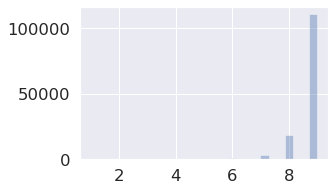

In [4]:
task_name = 'qm9'
tasks = [
   "mu","alpha","homo","lumo","gap","r2","zpve","u0","u298","h298","g298","cv"
]

raw_filename = "../data/gdb9_smiles.csv"
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)

smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
#         print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 500
epochs = 300

p_dropout= 0.2
fingerprint_dim = 64

weight_decay = 4.9 # also known as l2_regularization_lambda
learning_rate = 3.5
K = 5
T = 3
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num


In [6]:
test_df = smiles_tasks_df.sample(frac=1/10, random_state=SEED) # test set
training_data = smiles_tasks_df.drop(test_df.index) # training data

# get the stats of the seen dataset (the training data)
# which will be used to noramlize the dataset. 
columns = ['Task','Mean','Standard deviation', 'Mean absolute deviation','ratio']
mean_list=[]
std_list=[]
mad_list=[]
ratio_list=[]
training_label_list = []
test_label_list = []
for task in tasks:
    mean = training_data[task].mean()
    mean_list.append(mean)
    std = training_data[task].std()
    std_list.append(std)
    mad = training_data[task].mad()
    mad_list.append(mad)
    ratio_list.append(std/mad)
    training_data[task+'_normalized'] = (training_data[task]- mean)/std
    # the mean and standard deviation of training data is also used in test set
    test_df[task+'_normalized'] = (test_df[task]- mean)/std
    training_label_list.append(training_data[task+'_normalized'].values)
    test_label_list.append(test_df[task+'_normalized'].values)

training_label = np.array(training_label_list).astype(np.float).transpose()
test_label = np.array(test_label_list).astype(np.float).transpose()

    
# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=SEED) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

while (len(train_df) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

list_of_tuples = list(zip(tasks, mean_list, std_list, mad_list, ratio_list))
stats  = pd.DataFrame(list_of_tuples, columns = columns)
stats


batch size:  503


,Task,Mean,Standard deviation,Mean absolute deviation,ratio
0,mu,2.708713,1.531956,1.191056,1.286217
1,alpha,75.190920,8.197607,6.308065,1.299544
2,homo,-0.239974,0.022176,0.016340,1.357178
3,lumo,0.011026,0.046912,0.038618,1.214779
4,gap,0.250999,0.047505,0.039648,1.198148
5,r2,1190.034973,279.648930,202.109506,1.383651
6,zpve,0.148522,0.033298,0.026472,1.257836
7,u0,-411.587569,40.087880,31.106651,1.288724
8,u298,-411.579095,40.087661,31.106518,1.288722
9,h298,-411.578151,40.087661,31.106518,1.288722


In [7]:
# # check the value distribution of different tasks
# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [8]:
# # check the distribution after normalization (should be the same)

# plt.figure(figsize=(28, 8),dpi=300)
# gs = gridspec.GridSpec(2, 6)
# sns.set(font_scale=1.8)
# for i, task in enumerate(tasks):
#     plt.subplot(gs[(i)])
#     x = pd.Series(training_data[task+"_normalized"].values, name=task)
#     ax = sns.distplot(x, bins=28, kde=False)
#     plt.tight_layout()
# plt.show()
# plt.close()

In [9]:
training_smiles = training_data['smiles'].values
test_smiles = test_df['smiles'].values
training_graph_dict = graph_dict(training_smiles, list(training_label), filename+'_training_seed'+str(SEED))
test_graph_dict = graph_dict(test_smiles, list(test_label), filename+'_test_seed'+str(SEED))
whole_graph_dict = {**training_graph_dict, **test_graph_dict}

graph dicts loaded from ../data/gdb9_smiles_training_seed28.pkl
graph dicts loaded from ../data/gdb9_smiles_test_seed28.pkl


In [10]:
ratio_array = torch.from_numpy(np.array(ratio_list).astype(np.float)).float()
ratio_array = ratio_array.to(device)
std_array = torch.from_numpy(np.array(std_list).astype(np.float)).float()
std_array = ratio_array.to(device)

ratio_array_square = ratio_array[None,:]**2
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)
# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

544404
preprocess.0.linear.weight torch.Size([64, 39])
preprocess.0.linear.bias torch.Size([64])
preprocess.0.bn.weight torch.Size([64])
preprocess.0.bn.bias torch.Size([64])
propagate.0.encoder.0.linear.weight torch.Size([4096, 10])
propagate.0.encoder.0.linear.bias torch.Size([4096])
propagate.0.encoder.0.bn.weight torch.Size([4096])
propagate.0.encoder.0.bn.bias torch.Size([4096])
propagate.0.align.weight torch.Size([1, 128])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([64, 64])
propagate.0.attend.linear.bias torch.Size([64])
propagate.0.attend.bn.weight torch.Size([64])
propagate.0.attend.bn.bias torch.Size([64])
propagate.0.gru.weight_ih torch.Size([192, 64])
propagate.0.gru.weight_hh torch.Size([192, 64])
propagate.0.gru.bias_ih torch.Size([192])
propagate.0.gru.bias_hh torch.Size([192])
propagate.1.encoder.0.linear.weight torch.Size([4096, 10])
propagate.1.encoder.0.linear.bias torch.Size([4096])
propagate.1.encoder.0.bn.weight torch.Size([

In [11]:
def train(model, smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(train_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device) * ratio_array_square # set STD/MAD ratio as the weights
        mol_prediction = model(atom, bond, bond_index, mol_index) * ratio_array_square
        
        loss = loss_function(mol_prediction.reshape(-1), label.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

def eval(model, smiles_list):
    model.eval()
    MAE_array = np.array([])
    MSE_array = np.array([])
    mol_prediction_array = np.array([])
    label_array = np.array([])
        
    eval_loader = DataLoader(graph_dataset(smiles_list, whole_graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in tqdm(enumerate(eval_loader)):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()      
        MSE = F.mse_loss(mol_prediction.reshape(-1), label.reshape(-1), reduction='none').cpu().detach().numpy()
        
#         mol_prediction_array = np.concatenate([mol_prediction_array, mol_prediction.cpu().detach().numpy()])
#         label = label.reshape(-1,12).cpu().detach().numpy()
#         label_array = np.concatenate([label_array.reshape(-1,12),label])
#         print(label_array.shape)
        MAE_array = np.concatenate([MAE_array.reshape(-1,12),MAE.reshape(-1,12)])
        MSE_array = np.concatenate([MSE_array.reshape(-1,12),MSE.reshape(-1,12)])
#     mol_prediction_array = mol_prediction_array.data.squeeze().cpu().numpy()
#     label_array = label_array.data.squeeze().cpu().numpy()    
#     r2_score_list = [r2_score(mol_prediction_array[:,i], label_array[:,i]) for i, task in enumerate(tasks)]
    MAE_normalized = MAE_array.mean(0).reshape(-1)    
    MAE_raw = MAE_normalized * np.array(std_list)
    RMSE_normalized = np.sqrt(MSE_array.mean(0).reshape(-1))
    RMSE_raw = RMSE_normalized * np.array(std_list)

    return MAE_normalized, MAE_raw, RMSE_normalized, RMSE_raw #, r2_score_list


In [12]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE_normalized"] = 800
best_param["valid_MSE_normalized"] = 800
train_df_smiles = train_df.smiles.values
valid_df_smiles = valid_df.smiles.values

for epoch in range(300):
    losses = train(model, train_df_smiles)
    train_MAE_normalized, train_MAE, train_MSE_normalized, train_MSE = eval(model, train_df_smiles)
    valid_MAE_normalized, valid_MAE, valid_MSE_normalized, valid_MSE, = eval(model, valid_df_smiles)
    print("EPOCH:\t"+str(epoch)+' '+str(losses)+'\n'\
#         +"train_MAE_normalized: "+str(train_MAE_normalized)+'\n'\
#         +"valid_MAE_normalized: "+str(valid_MAE_normalized)+'\n'\
        +"train_MAE"+":"+"\n"+str(train_MAE)+'\n'\
        +"valid_MAE"+":"+"\n"+str(valid_MAE)+'\n'\
          
        +"train_MSE_normalized_mean: "+str(train_MSE_normalized.mean())+'\n'\
        +"valid_MSE_normalized_mean: "+str(valid_MSE_normalized.mean())+'\n'\
#         +"train_MSE_normalized: "+str(train_MSE_normalized)+'\n'\
#         +"valid_MSE_normalized: "+str(valid_MSE_normalized)+'\n'\
        )
    if train_MSE_normalized.mean() < best_param["train_MSE_normalized"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE_normalized"] = train_MSE_normalized.mean()
    if valid_MSE_normalized.mean() < best_param["valid_MSE_normalized"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE_normalized"] = valid_MSE_normalized.mean()
        if valid_MSE_normalized.mean() < 0.06:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
    


212it [00:36,  6.12it/s]
212it [00:10, 20.26it/s]
27it [00:01, 22.51it/s]

EPOCH:	0 0.8904543104317953
train_MAE:
[7.81075280e-01 1.42909008e+00 8.82148838e-03 1.24272918e-02
 1.34387004e-02 7.45407917e+01 5.10955246e-03 4.43525330e+00
 4.33239156e+00 4.18733155e+00 4.28436285e+00 6.59049244e-01]
valid_MAE:
[7.71961528e-01 1.44940168e+00 8.81785580e-03 1.23921920e-02
 1.34872549e-02 7.55270076e+01 5.07872165e-03 4.45547917e+00
 4.34528206e+00 4.20669024e+00 4.32687078e+00 6.65136636e-01]
train_MSE_normalized_mean: 0.30303919509229826
valid_MSE_normalized_mean: 0.3007670165065131




212it [00:36,  5.94it/s]
212it [00:12, 17.53it/s]
27it [00:01, 17.10it/s]


EPOCH:	1 0.37974755451926645
train_MAE:
[7.32735074e-01 1.12008278e+00 7.88336067e-03 1.02601118e-02
 1.19709380e-02 6.19146354e+01 4.27342767e-03 3.28889830e+00
 3.31362880e+00 3.52221698e+00 3.48315985e+00 5.54236199e-01]
valid_MAE:
[7.24879195e-01 1.12520728e+00 7.87436169e-03 1.01952840e-02
 1.19824422e-02 6.20884883e+01 4.26787314e-03 3.28493225e+00
 3.30730912e+00 3.52265188e+00 3.48739857e+00 5.62327388e-01]
train_MSE_normalized_mean: 0.2591265933542458
valid_MSE_normalized_mean: 0.2570738299272199



212it [00:36,  6.10it/s]
212it [00:10, 24.97it/s]
27it [00:01, 14.70it/s]

EPOCH:	2 0.30578355308411254
train_MAE:
[6.99774827e-01 8.89060704e-01 7.43872788e-03 8.93857372e-03
 1.13460623e-02 5.65795865e+01 3.68741188e-03 2.04571616e+00
 1.97783590e+00 1.98405921e+00 2.06517554e+00 4.69969786e-01]
valid_MAE:
[6.95019962e-01 8.87529690e-01 7.42864270e-03 8.87479265e-03
 1.13182620e-02 5.69949706e+01 3.70633853e-03 2.06543594e+00
 2.00663355e+00 2.00206421e+00 2.09681317e+00 4.75359316e-01]
train_MSE_normalized_mean: 0.22458251202309795
valid_MSE_normalized_mean: 0.22373616393223308




212it [00:37,  6.46it/s]
212it [00:10, 24.78it/s]
27it [00:01, 17.80it/s]

EPOCH:	3 0.26607563831615
train_MAE:
[6.72129245e-01 8.62340746e-01 6.99771014e-03 8.30398250e-03
 1.04233735e-02 5.24333655e+01 3.19929158e-03 1.62564738e+00
 1.68043766e+00 1.63239875e+00 1.67979347e+00 4.40211328e-01]
valid_MAE:
[6.68218998e-01 8.67100362e-01 6.98193084e-03 8.29855466e-03
 1.04165539e-02 5.27156390e+01 3.22664746e-03 1.64593184e+00
 1.70161218e+00 1.66582995e+00 1.71019402e+00 4.45121679e-01]
train_MSE_normalized_mean: 0.20736062360884347
valid_MSE_normalized_mean: 0.20710636732835055




212it [00:35,  7.03it/s]
212it [00:11, 18.39it/s]
27it [00:01, 22.64it/s]

EPOCH:	4 0.24290592082828846
train_MAE:
[6.47039774e-01 7.73823474e-01 6.78808318e-03 7.91010333e-03
 1.00096345e-02 5.05208598e+01 2.73696764e-03 1.76983028e+00
 1.77318775e+00 1.78634266e+00 1.67374377e+00 4.20253995e-01]
valid_MAE:
[6.42171913e-01 7.77821414e-01 6.77017882e-03 7.89381865e-03
 9.99340730e-03 5.09172585e+01 2.75989585e-03 1.79386799e+00
 1.80673285e+00 1.81777696e+00 1.70243437e+00 4.21046560e-01]
train_MSE_normalized_mean: 0.1994234441586468
valid_MSE_normalized_mean: 0.19879186601281476




212it [00:36,  6.60it/s]
212it [00:10, 20.15it/s]
27it [00:01, 19.25it/s]

EPOCH:	5 0.22663610758927633
train_MAE:
[6.33584504e-01 8.01351167e-01 6.49985898e-03 7.50324727e-03
 9.62647062e-03 5.00516226e+01 2.53409318e-03 1.29573736e+00
 1.27922416e+00 1.27164517e+00 1.29899961e+00 4.17341847e-01]
valid_MAE:
[6.29091526e-01 8.05253227e-01 6.45843238e-03 7.47596997e-03
 9.57353609e-03 5.03222439e+01 2.58087144e-03 1.31967090e+00
 1.30326135e+00 1.29967401e+00 1.31852011e+00 4.19543664e-01]
train_MSE_normalized_mean: 0.1900962911540501
valid_MSE_normalized_mean: 0.18927274407144198




212it [00:35,  6.48it/s]
212it [00:12, 23.26it/s]
27it [00:01, 21.09it/s]

EPOCH:	6 0.21607303893509902
train_MAE:
[6.18391635e-01 7.34409730e-01 6.36734677e-03 7.55008944e-03
 9.72866047e-03 4.59945509e+01 2.24732285e-03 1.92810613e+00
 1.94788984e+00 1.94285901e+00 1.85044112e+00 4.04510256e-01]
valid_MAE:
[6.14502312e-01 7.38758078e-01 6.37020991e-03 7.47692903e-03
 9.71421358e-03 4.62665634e+01 2.28444067e-03 1.93341447e+00
 1.95670129e+00 1.94752862e+00 1.85600835e+00 4.02999487e-01]
train_MSE_normalized_mean: 0.19057831653598734
valid_MSE_normalized_mean: 0.1898343544585286




212it [00:36,  6.39it/s]
212it [00:10, 20.22it/s]
27it [00:01, 17.27it/s]

EPOCH:	7 0.20704373464269457
train_MAE:
[6.14215935e-01 7.28240584e-01 6.18513424e-03 7.30936355e-03
 9.21135824e-03 4.55114209e+01 2.19086037e-03 2.65246349e+00
 2.60310950e+00 2.64655942e+00 2.60600271e+00 3.82625519e-01]
valid_MAE:
[6.09888072e-01 7.30453175e-01 6.15363976e-03 7.30712077e-03
 9.21949267e-03 4.59277011e+01 2.24827016e-03 2.66546572e+00
 2.61352177e+00 2.65883740e+00 2.61442310e+00 3.82352836e-01]
train_MSE_normalized_mean: 0.19168922451747653
valid_MSE_normalized_mean: 0.19078862099881078




212it [00:36,  6.28it/s]
212it [00:10, 24.66it/s]
27it [00:01, 18.70it/s]

EPOCH:	8 0.19973515381790558
train_MAE:
[6.08738803e-01 7.53567047e-01 6.21836010e-03 7.05917680e-03
 9.12730741e-03 4.53625080e+01 2.38696658e-03 1.97757750e+00
 1.99170910e+00 1.92823795e+00 1.97630786e+00 3.90883147e-01]
valid_MAE:
[6.05745669e-01 7.57968956e-01 6.20037907e-03 7.03952563e-03
 9.11546874e-03 4.55342809e+01 2.41855380e-03 1.98468093e+00
 1.99809819e+00 1.93508641e+00 1.97800172e+00 3.91714561e-01]
train_MSE_normalized_mean: 0.1860430744166339
valid_MSE_normalized_mean: 0.18537410728655979




212it [00:35,  6.32it/s]
212it [00:11, 23.88it/s]
27it [00:01, 17.73it/s]

EPOCH:	9 0.19425093649693256
train_MAE:
[5.97403846e-01 7.03853833e-01 6.10294394e-03 7.35359516e-03
 9.05358370e-03 4.37240522e+01 2.54567699e-03 2.25333037e+00
 2.18347656e+00 2.21405198e+00 2.29521073e+00 4.25248242e-01]
valid_MAE:
[5.95189071e-01 7.14264297e-01 6.11699499e-03 7.30283632e-03
 9.05833555e-03 4.40120360e+01 2.59795965e-03 2.24850819e+00
 2.17623242e+00 2.20805295e+00 2.29027440e+00 4.27691136e-01]
train_MSE_normalized_mean: 0.1874267488386111
valid_MSE_normalized_mean: 0.18734069020895663




212it [00:35,  6.93it/s]
212it [00:11, 18.75it/s]
27it [00:01, 15.33it/s]

EPOCH:	10 0.189055277983535
train_MAE:
[5.90084119e-01 6.94719932e-01 5.94930867e-03 6.82115134e-03
 8.76815966e-03 4.19525467e+01 1.97230686e-03 9.57393767e-01
 9.48842354e-01 9.52443956e-01 9.73557953e-01 3.57663538e-01]
valid_MAE:
[5.86868014e-01 7.01792340e-01 5.98006802e-03 6.80323761e-03
 8.76044487e-03 4.23348936e+01 2.01760277e-03 9.68493341e-01
 9.60922641e-01 9.65219161e-01 9.85165075e-01 3.58663538e-01]
train_MSE_normalized_mean: 0.16971205452912064
valid_MSE_normalized_mean: 0.16937218808769108




212it [00:36,  6.53it/s]
212it [00:10, 19.43it/s]
27it [00:01, 22.85it/s]


EPOCH:	11 0.18412854030447187
train_MAE:
[5.86702232e-01 6.76818246e-01 5.87920987e-03 6.77789648e-03
 8.82615853e-03 4.16454796e+01 1.86395575e-03 1.85355816e+00
 1.86873161e+00 1.83188734e+00 1.89490418e+00 3.61470987e-01]
valid_MAE:
[5.85296869e-01 6.81106952e-01 5.89121557e-03 6.72416671e-03
 8.80164850e-03 4.18378921e+01 1.88243931e-03 1.85364240e+00
 1.86688503e+00 1.83112123e+00 1.89228867e+00 3.62516822e-01]
train_MSE_normalized_mean: 0.1760994446531302
valid_MSE_normalized_mean: 0.17534947767588846



212it [00:35,  6.70it/s]
212it [00:11, 17.96it/s]
27it [00:01, 16.46it/s]

EPOCH:	12 0.18000971793003803
train_MAE:
[5.80370008e-01 6.99388114e-01 5.76651069e-03 6.63856038e-03
 8.50180961e-03 4.12134473e+01 2.14939726e-03 1.67602010e+00
 1.66990145e+00 1.69540786e+00 1.65119018e+00 3.60997211e-01]
valid_MAE:
[5.77452920e-01 7.08720790e-01 5.78342492e-03 6.59565955e-03
 8.49169758e-03 4.15826831e+01 2.19662831e-03 1.68368673e+00
 1.67726840e+00 1.70161375e+00 1.66113430e+00 3.61791618e-01]
train_MSE_normalized_mean: 0.17281825516444713
valid_MSE_normalized_mean: 0.17236616522023127




212it [00:36,  6.44it/s]
212it [00:10, 24.51it/s]
27it [00:01, 15.98it/s]

EPOCH:	13 0.17694218456745148
train_MAE:
[5.74659746e-01 7.01837023e-01 5.85310264e-03 6.55005535e-03
 8.34470473e-03 4.03653987e+01 1.95935290e-03 1.20069312e+00
 1.20894149e+00 1.20737793e+00 1.19784495e+00 3.39660542e-01]
valid_MAE:
[5.73511722e-01 7.09186175e-01 5.88603940e-03 6.52339283e-03
 8.38236577e-03 4.07158401e+01 1.99891483e-03 1.21026239e+00
 1.21851398e+00 1.21753533e+00 1.20370164e+00 3.38585254e-01]
train_MSE_normalized_mean: 0.16745937968292168
valid_MSE_normalized_mean: 0.16747148269145876




212it [00:36,  6.34it/s]
212it [00:12, 22.02it/s]
27it [00:01, 18.64it/s]

EPOCH:	14 0.17353667283676705
train_MAE:
[5.75538562e-01 6.93007797e-01 5.71518343e-03 6.74829457e-03
 8.76534948e-03 3.99644881e+01 2.10615547e-03 2.03786252e+00
 1.99853269e+00 1.99502346e+00 2.03800269e+00 3.44557211e-01]
valid_MAE:
[5.73520703e-01 7.00354628e-01 5.73877625e-03 6.71945149e-03
 8.78456917e-03 4.02214174e+01 2.14017609e-03 2.04665976e+00
 2.00751572e+00 2.00637946e+00 2.04442840e+00 3.44385464e-01]
train_MSE_normalized_mean: 0.17438735221030136
valid_MSE_normalized_mean: 0.1741951842322066




212it [00:37,  6.07it/s]
212it [00:11, 18.33it/s]
27it [00:02, 13.10it/s]

EPOCH:	15 0.17020489563638308
train_MAE:
[5.70607308e-01 6.31367470e-01 5.69114418e-03 6.32491183e-03
 8.21783085e-03 3.97939758e+01 2.10566380e-03 1.30729385e+00
 1.31031750e+00 1.32140952e+00 1.31283958e+00 3.34776627e-01]
valid_MAE:
[5.72936582e-01 6.35284154e-01 5.73517358e-03 6.31089285e-03
 8.25845939e-03 4.01424121e+01 2.13208725e-03 1.32160506e+00
 1.32290845e+00 1.33553252e+00 1.32914659e+00 3.32899556e-01]
train_MSE_normalized_mean: 0.16456431299075852
valid_MSE_normalized_mean: 0.16517346844357342




212it [00:36,  6.42it/s]
212it [00:10, 19.66it/s]
27it [00:01, 19.21it/s]

EPOCH:	16 0.1678558237991243
train_MAE:
[5.66984060e-01 6.94659400e-01 5.57684782e-03 6.43791262e-03
 8.34947938e-03 3.92226868e+01 1.83692814e-03 1.11369962e+00
 1.10513820e+00 1.10954372e+00 1.10557165e+00 4.19453094e-01]
valid_MAE:
[5.69238975e-01 7.03247505e-01 5.60254500e-03 6.45434292e-03
 8.42711754e-03 3.96076737e+01 1.88074163e-03 1.12243652e+00
 1.11500314e+00 1.12101375e+00 1.11171860e+00 4.23746154e-01]
train_MSE_normalized_mean: 0.16478540947300532
valid_MSE_normalized_mean: 0.165691923327515




212it [00:36,  6.07it/s]
212it [00:10, 24.17it/s]
27it [00:01, 17.76it/s]


EPOCH:	17 0.16552251296223336
train_MAE:
[5.67543999e-01 6.60576573e-01 5.50326630e-03 6.18910090e-03
 7.97700517e-03 3.80853078e+01 2.04830335e-03 1.17274381e+00
 1.18062623e+00 1.18110244e+00 1.18084216e+00 3.45164492e-01]
valid_MAE:
[5.69682737e-01 6.69148752e-01 5.53131139e-03 6.13644372e-03
 8.00477911e-03 3.85181628e+01 2.07187215e-03 1.18130409e+00
 1.19076239e+00 1.19100967e+00 1.18802317e+00 3.45262501e-01]
train_MSE_normalized_mean: 0.16164798274866843
valid_MSE_normalized_mean: 0.16190315223110616



212it [00:36,  6.62it/s]
212it [00:11, 18.42it/s]
27it [00:02, 12.44it/s]

EPOCH:	18 0.16346650169986598
train_MAE:
[5.56758547e-01 6.42894722e-01 5.43763781e-03 6.07237897e-03
 7.94914838e-03 3.73153561e+01 1.73974158e-03 1.22170033e+00
 1.23307566e+00 1.22253524e+00 1.22699886e+00 3.32971842e-01]
valid_MAE:
[5.61783636e-01 6.49741546e-01 5.49178828e-03 6.04506703e-03
 7.99283863e-03 3.76507135e+01 1.76547773e-03 1.24238771e+00
 1.25375156e+00 1.24347595e+00 1.24648351e+00 3.33038372e-01]
train_MSE_normalized_mean: 0.15870693333593125
valid_MSE_normalized_mean: 0.15948387273550388




212it [00:41,  6.46it/s]
212it [00:11, 18.69it/s]
27it [00:01, 20.77it/s]

EPOCH:	19 0.16015349476123755
train_MAE:
[5.52328127e-01 6.05880131e-01 5.49856236e-03 6.20239163e-03
 7.95093761e-03 3.84988740e+01 1.83754833e-03 1.30870389e+00
 1.32312365e+00 1.32111085e+00 1.30934665e+00 3.30169643e-01]
valid_MAE:
[5.59610791e-01 6.12256731e-01 5.55320659e-03 6.18209305e-03
 8.03700238e-03 3.90993973e+01 1.86186003e-03 1.30689542e+00
 1.32085320e+00 1.31917577e+00 1.30879148e+00 3.28384474e-01]
train_MSE_normalized_mean: 0.15900803498148725
valid_MSE_normalized_mean: 0.16034350429339977




212it [00:40,  6.43it/s]
212it [00:10, 20.68it/s]
27it [00:01, 23.83it/s]

EPOCH:	20 0.15841730515349586
train_MAE:
[5.51553556e-01 6.11314640e-01 5.25836487e-03 6.01452504e-03
 7.79986143e-03 3.86727686e+01 1.82845554e-03 1.25946506e+00
 1.25822009e+00 1.25571978e+00 1.29497985e+00 3.44037243e-01]
valid_MAE:
[5.53731764e-01 6.19734872e-01 5.28740353e-03 5.94792945e-03
 7.80098358e-03 3.93583618e+01 1.85402580e-03 1.26587774e+00
 1.26424475e+00 1.26277218e+00 1.29985247e+00 3.47616343e-01]
train_MSE_normalized_mean: 0.15744161977488158
valid_MSE_normalized_mean: 0.15767297628313504




212it [00:36,  5.98it/s]
212it [00:09, 24.58it/s]
27it [00:01, 23.10it/s]

EPOCH:	21 0.15705825268941107
train_MAE:
[5.46916541e-01 6.72744165e-01 5.29689841e-03 6.96925317e-03
 8.35633973e-03 3.69627221e+01 2.40697618e-03 2.68905850e+00
 2.68785649e+00 2.70510075e+00 2.68740067e+00 3.36334583e-01]
valid_MAE:
[5.52203398e-01 6.77398422e-01 5.31349471e-03 6.88616135e-03
 8.37275963e-03 3.73932787e+01 2.42370842e-03 2.66928276e+00
 2.66751355e+00 2.68463859e+00 2.66893527e+00 3.37312687e-01]
train_MSE_normalized_mean: 0.17282550616123182
valid_MSE_normalized_mean: 0.17314453748996914




212it [00:36,  6.13it/s]
212it [00:12, 17.08it/s]
27it [00:01, 17.97it/s]

EPOCH:	22 0.15436703388421041
train_MAE:
[5.43456641e-01 6.18187944e-01 5.17465487e-03 6.15334288e-03
 7.72740782e-03 4.37760629e+01 2.03462363e-03 2.06626227e+00
 2.07155365e+00 2.07354809e+00 2.04941286e+00 3.60710800e-01]
valid_MAE:
[5.48629440e-01 6.23331095e-01 5.22067166e-03 6.11518817e-03
 7.85463637e-03 4.45310911e+01 2.05874384e-03 2.07807521e+00
 2.08309292e+00 2.08561291e+00 2.06211421e+00 3.60057576e-01]
train_MSE_normalized_mean: 0.16512489299557423
valid_MSE_normalized_mean: 0.1661677573639595




212it [00:36,  6.41it/s]
212it [00:09, 21.56it/s]
27it [00:01, 17.95it/s]

EPOCH:	23 0.15235561750969798
train_MAE:
[5.46071288e-01 6.32448374e-01 5.21792134e-03 7.12110151e-03
 8.57337379e-03 3.68467999e+01 1.89271691e-03 2.06930796e+00
 2.07977188e+00 2.07094613e+00 2.08385934e+00 3.09973659e-01]
valid_MAE:
[5.53498261e-01 6.36250188e-01 5.30217947e-03 7.06562244e-03
 8.68207539e-03 3.73877124e+01 1.90834529e-03 2.06903312e+00
 2.08019893e+00 2.07048452e+00 2.08432251e+00 3.08800061e-01]
train_MSE_normalized_mean: 0.16417668823661719
valid_MSE_normalized_mean: 0.16561366797519192




212it [00:37,  5.58it/s]
212it [00:11, 25.16it/s]
27it [00:01, 19.07it/s]

EPOCH:	24 0.1517712552240997
train_MAE:
[5.38992299e-01 6.70178684e-01 5.23305019e-03 5.98295046e-03
 7.60668389e-03 4.24797812e+01 1.88225229e-03 2.86994194e+00
 2.86229506e+00 2.86342890e+00 2.91577498e+00 3.82394346e-01]
valid_MAE:
[5.43067035e-01 6.78315595e-01 5.26580618e-03 5.94120065e-03
 7.68273623e-03 4.28470877e+01 1.91618887e-03 2.88693996e+00
 2.87944548e+00 2.88077645e+00 2.93180806e+00 3.83815938e-01]
train_MSE_normalized_mean: 0.17130566188174834
valid_MSE_normalized_mean: 0.17228805257176472




212it [00:36,  6.21it/s]
212it [00:10, 19.68it/s]
27it [00:01, 14.97it/s]

EPOCH:	25 0.1488541952984513
train_MAE:
[5.43846377e-01 8.47607202e-01 5.13484444e-03 5.79384109e-03
 7.54915282e-03 4.06559631e+01 3.04617300e-03 1.34208667e+00
 1.33640715e+00 1.33411005e+00 1.35686323e+00 4.40016506e-01]
valid_MAE:
[5.50156981e-01 8.53743293e-01 5.21102394e-03 5.78941923e-03
 7.65759043e-03 4.09609260e+01 3.07852285e-03 1.36429215e+00
 1.35909594e+00 1.35702184e+00 1.37889073e+00 4.42548037e-01]
train_MSE_normalized_mean: 0.16223347623220852
valid_MSE_normalized_mean: 0.16398179069004962




212it [00:37,  6.63it/s]
212it [00:09, 22.10it/s]
27it [00:01, 19.24it/s]

EPOCH:	26 0.1473972441031123
train_MAE:
[5.46961342e-01 6.79615362e-01 5.01564021e-03 5.89673738e-03
 7.58596026e-03 3.86119225e+01 1.58703501e-03 1.60806556e+00
 1.61746532e+00 1.61269034e+00 1.61757556e+00 3.12956498e-01]
valid_MAE:
[5.53436911e-01 6.85677170e-01 5.07556422e-03 5.90876825e-03
 7.70338347e-03 3.95858773e+01 1.61948325e-03 1.60552445e+00
 1.61548569e+00 1.61053025e+00 1.61419822e+00 3.14626525e-01]
train_MSE_normalized_mean: 0.15561295774224207
valid_MSE_normalized_mean: 0.1573896027321697




212it [00:34,  6.52it/s]
212it [00:10, 19.75it/s]
27it [00:01, 16.65it/s]

EPOCH:	27 0.14652023004051648
train_MAE:
[5.25816127e-01 6.09879029e-01 4.98484254e-03 5.76422374e-03
 7.40528714e-03 3.70185010e+01 1.59818256e-03 8.50120523e-01
 8.51534422e-01 8.54407730e-01 8.41845708e-01 3.10803632e-01]
valid_MAE:
[5.32925366e-01 6.16416263e-01 5.06202068e-03 5.71026368e-03
 7.47709418e-03 3.77780157e+01 1.63078542e-03 8.54132030e-01
 8.56504159e-01 8.59291573e-01 8.45860010e-01 3.12076096e-01]
train_MSE_normalized_mean: 0.14594706581738645
valid_MSE_normalized_mean: 0.14764993999777773




212it [00:35,  6.34it/s]
212it [00:09, 22.06it/s]
27it [00:01, 16.27it/s]

EPOCH:	28 0.1454285667190012
train_MAE:
[5.25887972e-01 5.98328668e-01 4.95720103e-03 5.59617913e-03
 7.24373465e-03 3.54382105e+01 1.49363718e-03 1.05070073e+00
 1.04167138e+00 1.04096584e+00 1.06116227e+00 2.99300787e-01]
valid_MAE:
[5.34609218e-01 6.06606834e-01 5.04613919e-03 5.57727723e-03
 7.36275114e-03 3.61435579e+01 1.53034149e-03 1.06826362e+00
 1.05933226e+00 1.05874162e+00 1.07795753e+00 3.01047077e-01]
train_MSE_normalized_mean: 0.14592940500536264
valid_MSE_normalized_mean: 0.14820680396636496




212it [00:34,  6.48it/s]
212it [00:10, 20.72it/s]
27it [00:01, 17.38it/s]

EPOCH:	29 0.14336830033165104
train_MAE:
[5.24635822e-01 6.12034289e-01 4.85684867e-03 5.57036738e-03
 7.26595238e-03 3.53535960e+01 1.41202035e-03 1.78629790e+00
 1.78133462e+00 1.78675484e+00 1.78904490e+00 3.00295567e-01]
valid_MAE:
[5.33590312e-01 6.19775805e-01 4.93104635e-03 5.54143039e-03
 7.37293449e-03 3.61003784e+01 1.45581212e-03 1.79848584e+00
 1.79363771e+00 1.79911680e+00 1.80056858e+00 3.01209351e-01]
train_MSE_normalized_mean: 0.15146443753449945
valid_MSE_normalized_mean: 0.15367377731942183




212it [00:34,  6.53it/s]
212it [00:10, 24.40it/s]
27it [00:01, 22.43it/s]


EPOCH:	30 0.14186723649782954
train_MAE:
[5.23757368e-01 5.90082467e-01 4.88665014e-03 5.65791475e-03
 7.19541346e-03 3.57723786e+01 1.54586466e-03 9.74888616e-01
 9.78716940e-01 9.78753902e-01 9.60820870e-01 2.93971880e-01]
valid_MAE:
[5.30499321e-01 5.99463198e-01 4.93456600e-03 5.63146978e-03
 7.26829813e-03 3.65728613e+01 1.57559517e-03 9.86721229e-01
 9.90579567e-01 9.90029627e-01 9.73567855e-01 2.96113717e-01]
train_MSE_normalized_mean: 0.14418199682298344
valid_MSE_normalized_mean: 0.14601636802869467



212it [00:34,  6.60it/s]
212it [00:09, 22.64it/s]
27it [00:01, 20.65it/s]

EPOCH:	31 0.1405579760530085
train_MAE:
[5.20972385e-01 5.89629416e-01 4.87293747e-03 5.51259479e-03
 7.18567717e-03 3.47437861e+01 1.58033012e-03 9.29294539e-01
 9.26698000e-01 9.29086867e-01 9.38736305e-01 3.00005359e-01]
valid_MAE:
[5.30963618e-01 5.98613755e-01 4.99942726e-03 5.51675485e-03
 7.34528769e-03 3.56633199e+01 1.59740176e-03 9.44594210e-01
 9.42244610e-01 9.44160538e-01 9.53836457e-01 3.00060583e-01]
train_MSE_normalized_mean: 0.14335859867789433
valid_MSE_normalized_mean: 0.14613550129549377




212it [00:34,  6.17it/s]
212it [00:09, 21.71it/s]
27it [00:01, 20.70it/s]

EPOCH:	32 0.13973416293145352
train_MAE:
[5.15960071e-01 6.03765684e-01 4.94910452e-03 5.59229054e-03
 7.59055352e-03 3.47032677e+01 1.81367462e-03 1.06393991e+00
 1.06481912e+00 1.06301104e+00 1.06410884e+00 3.15516434e-01]
valid_MAE:
[5.25534123e-01 6.11007142e-01 5.04927492e-03 5.59316717e-03
 7.72429754e-03 3.55163778e+01 1.85222916e-03 1.07772271e+00
 1.07942963e+00 1.07759779e+00 1.07737684e+00 3.16265825e-01]
train_MSE_normalized_mean: 0.14589590917275022
valid_MSE_normalized_mean: 0.14837798051896303




212it [00:35,  5.69it/s]
212it [00:10, 23.53it/s]
27it [00:01, 17.19it/s]

EPOCH:	33 0.13873492153185718
train_MAE:
[5.20021841e-01 7.60540095e-01 4.88981813e-03 5.52700738e-03
 6.95666147e-03 3.80351179e+01 2.74358342e-03 1.51228227e+00
 1.51170359e+00 1.51342158e+00 1.51895036e+00 4.63176969e-01]
valid_MAE:
[5.30231840e-01 7.64537547e-01 4.98043481e-03 5.48989322e-03
 7.03832850e-03 3.87566415e+01 2.77999283e-03 1.53165918e+00
 1.53160882e+00 1.53307712e+00 1.53789032e+00 4.67181856e-01]
train_MSE_normalized_mean: 0.15589574247833346
valid_MSE_normalized_mean: 0.15854491602160337




212it [00:34,  6.35it/s]
212it [00:10, 21.19it/s]
27it [00:01, 14.27it/s]

EPOCH:	34 0.13664855477663707
train_MAE:
[5.28028237e-01 6.05087718e-01 4.81776970e-03 5.39759926e-03
 7.11628332e-03 3.51831639e+01 1.65666189e-03 1.63938360e+00
 1.63945941e+00 1.63734599e+00 1.63890427e+00 3.31945376e-01]
valid_MAE:
[5.39772913e-01 6.15632130e-01 4.93893070e-03 5.40451786e-03
 7.27596957e-03 3.60505112e+01 1.69085196e-03 1.64422283e+00
 1.64404455e+00 1.64168987e+00 1.64404412e+00 3.34059468e-01]
train_MSE_normalized_mean: 0.14927536698250685
valid_MSE_normalized_mean: 0.15243399681076078




212it [00:36,  6.18it/s]
212it [00:12, 24.45it/s]
27it [00:01, 16.78it/s]

EPOCH:	35 0.13777695754367225
train_MAE:
[5.10486573e-01 6.43911715e-01 4.72861887e-03 5.48814004e-03
 7.11240860e-03 3.42557147e+01 1.48383482e-03 2.67075544e+00
 2.66962676e+00 2.67121654e+00 2.66234682e+00 2.95132756e-01]
valid_MAE:
[5.21855177e-01 6.48575857e-01 4.88971962e-03 5.48786362e-03
 7.25817256e-03 3.48999547e+01 1.51573589e-03 2.65874962e+00
 2.65749503e+00 2.65889244e+00 2.65123567e+00 2.96161932e-01]
train_MSE_normalized_mean: 0.15574566042658833
valid_MSE_normalized_mean: 0.15857753742823957




212it [00:35,  6.94it/s]
212it [00:10, 23.14it/s]
27it [00:01, 13.72it/s]

EPOCH:	36 0.1350158486023264
train_MAE:
[5.28030173e-01 5.77710799e-01 4.69161414e-03 5.33901410e-03
 6.89325017e-03 3.39869915e+01 1.70274728e-03 8.86462807e-01
 8.86589244e-01 8.86925708e-01 8.86019177e-01 3.02690065e-01]
valid_MAE:
[5.39355012e-01 5.84402134e-01 4.78024050e-03 5.35329305e-03
 7.02201410e-03 3.46927254e+01 1.74628896e-03 9.06198575e-01
 9.06622577e-01 9.07028528e-01 9.06143642e-01 3.05433699e-01]
train_MSE_normalized_mean: 0.14055098944320285
valid_MSE_normalized_mean: 0.1436308004519604




212it [00:36,  6.57it/s]
212it [00:11, 24.22it/s]
27it [00:01, 17.37it/s]

EPOCH:	37 0.13506219894537386
train_MAE:
[5.08554180e-01 5.81915290e-01 4.78902393e-03 5.49714823e-03
 6.86388673e-03 3.62936539e+01 1.63112076e-03 1.26935226e+00
 1.26546316e+00 1.26599145e+00 1.27661656e+00 2.94641159e-01]
valid_MAE:
[5.21337559e-01 5.90447351e-01 4.88597284e-03 5.47149580e-03
 6.96790024e-03 3.73144442e+01 1.66676806e-03 1.28437432e+00
 1.28062739e+00 1.28105674e+00 1.29142469e+00 2.97160122e-01]
train_MSE_normalized_mean: 0.14384711395317581
valid_MSE_normalized_mean: 0.14681172992794414




212it [00:36,  6.61it/s]
212it [00:11, 18.98it/s]
27it [00:01, 14.94it/s]

EPOCH:	38 0.13350147318165256
train_MAE:
[5.00008807e-01 6.62701697e-01 4.68996222e-03 5.30547950e-03
 6.92366546e-03 3.50724963e+01 2.07371335e-03 9.50056410e-01
 9.48635033e-01 9.48969307e-01 9.52153295e-01 3.59419367e-01]
valid_MAE:
[5.13799556e-01 6.66628908e-01 4.80358796e-03 5.32888798e-03
 7.05069518e-03 3.59828957e+01 2.10808861e-03 9.68176592e-01
 9.66617133e-01 9.66758486e-01 9.70724910e-01 3.59601685e-01]
train_MSE_normalized_mean: 0.14273917485801643
valid_MSE_normalized_mean: 0.14601570913111606




212it [00:38,  6.42it/s]
212it [00:10, 19.37it/s]
27it [00:01, 16.67it/s]

EPOCH:	39 0.13226930220734398
train_MAE:
[5.11280712e-01 5.97630300e-01 4.73369036e-03 5.53482086e-03
 6.90132572e-03 3.73925510e+01 1.44960471e-03 2.62140926e+00
 2.61602283e+00 2.61868650e+00 2.62704151e+00 2.77047644e-01]
valid_MAE:
[5.24137830e-01 6.05205684e-01 4.83866796e-03 5.53535749e-03
 7.00308841e-03 3.84506298e+01 1.48224109e-03 2.64296361e+00
 2.63789342e+00 2.64059199e+00 2.64806112e+00 2.79928641e-01]
train_MSE_normalized_mean: 0.15418009651546302
valid_MSE_normalized_mean: 0.15741663141196158




212it [00:37,  6.35it/s]
212it [00:12, 17.57it/s]
27it [00:01, 21.29it/s]

EPOCH:	40 0.13128633396524303
train_MAE:
[5.05547743e-01 7.22108261e-01 4.54817918e-03 5.20701147e-03
 6.76118042e-03 3.62393056e+01 1.80018528e-03 9.03446877e-01
 9.06850491e-01 9.07229984e-01 8.99837322e-01 3.04703824e-01]
valid_MAE:
[5.20261293e-01 7.28022993e-01 4.67810499e-03 5.23396528e-03
 6.91190075e-03 3.71086835e+01 1.82965410e-03 9.23183649e-01
 9.26557276e-01 9.26863460e-01 9.19778103e-01 3.07972588e-01]
train_MSE_normalized_mean: 0.14034173638990002
valid_MSE_normalized_mean: 0.14385661489420018




212it [00:38,  5.44it/s]
212it [00:11, 19.16it/s]
27it [00:01, 15.29it/s]

EPOCH:	41 0.13038352479771623
train_MAE:
[5.04097751e-01 5.76538568e-01 4.64390586e-03 5.31586167e-03
 6.73528254e-03 3.48617473e+01 1.45581707e-03 2.55291120e+00
 2.55504717e+00 2.55448044e+00 2.55043399e+00 3.18033823e-01]
valid_MAE:
[5.17965927e-01 5.85343757e-01 4.80057446e-03 5.33127013e-03
 6.93250047e-03 3.58909556e+01 1.49186765e-03 2.52055454e+00
 2.52229983e+00 2.52158812e+00 2.51869654e+00 3.20991294e-01]
train_MSE_normalized_mean: 0.15303809387048267
valid_MSE_normalized_mean: 0.15665189620919076




212it [00:36,  6.44it/s]
212it [00:12, 16.71it/s]
27it [00:01, 14.72it/s]

EPOCH:	42 0.1304188182331481
train_MAE:
[5.11191893e-01 9.34194756e-01 4.57001253e-03 5.55851436e-03
 7.35005383e-03 3.63871959e+01 3.44745836e-03 9.96404092e-01
 9.92589573e-01 9.91792443e-01 1.00289416e+00 4.49444920e-01]
valid_MAE:
[5.24105090e-01 9.36977427e-01 4.69722690e-03 5.53442243e-03
 7.43957611e-03 3.68390920e+01 3.46383138e-03 9.91422004e-01
 9.87590746e-01 9.86817741e-01 9.98570839e-01 4.51409467e-01]
train_MSE_normalized_mean: 0.1519254782504971
valid_MSE_normalized_mean: 0.1549291942131815




212it [00:36,  6.34it/s]
212it [00:10, 20.91it/s]
27it [00:01, 17.12it/s]

EPOCH:	43 0.128730524717918
train_MAE:
[4.97386604e-01 5.42000147e-01 4.55809731e-03 5.39239842e-03
 6.70533523e-03 3.78584913e+01 1.47342102e-03 9.71055465e-01
 9.72695333e-01 9.72367555e-01 9.71282619e-01 2.96578902e-01]
valid_MAE:
[5.12441014e-01 5.51278189e-01 4.69523258e-03 5.41478240e-03
 6.90063457e-03 3.88331306e+01 1.51426837e-03 9.97870104e-01
 9.99432701e-01 9.99135216e-01 9.98411493e-01 2.98264509e-01]
train_MSE_normalized_mean: 0.13835165733983865
valid_MSE_normalized_mean: 0.14229845059629678




212it [00:36,  5.94it/s]
212it [00:10, 19.32it/s]
27it [00:01, 16.24it/s]

EPOCH:	44 0.12843791922589518
train_MAE:
[4.94863113e-01 7.00464718e-01 4.65028958e-03 5.24619170e-03
 6.76756855e-03 3.37556866e+01 1.52814114e-03 4.31032156e+00
 4.31011443e+00 4.30827994e+00 4.31629500e+00 3.14193242e-01]
valid_MAE:
[5.08294671e-01 7.06573835e-01 4.78954661e-03 5.28457120e-03
 6.91799930e-03 3.46830992e+01 1.55420377e-03 4.32517781e+00
 4.32528518e+00 4.32354519e+00 4.33066380e+00 3.18117380e-01]
train_MSE_normalized_mean: 0.1657331234009248
valid_MSE_normalized_mean: 0.16923330578026377




212it [00:37,  6.45it/s]
212it [00:11, 23.42it/s]
27it [00:01, 17.43it/s]

EPOCH:	45 0.12776389760228823
train_MAE:
[4.90970655e-01 5.63621278e-01 4.38998362e-03 5.04632838e-03
 6.53890202e-03 3.40332207e+01 1.45195459e-03 1.23892433e+00
 1.23335922e+00 1.23097410e+00 1.24742466e+00 2.93290071e-01]
valid_MAE:
[5.05912509e-01 5.76077122e-01 4.55219548e-03 5.04824950e-03
 6.69743256e-03 3.49220424e+01 1.48292231e-03 1.25753618e+00
 1.25223015e+00 1.24969206e+00 1.26568143e+00 2.96593417e-01]
train_MSE_normalized_mean: 0.13711511047764777
valid_MSE_normalized_mean: 0.14094234828318242




212it [00:36,  5.95it/s]
212it [00:10, 23.23it/s]
27it [00:01, 14.06it/s]

EPOCH:	46 0.1265012865429217
train_MAE:
[4.87732279e-01 5.86320958e-01 4.45263903e-03 5.57313387e-03
 6.79562662e-03 3.42165019e+01 1.99647726e-03 8.97446547e-01
 8.95904403e-01 8.96225180e-01 8.99851904e-01 3.18330898e-01]
valid_MAE:
[5.02051635e-01 5.93370324e-01 4.60998056e-03 5.57980748e-03
 6.95704846e-03 3.51735216e+01 2.02939971e-03 9.10472526e-01
 9.08976313e-01 9.09366757e-01 9.12975203e-01 3.20810339e-01]
train_MSE_normalized_mean: 0.13735665750605036
valid_MSE_normalized_mean: 0.14104453129000707




212it [00:37,  6.64it/s]
212it [00:11, 17.94it/s]
27it [00:01, 15.24it/s]

EPOCH:	47 0.12507871946073928
train_MAE:
[4.90619966e-01 5.73434723e-01 4.49674723e-03 5.43905954e-03
 6.64060180e-03 3.29069756e+01 1.57075679e-03 1.21671593e+00
 1.21559975e+00 1.21680854e+00 1.22246679e+00 3.20088736e-01]
valid_MAE:
[5.07828839e-01 5.83280978e-01 4.61131908e-03 5.43369966e-03
 6.78725894e-03 3.39209657e+01 1.59334622e-03 1.24031514e+00
 1.23926830e+00 1.24040423e+00 1.24602773e+00 3.21837972e-01]
train_MSE_normalized_mean: 0.13882790932721356
valid_MSE_normalized_mean: 0.1428159895582433




212it [00:36,  6.33it/s]
212it [00:11, 18.34it/s]
27it [00:01, 15.98it/s]

EPOCH:	48 0.12623833682177202
train_MAE:
[4.86546463e-01 5.78053709e-01 4.48370732e-03 5.19146174e-03
 6.66714811e-03 3.28995574e+01 1.69979928e-03 2.28115420e+00
 2.28497233e+00 2.28686665e+00 2.27531390e+00 2.91615021e-01]
valid_MAE:
[5.02769224e-01 5.86987127e-01 4.63151094e-03 5.18018564e-03
 6.81127152e-03 3.37123878e+01 1.72518739e-03 2.26082714e+00
 2.26461927e+00 2.26633766e+00 2.25532403e+00 2.93550220e-01]
train_MSE_normalized_mean: 0.14656436912684834
valid_MSE_normalized_mean: 0.15024896306024987




212it [00:38,  6.12it/s]
212it [00:10, 20.65it/s]
27it [00:01, 16.79it/s]

EPOCH:	49 0.12455482229168685
train_MAE:
[4.85559956e-01 6.70737091e-01 4.40009317e-03 5.02330793e-03
 6.55359343e-03 3.57716757e+01 1.59632067e-03 8.66014712e-01
 8.66144095e-01 8.65925255e-01 8.67829707e-01 3.18829378e-01]
valid_MAE:
[5.02252421e-01 6.77131144e-01 4.53693539e-03 5.07111729e-03
 6.70346726e-03 3.67491422e+01 1.62657617e-03 8.67794297e-01
 8.67801928e-01 8.67618089e-01 8.69898671e-01 3.20730469e-01]
train_MSE_normalized_mean: 0.1361462136184908
valid_MSE_normalized_mean: 0.13995278554251184




212it [00:36,  6.14it/s]
212it [00:12, 17.27it/s]
27it [00:01, 14.94it/s]

EPOCH:	50 0.12351985915370707
train_MAE:
[4.82072030e-01 6.31051832e-01 4.47241701e-03 5.24183023e-03
 6.54779796e-03 3.34526142e+01 1.83256625e-03 1.24528697e+00
 1.24426313e+00 1.24557780e+00 1.24654545e+00 2.99563637e-01]
valid_MAE:
[4.98697898e-01 6.39697129e-01 4.64775653e-03 5.30161089e-03
 6.77773254e-03 3.43587188e+01 1.85638622e-03 1.26477821e+00
 1.26392457e+00 1.26528085e+00 1.26580868e+00 3.02857374e-01]
train_MSE_normalized_mean: 0.13941597164502448
valid_MSE_normalized_mean: 0.14411750033300585




212it [00:37,  6.54it/s]
212it [00:11, 18.75it/s]
27it [00:01, 16.27it/s]

EPOCH:	51 0.12279403322147874
train_MAE:
[4.89338803e-01 5.99587157e-01 4.29383740e-03 5.06867721e-03
 6.50173792e-03 3.37070895e+01 1.34073840e-03 1.29906113e+00
 1.30163792e+00 1.30269647e+00 1.29468612e+00 2.85126560e-01]
valid_MAE:
[5.05966974e-01 6.08657647e-01 4.46638677e-03 5.08379350e-03
 6.63595842e-03 3.47222405e+01 1.37232040e-03 1.29626409e+00
 1.29878753e+00 1.29980323e+00 1.29218903e+00 2.90487813e-01]
train_MSE_normalized_mean: 0.13617158769876522
valid_MSE_normalized_mean: 0.14041170479326662




212it [00:38,  6.10it/s]
212it [00:11, 17.68it/s]
27it [00:01, 16.26it/s]

EPOCH:	52 0.12275398645620302
train_MAE:
[4.79463934e-01 5.85963464e-01 4.37079308e-03 5.00593391e-03
 6.54842139e-03 3.29085041e+01 2.09456767e-03 1.73652124e+00
 1.73195250e+00 1.73173023e+00 1.74226467e+00 2.99009711e-01]
valid_MAE:
[4.96252184e-01 5.94032376e-01 4.53534508e-03 5.05280715e-03
 6.74768301e-03 3.39442144e+01 2.12478060e-03 1.75187647e+00
 1.74754693e+00 1.74734764e+00 1.75723652e+00 3.04097229e-01]
train_MSE_normalized_mean: 0.14082565335643632
valid_MSE_normalized_mean: 0.1453477005637798




212it [00:36,  6.19it/s]
212it [00:12, 17.37it/s]
27it [00:01, 15.38it/s]

EPOCH:	53 0.12191226473956737
train_MAE:
[4.93903471e-01 5.45696483e-01 4.38388955e-03 5.77640816e-03
 6.66740898e-03 3.28083400e+01 1.82608915e-03 1.22165191e+00
 1.22095439e+00 1.21973631e+00 1.22433529e+00 2.82476439e-01]
valid_MAE:
[5.12704040e-01 5.52927644e-01 4.52356355e-03 5.78098570e-03
 6.82988597e-03 3.37732503e+01 1.86122715e-03 1.21611009e+00
 1.21526960e+00 1.21402875e+00 1.21905056e+00 2.85888400e-01]
train_MSE_normalized_mean: 0.1389723944358766
valid_MSE_normalized_mean: 0.14296692169748318




212it [00:37,  6.24it/s]
212it [00:10, 20.08it/s]
27it [00:02, 13.49it/s]

EPOCH:	54 0.12127334093850739
train_MAE:
[4.79108036e-01 6.45341402e-01 4.36627394e-03 4.92682610e-03
 6.31563114e-03 3.32823236e+01 1.92466347e-03 1.01400303e+00
 1.01269262e+00 1.01210571e+00 1.01858571e+00 2.91696936e-01]
valid_MAE:
[4.98160332e-01 6.53085596e-01 4.53786469e-03 4.98618018e-03
 6.50627311e-03 3.41541568e+01 1.95422340e-03 1.02975782e+00
 1.02851960e+00 1.02789029e+00 1.03457497e+00 2.94053595e-01]
train_MSE_normalized_mean: 0.1344074211869875
valid_MSE_normalized_mean: 0.13872497346444726




212it [00:37,  6.02it/s]
212it [00:10, 25.29it/s]
27it [00:01, 18.16it/s]

EPOCH:	55 0.12014358771859475
train_MAE:
[4.73570863e-01 5.38928910e-01 4.31178669e-03 4.99970403e-03
 6.25956665e-03 3.21611849e+01 1.33990548e-03 1.39056005e+00
 1.38909360e+00 1.38774762e+00 1.39407359e+00 2.70478519e-01]
valid_MAE:
[4.93814378e-01 5.47878740e-01 4.46789867e-03 5.02819070e-03
 6.45724554e-03 3.32717717e+01 1.37329827e-03 1.42032333e+00
 1.41909817e+00 1.41787209e+00 1.42353513e+00 2.73475537e-01]
train_MSE_normalized_mean: 0.1353181943747407
valid_MSE_normalized_mean: 0.14028604106854006




212it [00:36,  6.86it/s]
212it [00:10, 22.67it/s]
27it [00:01, 13.70it/s]

EPOCH:	56 0.12042094120439494
train_MAE:
[4.90610040e-01 9.02603723e-01 4.28295453e-03 5.08220206e-03
 6.60766527e-03 3.44574332e+01 2.24613812e-03 1.25151213e+00
 1.25185704e+00 1.25127532e+00 1.25130316e+00 3.80769059e-01]
valid_MAE:
[5.08578875e-01 9.04483744e-01 4.44666725e-03 5.16860767e-03
 6.83972631e-03 3.53758185e+01 2.26675615e-03 1.25645069e+00
 1.25693311e+00 1.25638624e+00 1.25630340e+00 3.82691047e-01]
train_MSE_normalized_mean: 0.14285674540796023
valid_MSE_normalized_mean: 0.147624684438036




212it [00:36,  5.85it/s]
212it [00:11, 18.76it/s]
27it [00:01, 13.94it/s]

EPOCH:	57 0.1198345044241199
train_MAE:
[4.70628614e-01 5.29857200e-01 4.23944165e-03 5.06849349e-03
 6.32512901e-03 3.22838618e+01 1.46539757e-03 1.53503428e+00
 1.53662692e+00 1.53566850e+00 1.53353406e+00 2.67026462e-01]
valid_MAE:
[4.86879847e-01 5.40203395e-01 4.39815076e-03 5.08370227e-03
 6.49261597e-03 3.33351397e+01 1.49675911e-03 1.53067788e+00
 1.53207007e+00 1.53107041e+00 1.52952338e+00 2.71431105e-01]
train_MSE_normalized_mean: 0.13547617422322247
valid_MSE_normalized_mean: 0.13992689465823777




212it [00:36,  5.88it/s]
212it [00:11, 17.90it/s]
27it [00:01, 20.10it/s]

EPOCH:	58 0.11905097641613123
train_MAE:
[4.75348268e-01 5.14357690e-01 4.21966912e-03 4.83105772e-03
 6.21856029e-03 3.20493524e+01 1.33692305e-03 1.15266905e+00
 1.15256616e+00 1.15243545e+00 1.15263585e+00 2.77891816e-01]
valid_MAE:
[4.92954318e-01 5.23993093e-01 4.38947388e-03 4.86479896e-03
 6.41574466e-03 3.29534084e+01 1.36488002e-03 1.17078595e+00
 1.17075788e+00 1.17063071e+00 1.17070285e+00 2.81268939e-01]
train_MSE_normalized_mean: 0.13217872615413306
valid_MSE_normalized_mean: 0.13687344345220281




212it [00:37,  5.55it/s]
212it [00:10, 20.35it/s]
27it [00:01, 19.61it/s]

EPOCH:	59 0.11912217230167028
train_MAE:
[4.74284694e-01 6.99121794e-01 4.45685677e-03 5.04769079e-03
 6.19463920e-03 3.20157573e+01 1.80405437e-03 1.14898695e+00
 1.14897758e+00 1.14858808e+00 1.14969726e+00 3.04071683e-01]
valid_MAE:
[4.91357472e-01 7.07150424e-01 4.62565258e-03 5.05550754e-03
 6.37437416e-03 3.30372455e+01 1.84107990e-03 1.14715990e+00
 1.14696278e+00 1.14652349e+00 1.14829892e+00 3.08095832e-01]
train_MSE_normalized_mean: 0.13657899235746704
valid_MSE_normalized_mean: 0.14133628087677538




212it [00:35,  6.16it/s]
212it [00:10, 21.04it/s]
27it [00:01, 15.87it/s]

EPOCH:	60 0.11852953456482797
train_MAE:
[4.69358589e-01 5.89583604e-01 4.20090422e-03 4.81586946e-03
 6.28665464e-03 3.76417287e+01 1.57563674e-03 1.06355178e+00
 1.06177261e+00 1.06220311e+00 1.06495998e+00 2.85151534e-01]
valid_MAE:
[4.86453335e-01 5.97732083e-01 4.38322762e-03 4.87361690e-03
 6.48807662e-03 3.89739601e+01 1.60591430e-03 1.08246623e+00
 1.08083164e+00 1.08129023e+00 1.08371184e+00 2.89655026e-01]
train_MSE_normalized_mean: 0.13340312351906403
valid_MSE_normalized_mean: 0.13819028661656388




212it [00:36,  6.34it/s]
212it [00:10, 19.66it/s]
27it [00:01, 19.16it/s]

EPOCH:	61 0.11781784280572298
train_MAE:
[4.66649631e-01 5.77262152e-01 4.11191709e-03 4.97673639e-03
 6.29566595e-03 3.39528413e+01 1.74145078e-03 1.13037588e+00
 1.12873997e+00 1.12849124e+00 1.13249673e+00 2.82299551e-01]
valid_MAE:
[4.87404431e-01 5.90837275e-01 4.29588487e-03 5.01492234e-03
 6.50168140e-03 3.50517834e+01 1.76456422e-03 1.15449111e+00
 1.15291795e+00 1.15271697e+00 1.15654591e+00 2.86809253e-01]
train_MSE_normalized_mean: 0.13207488818673532
valid_MSE_normalized_mean: 0.13742905732820976




212it [00:35,  6.04it/s]
212it [00:10, 19.86it/s]
27it [00:01, 16.36it/s]

EPOCH:	62 0.11688472397344292
train_MAE:
[4.66431651e-01 5.59264840e-01 4.10812084e-03 5.56217040e-03
 6.60591369e-03 3.26291723e+01 1.89689951e-03 2.08733336e+00
 2.08385703e+00 2.08616137e+00 2.08958223e+00 2.94444620e-01]
valid_MAE:
[4.85800346e-01 5.72188735e-01 4.33250257e-03 5.64054262e-03
 6.80605174e-03 3.36503187e+01 1.91459258e-03 2.10783822e+00
 2.10449433e+00 2.10680657e+00 2.10987638e+00 2.97988687e-01]
train_MSE_normalized_mean: 0.1415150054905091
valid_MSE_normalized_mean: 0.14662681051898546




212it [00:35,  6.29it/s]
212it [00:10, 20.83it/s]
27it [00:01, 18.64it/s]

EPOCH:	63 0.11681943699576945
train_MAE:
[4.68530312e-01 5.23130121e-01 4.11316800e-03 4.80016821e-03
 6.15916683e-03 3.17677822e+01 1.33132981e-03 1.11574327e+00
 1.11504991e+00 1.11513085e+00 1.11643915e+00 2.61177870e-01]
valid_MAE:
[4.89730604e-01 5.33661530e-01 4.30913985e-03 4.85632450e-03
 6.36422484e-03 3.28060526e+01 1.36922362e-03 1.13413106e+00
 1.13361872e+00 1.13375565e+00 1.13458944e+00 2.65636869e-01]
train_MSE_normalized_mean: 0.12981659333687692
valid_MSE_normalized_mean: 0.1351356401400023




212it [00:35,  6.13it/s]
212it [00:10, 20.87it/s]
27it [00:01, 15.79it/s]

EPOCH:	64 0.11648014019120415
train_MAE:
[4.68047612e-01 5.25152543e-01 4.11924648e-03 5.01935280e-03
 6.23394167e-03 3.20052222e+01 1.30742651e-03 8.00916024e-01
 8.01692101e-01 8.01633719e-01 7.99975287e-01 2.66174983e-01]
valid_MAE:
[4.89030249e-01 5.40129000e-01 4.31207397e-03 5.06322395e-03
 6.44217305e-03 3.30595331e+01 1.33572212e-03 8.16606727e-01
 8.17299479e-01 8.17241815e-01 8.15828409e-01 2.69633636e-01]
train_MSE_normalized_mean: 0.12690178188294923
valid_MSE_normalized_mean: 0.1322635778661472




212it [00:35,  6.54it/s]
212it [00:10, 25.55it/s]
27it [00:01, 19.06it/s]

EPOCH:	65 0.1153009397171016
train_MAE:
[4.78476703e-01 5.41835191e-01 4.09919619e-03 4.95424404e-03
 6.21129158e-03 3.11520795e+01 1.39562204e-03 1.47097185e+00
 1.46906171e+00 1.46846875e+00 1.47380709e+00 2.67742093e-01]
valid_MAE:
[4.99755216e-01 5.55406345e-01 4.29511506e-03 5.07733195e-03
 6.50959600e-03 3.22480156e+01 1.44873571e-03 1.48901526e+00
 1.48713314e+00 1.48649709e+00 1.49191950e+00 2.71127254e-01]
train_MSE_normalized_mean: 0.1335084610126099
valid_MSE_normalized_mean: 0.13942697150437358




212it [00:36,  5.69it/s]
212it [00:11, 19.16it/s]
27it [00:01, 17.85it/s]

EPOCH:	66 0.11524323676273508
train_MAE:
[4.69540561e-01 5.60299871e-01 4.21712082e-03 4.86825109e-03
 6.29623946e-03 3.26841651e+01 1.45946598e-03 9.51496312e-01
 9.52219938e-01 9.52502711e-01 9.51150321e-01 2.71032378e-01]
valid_MAE:
[4.89645610e-01 5.71356426e-01 4.37079550e-03 4.91389457e-03
 6.46613430e-03 3.37259222e+01 1.48150642e-03 9.47438404e-01
 9.47917140e-01 9.48167861e-01 9.47429694e-01 2.76269023e-01]
train_MSE_normalized_mean: 0.1294359461101249
valid_MSE_normalized_mean: 0.13396982334764568




212it [00:36,  6.33it/s]
212it [00:10, 19.47it/s]
27it [00:01, 14.29it/s]

EPOCH:	67 0.11375669432136248
train_MAE:
[4.56676889e-01 5.45880297e-01 4.00394165e-03 4.95448953e-03
 6.28613811e-03 3.12228600e+01 1.51776005e-03 1.42849270e+00
 1.43151533e+00 1.43133521e+00 1.42454679e+00 2.77109343e-01]
valid_MAE:
[4.78943278e-01 5.58793066e-01 4.19736987e-03 5.06358012e-03
 6.51437082e-03 3.22515023e+01 1.54705959e-03 1.42421433e+00
 1.42708363e+00 1.42686123e+00 1.42053934e+00 2.81361634e-01]
train_MSE_normalized_mean: 0.13097921672750004
valid_MSE_normalized_mean: 0.13641099085970523




212it [00:36,  6.59it/s]
212it [00:10, 20.87it/s]
27it [00:01, 17.18it/s]

EPOCH:	68 0.11352787539362907
train_MAE:
[4.59205986e-01 6.51062031e-01 3.98020426e-03 4.93389995e-03
 6.18904414e-03 3.29694177e+01 1.86031173e-03 1.18021070e+00
 1.18125521e+00 1.18201920e+00 1.17894617e+00 3.03100442e-01]
valid_MAE:
[4.81439192e-01 6.60757742e-01 4.16621782e-03 4.95767096e-03
 6.38449468e-03 3.39318775e+01 1.88548515e-03 1.17590049e+00
 1.17667303e+00 1.17738992e+00 1.17502876e+00 3.07218092e-01]
train_MSE_normalized_mean: 0.1328264664619356
valid_MSE_normalized_mean: 0.13797120185990594




212it [00:36,  6.10it/s]
212it [00:13, 16.04it/s]
27it [00:01, 21.34it/s]


EPOCH:	69 0.11368133278809628
train_MAE:
[4.57772100e-01 5.82360208e-01 4.00685031e-03 4.70147385e-03
 6.04034671e-03 3.17952158e+01 1.60033836e-03 1.59487191e+00
 1.59346193e+00 1.59356932e+00 1.59576280e+00 2.86610850e-01]
valid_MAE:
[4.79182693e-01 5.92972874e-01 4.22365965e-03 4.76347105e-03
 6.26886027e-03 3.29150641e+01 1.62724020e-03 1.61929049e+00
 1.61796928e+00 1.61809861e+00 1.62002209e+00 2.90749351e-01]
train_MSE_normalized_mean: 0.13337890831819682
valid_MSE_normalized_mean: 0.13909358000006636



212it [00:39,  5.55it/s]
212it [00:11, 22.02it/s]
27it [00:02, 13.19it/s]

EPOCH:	70 0.11270373458710481
train_MAE:
[4.59992465e-01 5.51991630e-01 4.07616618e-03 4.79060524e-03
 6.25751330e-03 3.08376873e+01 1.31393794e-03 1.40806418e+00
 1.40771147e+00 1.40748791e+00 1.40881980e+00 2.57175439e-01]
valid_MAE:
[4.84460789e-01 5.64173713e-01 4.25328577e-03 4.84407820e-03
 6.43430098e-03 3.19096919e+01 1.33882864e-03 1.42788245e+00
 1.42758305e+00 1.42734449e+00 1.42858165e+00 2.60072114e-01]
train_MSE_normalized_mean: 0.13094193695979683
valid_MSE_normalized_mean: 0.13638080065049699




212it [00:39,  6.15it/s]
212it [00:13, 16.11it/s]
27it [00:02, 13.24it/s]

EPOCH:	71 0.11307579567128757
train_MAE:
[4.56492966e-01 4.89880895e-01 3.99660224e-03 4.78660720e-03
 6.00393257e-03 3.70260092e+01 1.33951979e-03 1.27543765e+00
 1.27723999e+00 1.27669692e+00 1.27304009e+00 2.84886757e-01]
valid_MAE:
[4.79673707e-01 5.04024460e-01 4.20856430e-03 4.85364341e-03
 6.25458992e-03 3.83323311e+01 1.38388491e-03 1.27262942e+00
 1.27438079e+00 1.27381676e+00 1.27032935e+00 2.88996784e-01]
train_MSE_normalized_mean: 0.129926199649986
valid_MSE_normalized_mean: 0.1359557177020467




212it [00:39,  5.81it/s]
212it [00:11, 23.21it/s]
27it [00:02, 11.12it/s]

EPOCH:	72 0.11322062255217219
train_MAE:
[4.56105617e-01 5.73174218e-01 4.00355379e-03 4.99649781e-03
 6.21841149e-03 3.23784362e+01 1.60726374e-03 1.09531671e+00
 1.09429041e+00 1.09405744e+00 1.09665370e+00 2.57083089e-01]
valid_MAE:
[4.79956024e-01 5.86985392e-01 4.19758720e-03 5.07951192e-03
 6.48239024e-03 3.35196869e+01 1.63638877e-03 1.11354899e+00
 1.11259404e+00 1.11236208e+00 1.11479145e+00 2.62104469e-01]
train_MSE_normalized_mean: 0.12895515006269714
valid_MSE_normalized_mean: 0.13505665975984701




212it [00:39,  6.31it/s]
212it [00:13, 21.20it/s]
27it [00:02, 11.95it/s]

EPOCH:	73 0.1120962955338775
train_MAE:
[4.65567156e-01 5.58454649e-01 3.98813151e-03 4.68749724e-03
 6.00164731e-03 3.09304729e+01 1.31364034e-03 1.35513408e+00
 1.35665851e+00 1.35619888e+00 1.35378209e+00 2.53972487e-01]
valid_MAE:
[4.88883244e-01 5.66569900e-01 4.15282434e-03 4.72521918e-03
 6.19406951e-03 3.19709325e+01 1.33131913e-03 1.35508708e+00
 1.35656932e+00 1.35611370e+00 1.35380175e+00 2.57698661e-01]
train_MSE_normalized_mean: 0.12880172964191888
valid_MSE_normalized_mean: 0.13409500560952306




212it [00:40,  6.12it/s]
212it [00:12, 16.99it/s]
27it [00:02, 12.98it/s]

EPOCH:	74 0.1117780846104307
train_MAE:
[4.48517409e-01 4.88229163e-01 4.13950306e-03 4.65375502e-03
 6.16571025e-03 3.46104862e+01 1.23174561e-03 8.41193085e-01
 8.42632471e-01 8.42578112e-01 8.39632623e-01 2.60508655e-01]
valid_MAE:
[4.74945206e-01 5.02194766e-01 4.34583031e-03 4.72429957e-03
 6.43922739e-03 3.58169005e+01 1.27445394e-03 8.58989942e-01
 8.60371382e-01 8.60296681e-01 8.57514830e-01 2.64786958e-01]
train_MSE_normalized_mean: 0.12485557826322947
valid_MSE_normalized_mean: 0.13139062943716773




212it [00:38,  6.26it/s]
212it [00:12, 16.51it/s]
27it [00:02, 12.62it/s]

EPOCH:	75 0.11127596710509849
train_MAE:
[4.48014137e-01 4.92822179e-01 3.91400015e-03 4.81423954e-03
 6.12425564e-03 3.12372952e+01 1.22002335e-03 1.26100506e+00
 1.25963877e+00 1.25962000e+00 1.26235546e+00 2.54071441e-01]
valid_MAE:
[4.72676901e-01 5.08796528e-01 4.13712780e-03 4.87460353e-03
 6.34793739e-03 3.25034788e+01 1.25308516e-03 1.27964127e+00
 1.27834596e+00 1.27832709e+00 1.28094877e+00 2.58865412e-01]
train_MSE_normalized_mean: 0.12706696949678378
valid_MSE_normalized_mean: 0.1334795128422672




212it [00:41,  5.92it/s]
212it [00:13, 20.45it/s]
27it [00:02, 12.35it/s]

EPOCH:	76 0.11040868856153398
train_MAE:
[4.45835819e-01 5.16147429e-01 3.95061774e-03 4.83696148e-03
 5.89918760e-03 3.32283846e+01 1.42586459e-03 1.17283770e+00
 1.17376988e+00 1.17366243e+00 1.17203063e+00 2.74879893e-01]
valid_MAE:
[4.70547879e-01 5.27942271e-01 4.15030361e-03 4.94086283e-03
 6.18474437e-03 3.44803551e+01 1.45974088e-03 1.16383338e+00
 1.16475216e+00 1.16464768e+00 1.16305557e+00 2.79458498e-01]
train_MSE_normalized_mean: 0.12776680035168586
valid_MSE_normalized_mean: 0.13413647698864356




212it [00:41,  5.91it/s]
212it [00:13, 21.88it/s]
27it [00:02, 12.95it/s]

EPOCH:	77 0.10990772768855095
train_MAE:
[4.58214293e-01 4.96143702e-01 3.84874102e-03 5.74402674e-03
 6.78601718e-03 3.27825054e+01 1.52373774e-03 1.77503805e+00
 1.77524765e+00 1.77489062e+00 1.77491782e+00 2.53761904e-01]
valid_MAE:
[4.84659039e-01 5.10708787e-01 4.05834533e-03 5.75009570e-03
 6.96446404e-03 3.41136188e+01 1.56162527e-03 1.76595417e+00
 1.76605482e+00 1.76568454e+00 1.76600365e+00 2.58525376e-01]
train_MSE_normalized_mean: 0.13500671714816553
valid_MSE_normalized_mean: 0.14086473857698736




212it [00:41,  5.68it/s]
212it [00:15, 20.13it/s]
27it [00:02, 10.90it/s]

EPOCH:	78 0.10962470599784041
train_MAE:
[4.44015113e-01 5.24323499e-01 3.91213885e-03 4.68034791e-03
 5.99688450e-03 3.41726166e+01 1.32420215e-03 2.02056591e+00
 2.01928478e+00 2.01900298e+00 2.02222761e+00 2.74705749e-01]
valid_MAE:
[4.67414411e-01 5.38906797e-01 4.15099311e-03 4.78156002e-03
 6.28703391e-03 3.51180481e+01 1.35534879e-03 2.02121213e+00
 2.02000806e+00 2.01972287e+00 2.02279403e+00 2.77542854e-01]
train_MSE_normalized_mean: 0.1336135139280046
valid_MSE_normalized_mean: 0.1399958645588343




212it [00:41,  6.50it/s]
212it [00:13, 15.17it/s]
27it [00:02, 10.52it/s]

EPOCH:	79 0.1101408166072841
train_MAE:
[4.52698907e-01 5.51370240e-01 4.09424898e-03 4.66818743e-03
 6.02928412e-03 3.00511159e+01 1.33939362e-03 1.43539506e+00
 1.43525469e+00 1.43490930e+00 1.43619562e+00 2.44838949e-01]
valid_MAE:
[4.77531285e-01 5.67566408e-01 4.27605318e-03 4.75640423e-03
 6.25970594e-03 3.12798631e+01 1.36986166e-03 1.45047565e+00
 1.45029722e+00 1.44994063e+00 1.45133174e+00 2.50011343e-01]
train_MSE_normalized_mean: 0.12942990234128707
valid_MSE_normalized_mean: 0.1353172777833485




212it [00:40,  5.00it/s]
212it [00:15, 13.37it/s]
27it [00:02, 10.45it/s]

EPOCH:	80 0.10923299576454568
train_MAE:
[4.43737177e-01 4.93885000e-01 3.91982020e-03 4.71219550e-03
 5.99448087e-03 3.08336741e+01 1.17197886e-03 2.10322947e+00
 2.10426508e+00 2.10412135e+00 2.10186096e+00 2.70669040e-01]
valid_MAE:
[4.67726219e-01 5.07290990e-01 4.12305581e-03 4.80462174e-03
 6.24981102e-03 3.19814799e+01 1.20208460e-03 2.08010449e+00
 2.08108662e+00 2.08093530e+00 2.07883079e+00 2.76287141e-01]
train_MSE_normalized_mean: 0.13277074532105856
valid_MSE_normalized_mean: 0.1388269313509484




212it [00:43,  5.67it/s]
212it [00:13, 15.65it/s]
27it [00:01, 13.52it/s]

EPOCH:	81 0.10892684406267023
train_MAE:
[4.47484424e-01 5.47153609e-01 3.97359412e-03 5.86256055e-03
 7.03768905e-03 3.09579504e+01 2.41915186e-03 7.68112380e-01
 7.67601537e-01 7.67490875e-01 7.68758629e-01 3.40512370e-01]
valid_MAE:
[4.72286453e-01 5.60121393e-01 4.16584674e-03 5.90277320e-03
 7.22839577e-03 3.20387889e+01 2.44138705e-03 7.79574271e-01
 7.79021732e-01 7.78908736e-01 7.80278869e-01 3.42637488e-01]
train_MSE_normalized_mean: 0.13017105369931922
valid_MSE_normalized_mean: 0.13606786474640165




212it [00:45,  4.93it/s]
212it [00:16, 18.97it/s]
27it [00:02, 10.36it/s]

EPOCH:	82 0.10802529555446697
train_MAE:
[4.41109061e-01 6.05314716e-01 3.91833482e-03 4.69146943e-03
 5.96882726e-03 3.51560856e+01 1.31938248e-03 1.45905702e+00
 1.45964226e+00 1.45991517e+00 1.45798811e+00 3.06037366e-01]
valid_MAE:
[4.69821607e-01 6.18872570e-01 4.13001108e-03 4.79229020e-03
 6.27299563e-03 3.64493298e+01 1.35897963e-03 1.44963312e+00
 1.45020394e+00 1.45045963e+00 1.44861482e+00 3.09753363e-01]
train_MSE_normalized_mean: 0.13020040434529842
valid_MSE_normalized_mean: 0.1368675745799971




212it [00:43,  5.26it/s]
212it [00:15, 21.22it/s]
27it [00:02, 11.80it/s]

EPOCH:	83 0.10776091866054625
train_MAE:
[4.41416343e-01 4.80829682e-01 4.15278002e-03 4.69243537e-03
 6.26184101e-03 3.01791482e+01 1.25858125e-03 9.19493895e-01
 9.19969131e-01 9.19933926e-01 9.19067593e-01 2.49305368e-01]
valid_MAE:
[4.70171454e-01 4.97177208e-01 4.37864411e-03 4.80455837e-03
 6.57251589e-03 3.15526763e+01 1.29046640e-03 9.23476170e-01
 9.23955410e-01 9.23918866e-01 9.23060472e-01 2.54157278e-01]
train_MSE_normalized_mean: 0.12327691110826189
valid_MSE_normalized_mean: 0.13030609974977814




212it [00:43,  5.51it/s]
212it [00:13, 15.23it/s]
27it [00:02, 12.38it/s]

EPOCH:	84 0.1074336301535368
train_MAE:
[4.38675357e-01 4.97125504e-01 3.89998196e-03 4.50564801e-03
 5.79651252e-03 3.02784382e+01 1.35984341e-03 7.43351779e-01
 7.42895159e-01 7.42926209e-01 7.43926077e-01 2.64198845e-01]
valid_MAE:
[4.65897809e-01 5.09603170e-01 4.10552346e-03 4.59934689e-03
 6.07519618e-03 3.15073106e+01 1.39915211e-03 7.51944497e-01
 7.51537220e-01 7.51564017e-01 7.52469882e-01 2.68130211e-01]
train_MSE_normalized_mean: 0.11994857785361623
valid_MSE_normalized_mean: 0.12650664699093578




212it [00:40,  5.82it/s]
212it [00:12, 16.76it/s]
27it [00:02, 18.39it/s]

EPOCH:	85 0.10719748828911556
train_MAE:
[4.44887329e-01 5.09584878e-01 3.95244316e-03 4.54835252e-03
 5.82179406e-03 3.06712201e+01 1.40441410e-03 1.59465884e+00
 1.59564700e+00 1.59565277e+00 1.59288275e+00 2.56668815e-01]
valid_MAE:
[4.71999564e-01 5.26703118e-01 4.19337267e-03 4.63868671e-03
 6.11041991e-03 3.19610582e+01 1.42618771e-03 1.58883935e+00
 1.58979246e+00 1.58979552e+00 1.58713585e+00 2.63399353e-01]
train_MSE_normalized_mean: 0.12771497277074773
valid_MSE_normalized_mean: 0.13491101046647483




212it [00:40,  6.07it/s]
212it [00:14, 21.35it/s]
27it [00:01, 13.65it/s]

EPOCH:	86 0.10708622736329178
train_MAE:
[4.38198846e-01 5.33453917e-01 3.85353312e-03 4.78291844e-03
 5.78673537e-03 2.98621057e+01 1.41507242e-03 9.29128241e-01
 9.29069157e-01 9.29082691e-01 9.29177758e-01 2.54801774e-01]
valid_MAE:
[4.64655986e-01 5.46884130e-01 4.04483938e-03 4.87618560e-03
 6.06303008e-03 3.10959562e+01 1.44950754e-03 9.36571204e-01
 9.36557095e-01 9.36546400e-01 9.36619598e-01 2.58530166e-01]
train_MSE_normalized_mean: 0.12197194260821849
valid_MSE_normalized_mean: 0.12891233469265342




212it [00:40,  6.08it/s]
212it [00:13, 15.63it/s]
27it [00:02, 12.43it/s]

EPOCH:	87 0.1067761382052921
train_MAE:
[4.38382947e-01 5.09808217e-01 3.82427080e-03 5.47278634e-03
 6.46682892e-03 3.14362290e+01 1.91401549e-03 1.64867016e+00
 1.64888427e+00 1.64887926e+00 1.64833017e+00 2.94236913e-01]
valid_MAE:
[4.63740768e-01 5.23609471e-01 4.04955391e-03 5.50308223e-03
 6.68341753e-03 3.25992146e+01 1.94311340e-03 1.65119477e+00
 1.65137193e+00 1.65136120e+00 1.65093175e+00 2.96577593e-01]
train_MSE_normalized_mean: 0.13334196090631378
valid_MSE_normalized_mean: 0.13949497070916433




212it [00:41,  6.18it/s]
212it [00:14, 21.42it/s]
27it [00:02, 11.86it/s]


EPOCH:	88 0.10762204851884886
train_MAE:
[4.30720398e-01 5.06891870e-01 3.90910567e-03 4.58418830e-03
 5.95775571e-03 3.30711712e+01 1.35793552e-03 1.45604871e+00
 1.45563297e+00 1.45573045e+00 1.45666395e+00 2.61353742e-01]
valid_MAE:
[4.58784590e-01 5.20091807e-01 4.11725140e-03 4.66123513e-03
 6.19186393e-03 3.41808667e+01 1.38086903e-03 1.46980771e+00
 1.46939033e+00 1.46948403e+00 1.47042949e+00 2.66827163e-01]
train_MSE_normalized_mean: 0.12758798611322011
valid_MSE_normalized_mean: 0.13412441050436796



212it [00:41,  5.41it/s]
212it [00:13, 15.62it/s]
27it [00:01, 14.47it/s]

EPOCH:	89 0.10710636853187713
train_MAE:
[4.43651960e-01 4.91570834e-01 3.82693363e-03 4.52967187e-03
 5.78595943e-03 2.96890724e+01 1.25124334e-03 7.86429784e-01
 7.86207851e-01 7.86128540e-01 7.86793549e-01 2.48373458e-01]
valid_MAE:
[4.69874249e-01 5.11585966e-01 4.06801129e-03 4.64996789e-03
 6.07958878e-03 3.09838016e+01 1.28052545e-03 7.97838669e-01
 7.97637332e-01 7.97550200e-01 7.98192978e-01 2.54075625e-01]
train_MSE_normalized_mean: 0.11927383317142921
valid_MSE_normalized_mean: 0.12650714906039684




212it [00:41,  5.29it/s]
212it [00:14, 14.76it/s]
27it [00:02, 12.68it/s]

EPOCH:	90 0.106272572159486
train_MAE:
[4.31518883e-01 6.56571958e-01 3.99878195e-03 5.06393814e-03
 5.95521261e-03 2.95946808e+01 2.31249399e-03 3.65824100e+00
 3.65779391e+00 3.65790808e+00 3.65898195e+00 2.65772302e-01]
valid_MAE:
[4.58807254e-01 6.70286483e-01 4.22877467e-03 5.20045468e-03
 6.27531623e-03 3.09453156e+01 2.32677632e-03 3.67380358e+00
 3.67339621e+00 3.67351886e+00 3.67448553e+00 2.72164460e-01]
train_MSE_normalized_mean: 0.14834732026365854
valid_MSE_normalized_mean: 0.15576186867499023




212it [00:40,  5.38it/s]
212it [00:13, 15.63it/s]
27it [00:01, 14.13it/s]

EPOCH:	91 0.10566602664876659
train_MAE:
[4.34605937e-01 4.88160165e-01 3.88041175e-03 4.56261854e-03
 5.77111323e-03 2.97735350e+01 1.16294093e-03 1.30614187e+00
 1.30593318e+00 1.30600566e+00 1.30636451e+00 2.56908499e-01]
valid_MAE:
[4.61902231e-01 5.03066021e-01 4.08345247e-03 4.67794358e-03
 6.08605369e-03 3.11154936e+01 1.19563550e-03 1.31820531e+00
 1.31795044e+00 1.31801640e+00 1.31849655e+00 2.61986889e-01]
train_MSE_normalized_mean: 0.12355445693979293
valid_MSE_normalized_mean: 0.1308864520463689




212it [00:41,  5.82it/s]
212it [00:13, 22.88it/s]
27it [00:01, 13.54it/s]

EPOCH:	92 0.10518493064029037
train_MAE:
[4.43986118e-01 5.33477612e-01 3.97500195e-03 4.56362675e-03
 5.84002130e-03 3.04814536e+01 1.65319823e-03 9.17792366e-01
 9.17450097e-01 9.17427934e-01 9.18287832e-01 3.11354542e-01]
valid_MAE:
[4.72756688e-01 5.46862038e-01 4.20728181e-03 4.65233811e-03
 6.11495699e-03 3.16482805e+01 1.67829334e-03 9.27198610e-01
 9.26905826e-01 9.26884670e-01 9.27636873e-01 3.13577690e-01]
train_MSE_normalized_mean: 0.12344711699615195
valid_MSE_normalized_mean: 0.13039230807003607




212it [00:40,  5.98it/s]
212it [00:13, 15.50it/s]
27it [00:02, 12.08it/s]

EPOCH:	93 0.10472996912474902
train_MAE:
[4.37884944e-01 5.11591424e-01 3.78065533e-03 5.04391676e-03
 6.28856574e-03 3.09108432e+01 1.66233132e-03 1.52107343e+00
 1.52151009e+00 1.52167682e+00 1.52025689e+00 2.66254058e-01]
valid_MAE:
[4.65810557e-01 5.31679687e-01 4.02713059e-03 5.17761503e-03
 6.59867635e-03 3.24752253e+01 1.67967597e-03 1.52547483e+00
 1.52591967e+00 1.52608117e+00 1.52466481e+00 2.72630620e-01]
train_MSE_normalized_mean: 0.12856251252293374
valid_MSE_normalized_mean: 0.13641326940270823




212it [00:42,  5.38it/s]
212it [00:12, 21.10it/s]
27it [00:01, 14.27it/s]

EPOCH:	94 0.10432624040206648
train_MAE:
[4.40562644e-01 4.98711879e-01 3.77242207e-03 4.61224261e-03
 5.85139553e-03 3.27164423e+01 1.36954095e-03 8.16381047e-01
 8.16705685e-01 8.16668260e-01 8.16090231e-01 2.66868063e-01]
valid_MAE:
[4.69043083e-01 5.14451250e-01 4.02965060e-03 4.71589363e-03
 6.15169542e-03 3.38983050e+01 1.38890021e-03 8.35985533e-01
 8.36331287e-01 8.36293028e-01 8.35680772e-01 2.70189461e-01]
train_MSE_normalized_mean: 0.1212227043493288
valid_MSE_normalized_mean: 0.12895339641331227




212it [00:40,  5.65it/s]
212it [00:14, 15.10it/s]
27it [00:02, 11.03it/s]

EPOCH:	95 0.10437493465559662
train_MAE:
[4.31833930e-01 5.05969713e-01 4.17950294e-03 4.53694328e-03
 5.74172386e-03 2.97920322e+01 1.22843423e-03 9.73566039e-01
 9.73179616e-01 9.73168038e-01 9.74117221e-01 2.43579474e-01]
valid_MAE:
[4.58690652e-01 5.21993637e-01 4.40608943e-03 4.65304103e-03
 6.02915550e-03 3.10793617e+01 1.25307005e-03 9.82521844e-01
 9.82132020e-01 9.82112542e-01 9.83091499e-01 2.49879176e-01]
train_MSE_normalized_mean: 0.1209556859103501
valid_MSE_normalized_mean: 0.12822944948191695




212it [00:40,  5.66it/s]
212it [00:12, 16.69it/s]
27it [00:01, 19.91it/s]

EPOCH:	96 0.10322355394655804
train_MAE:
[4.40876872e-01 5.00908091e-01 3.84143698e-03 4.73792003e-03
 6.11759586e-03 3.04906525e+01 1.57643511e-03 1.53134373e+00
 1.53160272e+00 1.53166863e+00 1.53085678e+00 2.77404981e-01]
valid_MAE:
[4.71789301e-01 5.13899513e-01 4.04832239e-03 4.87723778e-03
 6.41128318e-03 3.20102065e+01 1.59385708e-03 1.53399346e+00
 1.53424042e+00 1.53429970e+00 1.53352397e+00 2.84312552e-01]
train_MSE_normalized_mean: 0.1276662083859257
valid_MSE_normalized_mean: 0.13528351293071306




212it [00:41,  6.16it/s]
212it [00:15, 13.63it/s]
27it [00:02, 11.51it/s]

EPOCH:	97 0.10451228582774694
train_MAE:
[4.26500881e-01 5.29687189e-01 3.77190332e-03 4.60259658e-03
 5.69322662e-03 3.07607924e+01 1.29658058e-03 1.02820352e+00
 1.02829063e+00 1.02827208e+00 1.02821577e+00 2.54836729e-01]
valid_MAE:
[4.54645731e-01 5.44670304e-01 4.00807571e-03 4.73213258e-03
 5.99405365e-03 3.21026950e+01 1.31901728e-03 1.03917600e+00
 1.03923352e+00 1.03920418e+00 1.03924904e+00 2.59947361e-01]
train_MSE_normalized_mean: 0.12092787531640566
valid_MSE_normalized_mean: 0.12833563313593394




212it [00:40,  5.75it/s]
212it [00:13, 15.78it/s]
27it [00:01, 13.76it/s]

EPOCH:	98 0.10373586163205921
train_MAE:
[4.54708623e-01 5.55877389e-01 3.67386646e-03 5.09587194e-03
 6.07876616e-03 2.94173044e+01 1.73260305e-03 1.42088805e+00
 1.42071829e+00 1.42070600e+00 1.42109241e+00 2.43066936e-01]
valid_MAE:
[4.83355865e-01 5.70893474e-01 3.90921448e-03 5.16613383e-03
 6.34156769e-03 3.08121035e+01 1.75307115e-03 1.42295387e+00
 1.42275812e+00 1.42274740e+00 1.42320445e+00 2.47917910e-01]
train_MSE_normalized_mean: 0.1266109393218469
valid_MSE_normalized_mean: 0.13403604511203232




212it [00:42,  5.66it/s]
212it [00:13, 15.15it/s]
27it [00:01, 19.47it/s]

EPOCH:	99 0.10234491811748946
train_MAE:
[4.24920033e-01 4.98026538e-01 3.85290641e-03 4.51701261e-03
 5.67228844e-03 3.03412059e+01 1.49678011e-03 1.22579476e+00
 1.22530390e+00 1.22525469e+00 1.22634433e+00 2.83415984e-01]
valid_MAE:
[4.55349454e-01 5.13949674e-01 4.08639495e-03 4.64613017e-03
 6.01796110e-03 3.16420115e+01 1.52245394e-03 1.24263965e+00
 1.24216186e+00 1.24211066e+00 1.24317918e+00 2.86873994e-01]
train_MSE_normalized_mean: 0.12268667268333798
valid_MSE_normalized_mean: 0.13077741638902543




212it [00:42,  5.58it/s]
212it [00:12, 21.94it/s]
27it [00:01, 15.18it/s]

EPOCH:	100 0.10324344815651201
train_MAE:
[4.22052057e-01 4.86091201e-01 3.78405270e-03 4.61229057e-03
 5.81090369e-03 3.02915198e+01 1.23265579e-03 1.69794116e+00
 1.69839734e+00 1.69844342e+00 1.69728317e+00 2.53108549e-01]
valid_MAE:
[4.51570580e-01 5.02106595e-01 4.02718735e-03 4.73169208e-03
 6.12077779e-03 3.16967949e+01 1.25607736e-03 1.69822237e+00
 1.69868323e+00 1.69872556e+00 1.69756824e+00 2.58691016e-01]
train_MSE_normalized_mean: 0.12504978255187768
valid_MSE_normalized_mean: 0.13255100381115045




212it [00:41,  5.69it/s]
212it [00:13, 15.36it/s]
27it [00:02, 12.13it/s]

EPOCH:	101 0.10325025679227316
train_MAE:
[4.39593170e-01 4.95467225e-01 3.75960447e-03 4.75687724e-03
 5.87649861e-03 3.44250000e+01 1.20944832e-03 1.38177369e+00
 1.38215317e+00 1.38228866e+00 1.38117102e+00 2.67086634e-01]
valid_MAE:
[4.71721350e-01 5.11446639e-01 3.99891564e-03 4.84640555e-03
 6.19532931e-03 3.58491970e+01 1.23103673e-03 1.38617811e+00
 1.38655642e+00 1.38668824e+00 1.38558478e+00 2.73557608e-01]
train_MSE_normalized_mean: 0.12496899362558828
valid_MSE_normalized_mean: 0.13294418458192256




212it [00:42,  5.98it/s]
212it [00:12, 16.85it/s]
27it [00:01, 14.69it/s]

EPOCH:	102 0.1011397186666727
train_MAE:
[4.27278257e-01 5.99584054e-01 3.69710021e-03 4.51236753e-03
 5.66225997e-03 3.01110167e+01 1.50100374e-03 1.65029926e+00
 1.65001630e+00 1.64994685e+00 1.65061339e+00 2.49233577e-01]
valid_MAE:
[4.58432604e-01 6.16087968e-01 3.94112684e-03 4.62210894e-03
 5.97480548e-03 3.15564614e+01 1.51625026e-03 1.66339104e+00
 1.66309369e+00 1.66302009e+00 1.66372372e+00 2.54095196e-01]
train_MSE_normalized_mean: 0.1261586277194078
valid_MSE_normalized_mean: 0.13405853100572585




212it [00:40,  5.97it/s]
212it [00:13, 15.25it/s]
27it [00:01, 18.60it/s]

EPOCH:	103 0.10247932602915
train_MAE:
[4.19937240e-01 5.02648222e-01 3.71631621e-03 4.45677351e-03
 5.65564658e-03 3.05125043e+01 1.29165679e-03 7.78465514e-01
 7.78363255e-01 7.78364755e-01 7.78609948e-01 2.41283917e-01]
valid_MAE:
[4.51690327e-01 5.17437086e-01 3.98028329e-03 4.55156990e-03
 5.98549433e-03 3.17995306e+01 1.31429581e-03 7.97032707e-01
 7.96984368e-01 7.96984877e-01 7.97124090e-01 2.47233895e-01]
train_MSE_normalized_mean: 0.11660033384578884
valid_MSE_normalized_mean: 0.12486371811560976




212it [00:41,  5.39it/s]
212it [00:11, 17.70it/s]
27it [00:02, 12.75it/s]

EPOCH:	104 0.10195664738146763
train_MAE:
[4.20486996e-01 5.98304373e-01 3.85901590e-03 4.48507335e-03
 5.55114099e-03 2.96766937e+01 1.82763496e-03 8.53517572e-01
 8.53328864e-01 8.53328048e-01 8.53743019e-01 3.02093993e-01]
valid_MAE:
[4.52392014e-01 6.11338507e-01 4.12360346e-03 4.58287074e-03
 5.89626291e-03 3.10123800e+01 1.85072001e-03 8.69033574e-01
 8.68856059e-01 8.68856387e-01 8.69248181e-01 3.05332415e-01]
train_MSE_normalized_mean: 0.12099068413934078
valid_MSE_normalized_mean: 0.12933643900656017




212it [00:40,  5.83it/s]
212it [00:15, 17.86it/s]
27it [00:02, 10.59it/s]

EPOCH:	105 0.10199306170754838
train_MAE:
[4.30028661e-01 5.63056256e-01 3.81749664e-03 4.64289045e-03
 5.65200880e-03 2.91498628e+01 1.42011707e-03 9.93731231e-01
 9.93564308e-01 9.93585839e-01 9.93906702e-01 2.57365924e-01]
valid_MAE:
[4.59361472e-01 5.75908159e-01 4.04446986e-03 4.75268317e-03
 5.96123783e-03 3.03663827e+01 1.44986464e-03 1.00288720e+00
 1.00271969e+00 1.00273883e+00 1.00307590e+00 2.61450148e-01]
train_MSE_normalized_mean: 0.12172189436403358
valid_MSE_normalized_mean: 0.12949873538815262




212it [00:42,  5.72it/s]
212it [00:13, 22.35it/s]
27it [00:01, 15.18it/s]

EPOCH:	106 0.10097162935109634
train_MAE:
[4.20703333e-01 5.32055599e-01 3.70871977e-03 4.70588003e-03
 5.93011147e-03 3.09069616e+01 1.59105208e-03 8.47996871e-01
 8.48344082e-01 8.48350781e-01 8.47571542e-01 2.64522873e-01]
valid_MAE:
[4.50312622e-01 5.49953129e-01 3.98412098e-03 4.80612459e-03
 6.24449862e-03 3.20897716e+01 1.61227366e-03 8.69537333e-01
 8.69870299e-01 8.69871409e-01 8.69136748e-01 2.69602726e-01]
train_MSE_normalized_mean: 0.11958016746904233
valid_MSE_normalized_mean: 0.12760240365300343




212it [00:40,  4.59it/s]
212it [00:14, 23.08it/s]
27it [00:02, 11.97it/s]

EPOCH:	107 0.10132261717094565
train_MAE:
[4.31725076e-01 5.50346748e-01 3.63747644e-03 4.77056698e-03
 6.00148791e-03 2.99353526e+01 1.25381595e-03 9.28301544e-01
 9.28174833e-01 9.28145337e-01 9.28651466e-01 2.44207422e-01]
valid_MAE:
[4.62566437e-01 5.66837015e-01 3.89923469e-03 4.87339410e-03
 6.31803592e-03 3.12671196e+01 1.27965916e-03 9.49087300e-01
 9.48977264e-01 9.48946788e-01 9.49426156e-01 2.49443007e-01]
train_MSE_normalized_mean: 0.11953226148180153
valid_MSE_normalized_mean: 0.12765558443569358




212it [00:41,  6.16it/s]
212it [00:13, 21.66it/s]
27it [00:01, 14.08it/s]

EPOCH:	108 0.10152013750992855
train_MAE:
[4.17572530e-01 4.93568487e-01 3.73478700e-03 4.36238425e-03
 5.65518969e-03 3.28098734e+01 1.30520675e-03 6.96873718e-01
 6.96953341e-01 6.96953877e-01 6.96778547e-01 2.45318832e-01]
valid_MAE:
[4.50641182e-01 5.10459962e-01 4.01341539e-03 4.46945936e-03
 5.95049421e-03 3.42874336e+01 1.32349456e-03 7.04849956e-01
 7.04943279e-01 7.04938486e-01 7.04742435e-01 2.51125259e-01]
train_MSE_normalized_mean: 0.1155853278253562
valid_MSE_normalized_mean: 0.12429895728750162




212it [00:41,  5.98it/s]
212it [00:13, 19.72it/s]
27it [00:02, 18.01it/s]

EPOCH:	109 0.10056070322698017
train_MAE:
[4.13384843e-01 6.56105818e-01 3.68368237e-03 4.93427664e-03
 6.23760723e-03 3.35863639e+01 2.93401639e-03 1.02046443e+00
 1.02057772e+00 1.02062100e+00 1.02028210e+00 3.64191492e-01]
valid_MAE:
[4.47113976e-01 6.65666074e-01 3.94403643e-03 5.04268411e-03
 6.53385968e-03 3.48400435e+01 2.95254413e-03 1.02037480e+00
 1.02047543e+00 1.02051723e+00 1.02021814e+00 3.66629676e-01]
train_MSE_normalized_mean: 0.12847831024695897
valid_MSE_normalized_mean: 0.13655125018091882




212it [00:41,  5.94it/s]
212it [00:14, 20.41it/s]
27it [00:02, 11.86it/s]

EPOCH:	110 0.09977720804371924
train_MAE:
[4.17895848e-01 4.70077933e-01 3.65805051e-03 4.46549656e-03
 5.60287609e-03 2.92220414e+01 1.37111616e-03 7.15715769e-01
 7.15678872e-01 7.15686392e-01 7.15776914e-01 2.44586509e-01]
valid_MAE:
[4.49980568e-01 4.87212133e-01 3.93060809e-03 4.58721566e-03
 5.97183813e-03 3.07665015e+01 1.40366119e-03 7.25932765e-01
 7.25880549e-01 7.25884851e-01 7.26022065e-01 2.49957785e-01]
train_MSE_normalized_mean: 0.11437511320553483
valid_MSE_normalized_mean: 0.12300416796764448




212it [00:41,  6.27it/s]
212it [00:13, 15.29it/s]
27it [00:02, 10.62it/s]

EPOCH:	111 0.10045659700232856
train_MAE:
[4.15771573e-01 4.69790179e-01 3.59638403e-03 4.44854875e-03
 5.54504923e-03 2.97106473e+01 1.29842104e-03 7.68792080e-01
 7.68651844e-01 7.68652462e-01 7.68953249e-01 2.42403873e-01]
valid_MAE:
[4.47956718e-01 4.86178314e-01 3.85437215e-03 4.62636337e-03
 5.92080610e-03 3.10168152e+01 1.32737547e-03 7.78334990e-01
 7.78208039e-01 7.78203593e-01 7.78501042e-01 2.47864033e-01]
train_MSE_normalized_mean: 0.11434642437637214
valid_MSE_normalized_mean: 0.12329785865011765




212it [00:41,  6.01it/s]
212it [00:13, 19.27it/s]
27it [00:02, 12.29it/s]

EPOCH:	112 0.1003521452745739
train_MAE:
[4.17092070e-01 4.72197647e-01 3.64824277e-03 4.82563936e-03
 6.00939451e-03 2.88284443e+01 1.82535337e-03 1.08097597e+00
 1.08097637e+00 1.08097628e+00 1.08101174e+00 2.43308815e-01]
valid_MAE:
[4.50785214e-01 4.93530417e-01 3.91008237e-03 4.93481762e-03
 6.35658767e-03 3.03753833e+01 1.85208009e-03 1.08354866e+00
 1.08354865e+00 1.08354674e+00 1.08359290e+00 2.49708693e-01]
train_MSE_normalized_mean: 0.11976257931177527
valid_MSE_normalized_mean: 0.12864919199192767




212it [00:42,  6.35it/s]
212it [00:13, 21.89it/s]
27it [00:01, 18.11it/s]

EPOCH:	113 0.09942438530753243
train_MAE:
[4.15205298e-01 4.95180672e-01 3.74921403e-03 5.23738006e-03
 5.91112912e-03 3.02000652e+01 2.00559851e-03 1.51364765e+00
 1.51339208e+00 1.51338655e+00 1.51402162e+00 2.76941216e-01]
valid_MAE:
[4.47171273e-01 5.12613471e-01 4.01374520e-03 5.38886829e-03
 6.22747613e-03 3.14347003e+01 2.03222479e-03 1.52190675e+00
 1.52165498e+00 1.52164891e+00 1.52227888e+00 2.82255802e-01]
train_MSE_normalized_mean: 0.12619301830075852
valid_MSE_normalized_mean: 0.1344608159258742




212it [00:41,  5.01it/s]
212it [00:13, 22.59it/s]
27it [00:01, 15.74it/s]

EPOCH:	114 0.09923147705366027
train_MAE:
[4.12061917e-01 5.22132918e-01 3.69551185e-03 4.67676074e-03
 5.53627657e-03 3.20542855e+01 1.33556886e-03 1.57089754e+00
 1.57062492e+00 1.57063051e+00 1.57124855e+00 2.43458293e-01]
valid_MAE:
[4.44635937e-01 5.39599571e-01 3.94513679e-03 4.81679062e-03
 5.86560634e-03 3.33608725e+01 1.36175797e-03 1.57951266e+00
 1.57922021e+00 1.57922463e+00 1.57989074e+00 2.49064104e-01]
train_MSE_normalized_mean: 0.1240550908136022
valid_MSE_normalized_mean: 0.13247562051281936




212it [00:41,  5.50it/s]
212it [00:11, 23.00it/s]
27it [00:02, 13.22it/s]

EPOCH:	115 0.09905372869293645
train_MAE:
[4.18377502e-01 4.54557997e-01 3.66349958e-03 4.40336853e-03
 5.59773078e-03 2.93497971e+01 1.17827906e-03 7.49907836e-01
 7.49949274e-01 7.49934565e-01 7.49870341e-01 2.31399300e-01]
valid_MAE:
[4.52885740e-01 4.72727863e-01 3.94657750e-03 4.53072624e-03
 5.94782985e-03 3.07044424e+01 1.19756683e-03 7.62211698e-01
 7.62277833e-01 7.62262097e-01 7.62146202e-01 2.36560759e-01]
train_MSE_normalized_mean: 0.11346310407005246
valid_MSE_normalized_mean: 0.12228236823420474




212it [00:41,  5.88it/s]
212it [00:13, 21.65it/s]
27it [00:01, 14.64it/s]

EPOCH:	116 0.09938930723605291
train_MAE:
[4.11171942e-01 5.04695090e-01 3.60957633e-03 4.53912301e-03
 5.65300236e-03 2.94901037e+01 1.21475579e-03 7.96997016e-01
 7.96963789e-01 7.96968311e-01 7.97057004e-01 2.28827041e-01]
valid_MAE:
[4.45546688e-01 5.23362517e-01 3.88560349e-03 4.62701616e-03
 5.96813899e-03 3.10742664e+01 1.25391828e-03 8.04112413e-01
 8.04080035e-01 8.04081893e-01 8.04179483e-01 2.35568577e-01]
train_MSE_normalized_mean: 0.11459562149143693
valid_MSE_normalized_mean: 0.1235561936040654




212it [00:42,  6.06it/s]
212it [00:13, 22.49it/s]
27it [00:01, 14.14it/s]

EPOCH:	117 0.09868745070021108
train_MAE:
[4.12411183e-01 5.07568990e-01 3.59406639e-03 4.43463722e-03
 5.60138499e-03 2.90698223e+01 1.70063386e-03 7.72498610e-01
 7.72242451e-01 7.72242551e-01 7.72843286e-01 2.55843842e-01]
valid_MAE:
[4.44844284e-01 5.21542099e-01 3.86339425e-03 4.54932879e-03
 5.91859897e-03 3.05619535e+01 1.71935975e-03 7.80204083e-01
 7.79964751e-01 7.79962744e-01 7.80530966e-01 2.59757152e-01]
train_MSE_normalized_mean: 0.11586458191449674
valid_MSE_normalized_mean: 0.12459841836549125




212it [00:40,  5.65it/s]
212it [00:14, 14.55it/s]
27it [00:02, 11.02it/s]

EPOCH:	118 0.09810756674071527
train_MAE:
[4.12172203e-01 4.59403830e-01 3.58719891e-03 4.41324415e-03
 5.52330164e-03 2.91289117e+01 1.19333962e-03 8.61465903e-01
 8.61331021e-01 8.61334567e-01 8.61634303e-01 2.52588352e-01]
valid_MAE:
[4.46371181e-01 4.77502540e-01 3.86918177e-03 4.52515729e-03
 5.84957077e-03 3.06111139e+01 1.22363920e-03 8.73827571e-01
 8.73704077e-01 8.73705908e-01 8.73984859e-01 2.58163847e-01]
train_MSE_normalized_mean: 0.11386124941804548
valid_MSE_normalized_mean: 0.12283748764571235




212it [00:41,  6.13it/s]
212it [00:14, 14.79it/s]
27it [00:02, 10.94it/s]

EPOCH:	119 0.09790948549953271
train_MAE:
[4.08851725e-01 4.87178365e-01 3.63204118e-03 4.73742114e-03
 5.52533473e-03 2.94811705e+01 1.32056875e-03 1.07539763e+00
 1.07559104e+00 1.07564283e+00 1.07511504e+00 2.85892355e-01]
valid_MAE:
[4.42703683e-01 5.06706683e-01 3.93054355e-03 4.83908597e-03
 5.85234515e-03 3.11111141e+01 1.34572603e-03 1.07189119e+00
 1.07208656e+00 1.07213528e+00 1.07161747e+00 2.91348944e-01]
train_MSE_normalized_mean: 0.11767146113504458
valid_MSE_normalized_mean: 0.12657090715206198




212it [00:40,  5.81it/s]
212it [00:15, 13.68it/s]
27it [00:02, 10.52it/s]

EPOCH:	120 0.09827399844268583
train_MAE:
[4.07104771e-01 4.57412331e-01 3.63712914e-03 4.32360016e-03
 5.39236602e-03 2.94943761e+01 1.24295095e-03 8.48798245e-01
 8.48867545e-01 8.48867675e-01 8.48735323e-01 2.33302696e-01]
valid_MAE:
[4.42438706e-01 4.75407677e-01 3.92913226e-03 4.44834369e-03
 5.74488523e-03 3.09361121e+01 1.26516709e-03 8.59909205e-01
 8.59991816e-01 8.59990194e-01 8.59834915e-01 2.40870590e-01]
train_MSE_normalized_mean: 0.11356132075003474
valid_MSE_normalized_mean: 0.1228207336292302




212it [00:40,  5.45it/s]
212it [00:12, 20.71it/s]
27it [00:02, 12.75it/s]

EPOCH:	121 0.0983392816247805
train_MAE:
[4.13634724e-01 4.67999376e-01 3.68595756e-03 4.45523396e-03
 5.53558134e-03 2.86494246e+01 1.29158275e-03 8.62161089e-01
 8.62046737e-01 8.62044438e-01 8.62310534e-01 2.34599489e-01]
valid_MAE:
[4.48801021e-01 4.87856596e-01 3.98495562e-03 4.59712005e-03
 5.91747308e-03 3.00508717e+01 1.32505131e-03 8.79231362e-01
 8.79134740e-01 8.79129762e-01 8.79366496e-01 2.40954250e-01]
train_MSE_normalized_mean: 0.11441691469152483
valid_MSE_normalized_mean: 0.12380791984548344




212it [00:42,  5.31it/s]
212it [00:14, 14.79it/s]
27it [00:02, 11.64it/s]

EPOCH:	122 0.097629276613863
train_MAE:
[4.12389624e-01 5.15829622e-01 3.62558754e-03 4.32485958e-03
 5.45858419e-03 2.90531746e+01 1.80499654e-03 1.03992182e+00
 1.04007040e+00 1.04009791e+00 1.03972340e+00 3.01400100e-01]
valid_MAE:
[4.48505880e-01 5.35779423e-01 3.90996518e-03 4.45195087e-03
 5.82410533e-03 3.07385082e+01 1.82874440e-03 1.03912461e+00
 1.03926861e+00 1.03929195e+00 1.03894161e+00 3.04775375e-01]
train_MSE_normalized_mean: 0.11830016661549353
valid_MSE_normalized_mean: 0.12747946845111424




212it [00:43,  4.94it/s]
212it [00:13, 15.41it/s]
27it [00:02, 11.68it/s]

EPOCH:	123 0.09778648551623777
train_MAE:
[4.11330393e-01 5.88898550e-01 3.53587253e-03 4.56986909e-03
 5.60558147e-03 3.57484415e+01 1.65538509e-03 1.87048419e+00
 1.87013098e+00 1.87012396e+00 1.87093593e+00 3.77495915e-01]
valid_MAE:
[4.46487264e-01 6.01687081e-01 3.82833049e-03 4.70321010e-03
 5.95994394e-03 3.70083843e+01 1.69342522e-03 1.86448502e+00
 1.86413222e+00 1.86412567e+00 1.86493384e+00 3.80851012e-01]
train_MSE_normalized_mean: 0.12909990209251568
valid_MSE_normalized_mean: 0.1380476248603311




212it [00:42,  5.03it/s]
212it [00:14, 14.32it/s]
27it [00:02, 12.65it/s]

EPOCH:	124 0.09671649199752312
train_MAE:
[4.04565511e-01 5.15453000e-01 3.54663168e-03 4.50181851e-03
 5.46421008e-03 2.92746884e+01 1.41143995e-03 1.44119804e+00
 1.44104057e+00 1.44102905e+00 1.44144558e+00 2.34272164e-01]
valid_MAE:
[4.42898727e-01 5.33041599e-01 3.84519820e-03 4.65106047e-03
 5.82279237e-03 3.07816959e+01 1.43185258e-03 1.44758114e+00
 1.44742699e+00 1.44741498e+00 1.44782686e+00 2.40031185e-01]
train_MSE_normalized_mean: 0.1188532888056781
valid_MSE_normalized_mean: 0.12830084886659646




212it [00:41,  5.50it/s]
212it [00:13, 15.77it/s]
27it [00:02, 17.20it/s]

EPOCH:	125 0.09725388800198177
train_MAE:
[4.07026285e-01 5.62572649e-01 3.70242531e-03 4.42103456e-03
 5.43129752e-03 3.15239774e+01 1.42710473e-03 1.46859115e+00
 1.46846248e+00 1.46843399e+00 1.46873558e+00 2.37089348e-01]
valid_MAE:
[4.41513366e-01 5.79446188e-01 3.99245779e-03 4.55015812e-03
 5.77276315e-03 3.32409699e+01 1.44718421e-03 1.47774867e+00
 1.47762515e+00 1.47759654e+00 1.47788931e+00 2.43076048e-01]
train_MSE_normalized_mean: 0.12087069075054176
valid_MSE_normalized_mean: 0.1298283806765765




212it [00:43,  6.30it/s]
212it [00:14, 15.14it/s]
27it [00:01, 16.36it/s]

EPOCH:	126 0.09613491032483443
train_MAE:
[3.97548233e-01 4.76572775e-01 3.52546523e-03 4.30133908e-03
 5.39789499e-03 2.83546245e+01 1.10922401e-03 8.71343209e-01
 8.71376750e-01 8.71367657e-01 8.71288602e-01 2.33895864e-01]
valid_MAE:
[4.34140470e-01 4.94245015e-01 3.81823908e-03 4.43921583e-03
 5.78016768e-03 2.98451396e+01 1.12827762e-03 8.75993978e-01
 8.76027095e-01 8.76016626e-01 8.75946185e-01 2.39969768e-01]
train_MSE_normalized_mean: 0.11156559693157786
valid_MSE_normalized_mean: 0.121024456220984




212it [00:42,  5.77it/s]
212it [00:13, 15.84it/s]
27it [00:01, 16.48it/s]

EPOCH:	127 0.09631056531842025
train_MAE:
[4.12250616e-01 4.48770655e-01 3.59910979e-03 5.05630167e-03
 5.98314153e-03 3.23460109e+01 1.20787322e-03 2.03882040e+00
 2.03879836e+00 2.03878927e+00 2.03892383e+00 2.52767462e-01]
valid_MAE:
[4.48896985e-01 4.65633981e-01 3.87170769e-03 5.13303942e-03
 6.27719286e-03 3.38115596e+01 1.23204366e-03 2.02821840e+00
 2.02819588e+00 2.02818629e+00 2.02832692e+00 2.57512347e-01]
train_MSE_normalized_mean: 0.12569775634171879
valid_MSE_normalized_mean: 0.13434237929914924




212it [00:43,  5.43it/s]
212it [00:13, 15.95it/s]
27it [00:01, 14.36it/s]

EPOCH:	128 0.09611401952943711
train_MAE:
[4.02773273e-01 6.82998473e-01 3.58897066e-03 4.44021275e-03
 5.62490054e-03 3.10475487e+01 1.17695903e-03 1.00357917e+00
 1.00360513e+00 1.00360808e+00 1.00358413e+00 2.41043954e-01]
valid_MAE:
[4.39087586e-01 6.98643166e-01 3.85073586e-03 4.57667894e-03
 5.97042439e-03 3.26920477e+01 1.19648416e-03 1.00611329e+00
 1.00614143e+00 1.00614300e+00 1.00611854e+00 2.46025098e-01]
train_MSE_normalized_mean: 0.11753350574232717
valid_MSE_normalized_mean: 0.1268454398287694




212it [00:42,  5.63it/s]
212it [00:14, 21.96it/s]
27it [00:02, 13.42it/s]

EPOCH:	129 0.09615688359821742
train_MAE:
[4.04744100e-01 5.06646644e-01 3.52432168e-03 4.24748684e-03
 5.32097767e-03 3.01980311e+01 1.24852654e-03 1.08672624e+00
 1.08667958e+00 1.08667865e+00 1.08679621e+00 2.45541187e-01]
valid_MAE:
[4.41616621e-01 5.25746682e-01 3.82969895e-03 4.36689851e-03
 5.69129696e-03 3.17429097e+01 1.28268652e-03 1.09386348e+00
 1.09380957e+00 1.09380762e+00 1.09394836e+00 2.50932652e-01]
train_MSE_normalized_mean: 0.11568367196276863
valid_MSE_normalized_mean: 0.1250247847793729




212it [00:41,  5.87it/s]
212it [00:14, 21.27it/s]
27it [00:01, 16.90it/s]

EPOCH:	130 0.09548367872693629
train_MAE:
[4.10760656e-01 4.61375370e-01 3.50085529e-03 4.69481813e-03
 5.54026631e-03 3.02859649e+01 1.22597652e-03 1.30357030e+00
 1.30356880e+00 1.30354936e+00 1.30359852e+00 2.35369298e-01]
valid_MAE:
[4.49642832e-01 4.79669399e-01 3.81696085e-03 4.77799338e-03
 5.89783942e-03 3.20067669e+01 1.25383350e-03 1.30627924e+00
 1.30626879e+00 1.30624819e+00 1.30632508e+00 2.42835346e-01]
train_MSE_normalized_mean: 0.11761717918659176
valid_MSE_normalized_mean: 0.1272836902945881




212it [00:41,  4.67it/s]
212it [00:14, 17.33it/s]
27it [00:02, 12.58it/s]

EPOCH:	131 0.0959354234543049
train_MAE:
[4.00969466e-01 5.95639512e-01 3.61609173e-03 4.40970694e-03
 5.63851082e-03 2.89428336e+01 1.16494324e-03 8.64956524e-01
 8.64966314e-01 8.64971392e-01 8.64940206e-01 2.52275495e-01]
valid_MAE:
[4.38208503e-01 6.13181075e-01 3.91355723e-03 4.50527502e-03
 5.93493676e-03 3.06913167e+01 1.19519972e-03 8.71807656e-01
 8.71809254e-01 8.71813049e-01 8.71808494e-01 2.57023101e-01]
train_MSE_normalized_mean: 0.11468641406133216
valid_MSE_normalized_mean: 0.12412838532441915




212it [00:42,  5.62it/s]
212it [00:13, 16.23it/s]
27it [00:01, 21.15it/s]

EPOCH:	132 0.09532304839143213
train_MAE:
[3.97898958e-01 4.76967458e-01 3.58370004e-03 4.39108242e-03
 5.72378612e-03 2.78955370e+01 1.16137457e-03 9.09275673e-01
 9.09234329e-01 9.09219063e-01 9.09338111e-01 2.26539473e-01]
valid_MAE:
[4.35684922e-01 4.95286573e-01 3.89684505e-03 4.47345891e-03
 6.03289840e-03 2.94267789e+01 1.18782231e-03 9.19519162e-01
 9.19479396e-01 9.19463534e-01 9.19581084e-01 2.32591891e-01]
train_MSE_normalized_mean: 0.11318587068783738
valid_MSE_normalized_mean: 0.12269429645654685




212it [00:43,  5.42it/s]
212it [00:13, 15.40it/s]
27it [00:01, 16.33it/s]

EPOCH:	133 0.09478358548345431
train_MAE:
[3.95362212e-01 5.33049075e-01 3.54879394e-03 4.31316018e-03
 5.45885352e-03 2.95790253e+01 1.67411178e-03 8.28230056e-01
 8.28277401e-01 8.28275832e-01 8.28169962e-01 2.56388777e-01]
valid_MAE:
[4.33793532e-01 5.52409871e-01 3.85634660e-03 4.43417122e-03
 5.84402504e-03 3.10043005e+01 1.69524659e-03 8.31665212e-01
 8.31709906e-01 8.31706291e-01 8.31615326e-01 2.61774714e-01]
train_MSE_normalized_mean: 0.1140800028740586
valid_MSE_normalized_mean: 0.12376082428918678




212it [00:43,  6.01it/s]
212it [00:12, 16.67it/s]
27it [00:01, 20.81it/s]

EPOCH:	134 0.0953888670664351
train_MAE:
[4.04116260e-01 4.56449074e-01 3.48324186e-03 4.53819770e-03
 5.51272282e-03 2.79747856e+01 1.22788546e-03 7.83039578e-01
 7.83053903e-01 7.83059694e-01 7.83029635e-01 2.28455832e-01]
valid_MAE:
[4.43342215e-01 4.77081763e-01 3.78122084e-03 4.64411483e-03
 5.88764975e-03 2.94851333e+01 1.24900628e-03 7.88644406e-01
 7.88660025e-01 7.88665471e-01 7.88634826e-01 2.34287706e-01]
train_MSE_normalized_mean: 0.11138908899809698
valid_MSE_normalized_mean: 0.12107155697945228




212it [00:43,  4.18it/s]
212it [00:14, 21.05it/s]
27it [00:01, 14.20it/s]

EPOCH:	135 0.09496935344529601
train_MAE:
[3.99272270e-01 4.63584080e-01 3.58702911e-03 4.33335443e-03
 5.28729109e-03 2.88822770e+01 1.19882795e-03 2.61692055e+00
 2.61690769e+00 2.61688886e+00 2.61697693e+00 2.28647721e-01]
valid_MAE:
[4.38974051e-01 4.79625719e-01 3.90908801e-03 4.46254322e-03
 5.69362668e-03 3.04797316e+01 1.22737625e-03 2.60517638e+00
 2.60516129e+00 2.60514240e+00 2.60523795e+00 2.35385648e-01]
train_MSE_normalized_mean: 0.12597012853077424
valid_MSE_normalized_mean: 0.13574417523730195




212it [00:42,  5.88it/s]
212it [00:13, 15.42it/s]
27it [00:02, 12.91it/s]

EPOCH:	136 0.09493508762767855
train_MAE:
[3.96351042e-01 4.85214157e-01 3.52364102e-03 4.38147445e-03
 5.29493349e-03 2.98089438e+01 1.31461150e-03 1.67224131e+00
 1.67248993e+00 1.67249062e+00 1.67191513e+00 2.55241840e-01]
valid_MAE:
[4.35078263e-01 5.04232949e-01 3.83310899e-03 4.53532463e-03
 5.70153295e-03 3.12964984e+01 1.34844958e-03 1.67286960e+00
 1.67311686e+00 1.67311724e+00 1.67254886e+00 2.59833113e-01]
train_MSE_normalized_mean: 0.11937892687808671
valid_MSE_normalized_mean: 0.12925399654768704




212it [00:43,  5.94it/s]
212it [00:14, 21.64it/s]
27it [00:02, 11.75it/s]

EPOCH:	137 0.09420137416641668
train_MAE:
[3.94964479e-01 4.48819815e-01 3.53120959e-03 4.70935901e-03
 5.68610951e-03 2.86766659e+01 1.91900832e-03 6.48675573e-01
 6.48703863e-01 6.48709197e-01 6.48641601e-01 2.56487161e-01]
valid_MAE:
[4.34555698e-01 4.69280961e-01 3.85061103e-03 4.83073274e-03
 6.07879783e-03 3.02368340e+01 1.94891489e-03 6.54206887e-01
 6.54228295e-01 6.54233156e-01 6.54188149e-01 2.61389893e-01]
train_MSE_normalized_mean: 0.11299390213990372
valid_MSE_normalized_mean: 0.12291923125547534




212it [00:39,  6.30it/s]
212it [00:12, 17.64it/s]
27it [00:01, 15.40it/s]

EPOCH:	138 0.09436070824147395
train_MAE:
[3.96910114e-01 5.01345788e-01 3.44303185e-03 4.33092674e-03
 5.30552546e-03 2.92396127e+01 1.25656680e-03 8.90076394e-01
 8.90074904e-01 8.90067225e-01 8.90070849e-01 2.68792122e-01]
valid_MAE:
[4.35706533e-01 5.19508304e-01 3.75712301e-03 4.46217680e-03
 5.70353211e-03 3.08352450e+01 1.28516306e-03 8.96091278e-01
 8.96087596e-01 8.96078892e-01 8.96090669e-01 2.72912707e-01]
train_MSE_normalized_mean: 0.11275827144303964
valid_MSE_normalized_mean: 0.12289761339248494




212it [00:39,  5.99it/s]
212it [00:12, 21.49it/s]
27it [00:01, 14.03it/s]

EPOCH:	139 0.09469983846230327
train_MAE:
[3.92241080e-01 6.27036533e-01 3.51511059e-03 4.52000605e-03
 5.80694761e-03 3.15526873e+01 1.15830909e-03 7.88872517e-01
 7.88802997e-01 7.88798802e-01 7.88964060e-01 2.60852827e-01]
valid_MAE:
[4.32718588e-01 6.42250487e-01 3.84490230e-03 4.62954253e-03
 6.15666641e-03 3.31729329e+01 1.19172734e-03 8.03888578e-01
 8.03822747e-01 8.03817064e-01 8.03978060e-01 2.65652407e-01]
train_MSE_normalized_mean: 0.11465231847780295
valid_MSE_normalized_mean: 0.12459982142047747




212it [00:37,  6.54it/s]
212it [00:12, 16.83it/s]
27it [00:01, 20.76it/s]

EPOCH:	140 0.09431151926236332
train_MAE:
[3.99313789e-01 4.88081633e-01 3.57390447e-03 4.30267627e-03
 5.58379900e-03 2.79171038e+01 1.56367043e-03 1.54452112e+00
 1.54458086e+00 1.54458940e+00 1.54445428e+00 2.23498392e-01]
valid_MAE:
[4.39277130e-01 5.03760495e-01 3.92411016e-03 4.45628883e-03
 6.00395205e-03 2.94824904e+01 1.58198293e-03 1.53994126e+00
 1.54000091e+00 1.54000951e+00 1.53987974e+00 2.28975532e-01]
train_MSE_normalized_mean: 0.11821741550743492
valid_MSE_normalized_mean: 0.12857333735531687




212it [00:38,  6.34it/s]
212it [00:11, 24.92it/s]
27it [00:01, 14.66it/s]

EPOCH:	141 0.09388581153778534
train_MAE:
[3.93945288e-01 5.85021657e-01 3.45695738e-03 4.29857171e-03
 5.26614123e-03 2.94635417e+01 1.63247755e-03 7.47291995e-01
 7.47357794e-01 7.47359374e-01 7.47204100e-01 2.81800261e-01]
valid_MAE:
[4.35609798e-01 5.99521079e-01 3.78852349e-03 4.45285778e-03
 5.65832412e-03 3.10187049e+01 1.65101870e-03 7.64615020e-01
 7.64677592e-01 7.64678849e-01 7.64533408e-01 2.86220168e-01]
train_MSE_normalized_mean: 0.11320687458388679
valid_MSE_normalized_mean: 0.1236793299128884




212it [00:37,  6.14it/s]
212it [00:13, 15.52it/s]
27it [00:02, 13.33it/s]

EPOCH:	142 0.09421145121725101
train_MAE:
[3.93584326e-01 4.49840344e-01 3.54586654e-03 4.75255361e-03
 5.55704026e-03 2.80970994e+01 1.23372118e-03 7.99143530e-01
 7.99202984e-01 7.99204876e-01 7.99065465e-01 2.32454697e-01]
valid_MAE:
[4.34014832e-01 4.70623257e-01 3.84935792e-03 4.86380868e-03
 5.89932131e-03 2.97264691e+01 1.26000075e-03 8.10974833e-01
 8.11030157e-01 8.11031166e-01 8.10911545e-01 2.37673158e-01]
train_MSE_normalized_mean: 0.11180761521484077
valid_MSE_normalized_mean: 0.12180835564248381




212it [00:37,  6.41it/s]
212it [00:11, 21.58it/s]
27it [00:02, 11.74it/s]

EPOCH:	143 0.09363147050564019
train_MAE:
[3.92359898e-01 4.90437079e-01 3.49498942e-03 4.47335993e-03
 5.43677525e-03 2.96242720e+01 1.11665287e-03 1.85891650e+00
 1.85883109e+00 1.85883191e+00 1.85903479e+00 2.50740410e-01]
valid_MAE:
[4.32037928e-01 5.05889345e-01 3.81940758e-03 4.62842230e-03
 5.80536994e-03 3.12665655e+01 1.14259572e-03 1.88238118e+00
 1.88230014e+00 1.88230067e+00 1.88248912e+00 2.56203398e-01]
train_MSE_normalized_mean: 0.12043207943218676
valid_MSE_normalized_mean: 0.1306710904339744




212it [00:39,  5.11it/s]
212it [00:12, 16.54it/s]
27it [00:01, 13.75it/s]

EPOCH:	144 0.09341836218142284
train_MAE:
[3.90983105e-01 4.53521059e-01 3.51244675e-03 4.31123266e-03
 5.46009349e-03 2.80738820e+01 1.19383588e-03 1.08902939e+00
 1.08895098e+00 1.08895405e+00 1.08913174e+00 2.32622449e-01]
valid_MAE:
[4.33761580e-01 4.77060933e-01 3.82093481e-03 4.46068323e-03
 5.85291525e-03 2.95139884e+01 1.21862722e-03 1.09625088e+00
 1.09617629e+00 1.09617874e+00 1.09634932e+00 2.39477174e-01]
train_MSE_normalized_mean: 0.1124867068866879
valid_MSE_normalized_mean: 0.12306094356622349




212it [00:38,  6.18it/s]
212it [00:11, 18.08it/s]
27it [00:01, 19.56it/s]

EPOCH:	145 0.09297960480007361
train_MAE:
[3.89453962e-01 6.14038034e-01 3.68885972e-03 4.29467922e-03
 5.31151207e-03 2.77464296e+01 1.67930625e-03 2.02061821e+00
 2.02052013e+00 2.02051383e+00 2.02076040e+00 2.36018403e-01]
valid_MAE:
[4.32673272e-01 6.30879313e-01 4.01982416e-03 4.47410674e-03
 5.73518578e-03 2.94214676e+01 1.70187776e-03 2.03961641e+00
 2.03951895e+00 2.03951244e+00 2.03975560e+00 2.43232874e-01]
train_MSE_normalized_mean: 0.12420030875433431
valid_MSE_normalized_mean: 0.13490463460342808




212it [00:40,  5.95it/s]
212it [00:11, 18.18it/s]
27it [00:01, 15.20it/s]

EPOCH:	146 0.0924744688255607
train_MAE:
[3.92691325e-01 4.55575797e-01 3.44957864e-03 4.30328031e-03
 5.27228623e-03 2.92433591e+01 1.24742944e-03 8.38019643e-01
 8.37970358e-01 8.37970092e-01 8.38082873e-01 2.53002425e-01]
valid_MAE:
[4.34898654e-01 4.72132126e-01 3.77761930e-03 4.44904169e-03
 5.65830344e-03 3.08422723e+01 1.26675097e-03 8.45712112e-01
 8.45664158e-01 8.45663315e-01 8.45775986e-01 2.58644203e-01]
train_MSE_normalized_mean: 0.11076871854629076
valid_MSE_normalized_mean: 0.12115675591433223




212it [00:39,  6.09it/s]
212it [00:12, 17.04it/s]
27it [00:01, 15.47it/s]

EPOCH:	147 0.09319308688336948
train_MAE:
[3.89752437e-01 4.55788869e-01 3.54609599e-03 4.60606712e-03
 5.52057974e-03 2.77476666e+01 1.36735051e-03 1.39781611e+00
 1.39789497e+00 1.39789823e+00 1.39773177e+00 2.23545577e-01]
valid_MAE:
[4.29816883e-01 4.76248856e-01 3.85803473e-03 4.77124357e-03
 5.93414034e-03 2.94040704e+01 1.39411155e-03 1.39285499e+00
 1.39293377e+00 1.39293676e+00 1.39277170e+00 2.29845534e-01]
train_MSE_normalized_mean: 0.11613960384903964
valid_MSE_normalized_mean: 0.12644677451767702




212it [00:40,  5.87it/s]
212it [00:11, 17.99it/s]
27it [00:02, 12.23it/s]

EPOCH:	148 0.09316624057883362
train_MAE:
[3.90769338e-01 8.54900679e-01 3.61402619e-03 4.41995172e-03
 5.62896152e-03 3.63714006e+01 1.86238472e-03 7.96832001e-01
 7.96871384e-01 7.96870478e-01 7.96796724e-01 4.06567677e-01]
valid_MAE:
[4.33756315e-01 8.63710876e-01 3.95018519e-03 4.57444112e-03
 6.04076906e-03 3.79220559e+01 1.89317194e-03 8.04268815e-01
 8.04306629e-01 8.04305764e-01 8.04237832e-01 4.09738988e-01]
train_MSE_normalized_mean: 0.12215369043554841
valid_MSE_normalized_mean: 0.13220644767583864




212it [00:39,  5.61it/s]
212it [00:12, 22.94it/s]
27it [00:01, 14.07it/s]

EPOCH:	149 0.09290878580145116
train_MAE:
[3.87482814e-01 6.73150526e-01 3.45428673e-03 4.24247234e-03
 5.20907000e-03 3.19175234e+01 1.65383367e-03 1.32163974e+00
 1.32162755e+00 1.32161879e+00 1.32166702e+00 2.87300504e-01]
valid_MAE:
[4.31337825e-01 6.90516685e-01 3.80162310e-03 4.39334381e-03
 5.61844462e-03 3.37094613e+01 1.67762438e-03 1.32430405e+00
 1.32429323e+00 1.32428419e+00 1.32432751e+00 2.92148389e-01]
train_MSE_normalized_mean: 0.11931683312689595
valid_MSE_normalized_mean: 0.13003152798375972




212it [00:39,  6.49it/s]
212it [00:14, 14.74it/s]
27it [00:02, 13.15it/s]

EPOCH:	150 0.09266644087180777
train_MAE:
[3.85163734e-01 4.58916969e-01 3.43058706e-03 4.57656962e-03
 5.59147172e-03 2.74648484e+01 1.26938044e-03 8.43609464e-01
 8.43588456e-01 8.43581655e-01 8.43644105e-01 2.36217537e-01]
valid_MAE:
[4.28003781e-01 4.77310178e-01 3.75603158e-03 4.69964146e-03
 5.94818430e-03 2.91045123e+01 1.30158749e-03 8.46551789e-01
 8.46531694e-01 8.46524896e-01 8.46588692e-01 2.42877635e-01]
train_MSE_normalized_mean: 0.11052260827573505
valid_MSE_normalized_mean: 0.121132208794548




212it [00:38,  5.77it/s]
212it [00:12, 17.49it/s]
27it [00:02, 10.56it/s]

EPOCH:	151 0.09208127019821473
train_MAE:
[3.86898737e-01 4.70203674e-01 3.50848314e-03 4.39274385e-03
 5.17074110e-03 2.77977771e+01 1.43602217e-03 9.97550162e-01
 9.97578008e-01 9.97573388e-01 9.97532825e-01 2.46841492e-01]
valid_MAE:
[4.31817502e-01 4.88697636e-01 3.83962025e-03 4.52957315e-03
 5.57915428e-03 2.94782988e+01 1.46698637e-03 1.00067418e+00
 1.00070132e+00 1.00069670e+00 1.00065872e+00 2.52686429e-01]
train_MSE_normalized_mean: 0.11178517643002989
valid_MSE_normalized_mean: 0.12277140592861653




212it [00:41,  6.14it/s]
212it [00:11, 21.72it/s]
27it [00:01, 17.24it/s]

EPOCH:	152 0.09240165124383737
train_MAE:
[3.87455516e-01 4.50256642e-01 3.49041024e-03 4.19146243e-03
 5.30939458e-03 2.74997401e+01 1.47887786e-03 9.23130422e-01
 9.23090684e-01 9.23091822e-01 9.23196843e-01 2.21475129e-01]
valid_MAE:
[4.31291563e-01 4.70085835e-01 3.84020127e-03 4.35057905e-03
 5.72495628e-03 2.92281790e+01 1.50548923e-03 9.41040864e-01
 9.41003286e-01 9.41004170e-01 9.41102200e-01 2.27887131e-01]
train_MSE_normalized_mean: 0.11044066746214504
valid_MSE_normalized_mean: 0.12176317901944032




212it [00:41,  6.15it/s]
212it [00:13, 22.16it/s]
27it [00:01, 13.76it/s]

EPOCH:	153 0.09054911431838882
train_MAE:
[3.86263628e-01 4.93602806e-01 3.47981026e-03 4.94111824e-03
 5.70409231e-03 2.93321058e+01 1.28467158e-03 1.20004585e+00
 1.20012891e+00 1.20012935e+00 1.19990700e+00 2.40719781e-01]
valid_MAE:
[4.30466712e-01 5.09815515e-01 3.81137978e-03 5.10698013e-03
 6.09939615e-03 3.08894626e+01 1.31084686e-03 1.19460050e+00
 1.19468208e+00 1.19468204e+00 1.19446817e+00 2.46563868e-01]
train_MSE_normalized_mean: 0.116400110386384
valid_MSE_normalized_mean: 0.12696576560205355




212it [00:40,  5.78it/s]
212it [00:12, 23.90it/s]
27it [00:01, 14.15it/s]

EPOCH:	154 0.09184495957111413
train_MAE:
[3.91947058e-01 4.73799109e-01 3.41926469e-03 4.47546585e-03
 5.58407090e-03 2.77362442e+01 1.25509535e-03 1.56805345e+00
 1.56801754e+00 1.56801974e+00 1.56810473e+00 2.36907461e-01]
valid_MAE:
[4.36343732e-01 4.90689778e-01 3.76990141e-03 4.64081091e-03
 6.01279678e-03 2.94963035e+01 1.28585248e-03 1.58310558e+00
 1.58306710e+00 1.58306893e+00 1.58316283e+00 2.42413401e-01]
train_MSE_normalized_mean: 0.11745630905153738
valid_MSE_normalized_mean: 0.12876114721345014




212it [00:39,  5.48it/s]
212it [00:14, 14.54it/s]
27it [00:01, 21.26it/s]

EPOCH:	155 0.09183377769055232
train_MAE:
[3.85719967e-01 4.53909557e-01 3.46223343e-03 4.20049638e-03
 5.25944319e-03 2.75683337e+01 1.19139644e-03 1.02688295e+00
 1.02685222e+00 1.02685417e+00 1.02694908e+00 2.25630980e-01]
valid_MAE:
[4.30520064e-01 4.70580566e-01 3.78385952e-03 4.35063429e-03
 5.66575005e-03 2.91987454e+01 1.21581342e-03 1.04234521e+00
 1.04231112e+00 1.04231252e+00 1.04241629e+00 2.31718645e-01]
train_MSE_normalized_mean: 0.11059467645450877
valid_MSE_normalized_mean: 0.12156981124237672




212it [00:39,  6.51it/s]
212it [00:12, 16.53it/s]
27it [00:02, 17.00it/s]

EPOCH:	156 0.09111257266464098
train_MAE:
[3.90482824e-01 4.43614629e-01 3.55042105e-03 4.17645270e-03
 5.23418154e-03 2.73588007e+01 1.10768523e-03 7.71800469e-01
 7.71769947e-01 7.71768871e-01 7.71844302e-01 2.23768815e-01]
valid_MAE:
[4.33876462e-01 4.64527399e-01 3.89329760e-03 4.35075491e-03
 5.64204320e-03 2.90323347e+01 1.13503443e-03 7.79498128e-01
 7.79468459e-01 7.79466908e-01 7.79541881e-01 2.30090248e-01]
train_MSE_normalized_mean: 0.10785826127609326
valid_MSE_normalized_mean: 0.11886679934993698




212it [00:40,  6.34it/s]
212it [00:12, 17.39it/s]
27it [00:01, 15.94it/s]

EPOCH:	157 0.09054188560343014
train_MAE:
[3.90840699e-01 4.81301950e-01 3.41541583e-03 4.59909132e-03
 5.56030604e-03 2.79194706e+01 1.14907871e-03 9.93889229e-01
 9.93885754e-01 9.93881778e-01 9.93892779e-01 2.26634720e-01]
valid_MAE:
[4.37005834e-01 4.98843697e-01 3.72909532e-03 4.77165125e-03
 5.95634044e-03 2.94481479e+01 1.17735505e-03 1.00170425e+00
 1.00170208e+00 1.00169812e+00 1.00170941e+00 2.31381129e-01]
train_MSE_normalized_mean: 0.11239625686750136
valid_MSE_normalized_mean: 0.12375987305167695




212it [00:39,  5.71it/s]
212it [00:12, 17.15it/s]
27it [00:01, 15.09it/s]

EPOCH:	158 0.09028916721636394
train_MAE:
[3.83081813e-01 5.13859305e-01 3.33807016e-03 4.19339118e-03
 5.20928155e-03 2.91633730e+01 1.28956732e-03 9.10410309e-01
 9.10388000e-01 9.10386934e-01 9.10427460e-01 2.81974557e-01]
valid_MAE:
[4.26741339e-01 5.28336790e-01 3.68304513e-03 4.33229084e-03
 5.61276927e-03 3.07867726e+01 1.32460244e-03 9.32989818e-01
 9.32965393e-01 9.32964048e-01 9.33012169e-01 2.87071184e-01]
train_MSE_normalized_mean: 0.11139723379596446
valid_MSE_normalized_mean: 0.1224622135394196




212it [00:41,  6.14it/s]
212it [00:12, 17.11it/s]
27it [00:02, 12.74it/s]

EPOCH:	159 0.0906928271266087
train_MAE:
[3.85625100e-01 4.64123228e-01 3.46245127e-03 4.38397344e-03
 5.52622990e-03 2.77182208e+01 1.13573851e-03 1.09989901e+00
 1.09987672e+00 1.09987522e+00 1.09989715e+00 2.26456748e-01]
valid_MAE:
[4.32538431e-01 4.85104067e-01 3.78950552e-03 4.50177896e-03
 5.88105919e-03 2.93679248e+01 1.16212362e-03 1.10942659e+00
 1.10940290e+00 1.10940118e+00 1.10942422e+00 2.31854898e-01]
train_MSE_normalized_mean: 0.11168036272083309
valid_MSE_normalized_mean: 0.12277204300030149




212it [00:39,  5.35it/s]
212it [00:13, 15.95it/s]
27it [00:01, 20.14it/s]

EPOCH:	160 0.09094658469394692
train_MAE:
[3.82153681e-01 4.59777447e-01 3.43333979e-03 4.14969014e-03
 5.26326784e-03 2.74453877e+01 1.08418475e-03 9.47594527e-01
 9.47574095e-01 9.47574256e-01 9.47628092e-01 2.23327678e-01]
valid_MAE:
[4.25785310e-01 4.78982239e-01 3.79420230e-03 4.30490705e-03
 5.68282330e-03 2.91535569e+01 1.11449078e-03 9.57974157e-01
 9.57953688e-01 9.57953589e-01 9.58007135e-01 2.29883500e-01]
train_MSE_normalized_mean: 0.10905061089760197
valid_MSE_normalized_mean: 0.12026321389292373




212it [00:40,  6.04it/s]
212it [00:13, 19.96it/s]
27it [00:02, 12.78it/s]

EPOCH:	161 0.09058097240356904
train_MAE:
[3.82667286e-01 4.71481166e-01 3.48101344e-03 4.78606208e-03
 5.89848282e-03 2.79587656e+01 1.22716976e-03 1.55502775e+00
 1.55501127e+00 1.55500840e+00 1.55503497e+00 2.36669961e-01]
valid_MAE:
[4.26955093e-01 4.90041770e-01 3.81654518e-03 4.90052053e-03
 6.26903402e-03 2.96776334e+01 1.26033086e-03 1.58313982e+00
 1.58312366e+00 1.58312080e+00 1.58314298e+00 2.41692230e-01]
train_MSE_normalized_mean: 0.11780194301024381
valid_MSE_normalized_mean: 0.12881304354157638




212it [00:40,  6.00it/s]
212it [00:12, 17.52it/s]
27it [00:01, 14.09it/s]

EPOCH:	162 0.09067413752090256
train_MAE:
[3.79797108e-01 4.40793820e-01 3.46112192e-03 4.43528401e-03
 5.17863118e-03 2.82734232e+01 1.11767460e-03 2.07908360e+00
 2.07909378e+00 2.07909080e+00 2.07909614e+00 2.15809716e-01]
valid_MAE:
[4.25426873e-01 4.58790313e-01 3.79677624e-03 4.56707762e-03
 5.58807778e-03 3.00886883e+01 1.15060910e-03 2.07194450e+00
 2.07195473e+00 2.07195166e+00 2.07195967e+00 2.21868885e-01]
train_MSE_normalized_mean: 0.11776793376921678
valid_MSE_normalized_mean: 0.12873056780420256




212it [00:40,  5.53it/s]
212it [00:13, 15.65it/s]
27it [00:02, 13.26it/s]

EPOCH:	163 0.09028069720656243
train_MAE:
[3.86470138e-01 4.82705616e-01 3.38282018e-03 4.16592224e-03
 5.23976313e-03 2.74573866e+01 1.19187234e-03 1.73555010e+00
 1.73557633e+00 1.73557402e+00 1.73553865e+00 2.27473781e-01]
valid_MAE:
[4.32925076e-01 5.00708533e-01 3.73397439e-03 4.32685669e-03
 5.64876376e-03 2.90435709e+01 1.22830179e-03 1.72942800e+00
 1.72945474e+00 1.72945241e+00 1.72941665e+00 2.32846228e-01]
train_MSE_normalized_mean: 0.11605325924456485
valid_MSE_normalized_mean: 0.12738326165412567




212it [00:41,  6.32it/s]
212it [00:13, 15.93it/s]
27it [00:02, 12.06it/s]

EPOCH:	164 0.0903692013531361
train_MAE:
[3.80734573e-01 4.63179471e-01 3.49345768e-03 4.29198465e-03
 5.52730550e-03 2.79300629e+01 1.18612982e-03 1.28652986e+00
 1.28653357e+00 1.28653403e+00 1.28652997e+00 2.19554677e-01]
valid_MAE:
[4.28389696e-01 4.83726831e-01 3.86502063e-03 4.45595499e-03
 5.96952705e-03 2.96854684e+01 1.20741115e-03 1.30120296e+00
 1.30120930e+00 1.30120954e+00 1.30120222e+00 2.26746457e-01]
train_MSE_normalized_mean: 0.1133803857867922
valid_MSE_normalized_mean: 0.12523906980751784




212it [00:40,  4.26it/s]
212it [00:15, 22.45it/s]
27it [00:01, 16.26it/s]

EPOCH:	165 0.09068042373741572
train_MAE:
[3.83796108e-01 4.86590752e-01 3.54700029e-03 4.48568644e-03
 5.22370315e-03 3.01997547e+01 1.36603241e-03 8.72026543e-01
 8.72024575e-01 8.72024894e-01 8.72058465e-01 2.42847614e-01]
valid_MAE:
[4.29563085e-01 5.06186692e-01 3.87643903e-03 4.60006443e-03
 5.61662265e-03 3.19082755e+01 1.38999251e-03 8.78960222e-01
 8.78956820e-01 8.78957079e-01 8.78997057e-01 2.48014162e-01]
train_MSE_normalized_mean: 0.11121381128168861
valid_MSE_normalized_mean: 0.12195047917615941




212it [00:40,  5.92it/s]
212it [00:13, 18.40it/s]
27it [00:02,  9.58it/s]

EPOCH:	166 0.09009824127380578
train_MAE:
[3.78040267e-01 4.55512334e-01 3.42003197e-03 4.16184074e-03
 5.22281181e-03 2.83770725e+01 1.16481714e-03 1.30708950e+00
 1.30703228e+00 1.30703074e+00 1.30719472e+00 2.28555049e-01]
valid_MAE:
[4.22898625e-01 4.74685717e-01 3.74863507e-03 4.31035215e-03
 5.63092663e-03 2.99083091e+01 1.19879771e-03 1.32472724e+00
 1.32466810e+00 1.32466653e+00 1.32483657e+00 2.35604805e-01]
train_MSE_normalized_mean: 0.11205737115734482
valid_MSE_normalized_mean: 0.12350703723236371




212it [00:42,  5.81it/s]
212it [00:11, 23.58it/s]
27it [00:02, 12.34it/s]

EPOCH:	167 0.09011220903891437
train_MAE:
[3.88285728e-01 4.57649598e-01 3.30717590e-03 4.23465913e-03
 5.21787488e-03 2.79774656e+01 1.27729413e-03 1.32985442e+00
 1.32980249e+00 1.32980075e+00 1.32995500e+00 2.20711080e-01]
valid_MAE:
[4.33305226e-01 4.80399264e-01 3.67847596e-03 4.39536717e-03
 5.66183795e-03 2.95883686e+01 1.29998545e-03 1.34064994e+00
 1.34059853e+00 1.34059677e+00 1.34075103e+00 2.27330505e-01]
train_MSE_normalized_mean: 0.11192956252097512
valid_MSE_normalized_mean: 0.12354947316192066




212it [00:39,  5.15it/s]
212it [00:15, 14.02it/s]
27it [00:01, 13.65it/s]

EPOCH:	168 0.08992202007123884
train_MAE:
[3.86590691e-01 6.68859927e-01 3.38861874e-03 4.39109661e-03
 5.28667632e-03 2.83767844e+01 2.37679080e-03 2.15241718e+00
 2.15244510e+00 2.15244627e+00 2.15242290e+00 3.08687134e-01]
valid_MAE:
[4.33146735e-01 6.85078514e-01 3.76449624e-03 4.57291282e-03
 5.72399986e-03 3.03111215e+01 2.38978244e-03 2.15302587e+00
 2.15305278e+00 2.15305392e+00 2.15303333e+00 3.11033315e-01]
train_MSE_normalized_mean: 0.1263541235841734
valid_MSE_normalized_mean: 0.13785643880471815




212it [00:39,  6.06it/s]
212it [00:11, 17.88it/s]
27it [00:02, 13.45it/s]


EPOCH:	169 0.08980358314682853
train_MAE:
[3.73813709e-01 5.65163706e-01 3.34117552e-03 4.19713692e-03
 5.09809917e-03 2.81662384e+01 1.33131038e-03 1.73694502e+00
 1.73695646e+00 1.73695473e+00 1.73689393e+00 2.27157627e-01]
valid_MAE:
[4.22671571e-01 5.81416206e-01 3.70922573e-03 4.31842144e-03
 5.49721584e-03 2.98133766e+01 1.35898184e-03 1.74260928e+00
 1.74262097e+00 1.74261927e+00 1.74255211e+00 2.33037254e-01]
train_MSE_normalized_mean: 0.11546610292051895
valid_MSE_normalized_mean: 0.12696895262571553



212it [00:42,  5.82it/s]
212it [00:12, 24.36it/s]
27it [00:02, 11.92it/s]

EPOCH:	170 0.08974908988149662
train_MAE:
[3.79432872e-01 4.52981698e-01 3.32021402e-03 4.19316378e-03
 5.23039803e-03 2.71763942e+01 1.20634931e-03 1.12737205e+00
 1.12734670e+00 1.12734700e+00 1.12742465e+00 2.24435089e-01]
valid_MAE:
[4.27778771e-01 4.73554619e-01 3.69644757e-03 4.34427021e-03
 5.65052089e-03 2.89163623e+01 1.23056680e-03 1.12906037e+00
 1.12903636e+00 1.12903658e+00 1.12911283e+00 2.31286863e-01]
train_MSE_normalized_mean: 0.10975157028395405
valid_MSE_normalized_mean: 0.12164461691202161




212it [00:40,  5.61it/s]
212it [00:16, 19.90it/s]
27it [00:02, 11.90it/s]

EPOCH:	171 0.08901770950628901
train_MAE:
[3.80579631e-01 5.70074824e-01 3.35383192e-03 4.18368281e-03
 5.25770489e-03 3.04081022e+01 1.39970404e-03 7.73032469e-01
 7.73026658e-01 7.73026374e-01 7.73033375e-01 2.73201610e-01]
valid_MAE:
[4.26024001e-01 5.83271686e-01 3.71432245e-03 4.33999201e-03
 5.66469454e-03 3.19035204e+01 1.40909507e-03 7.82456503e-01
 7.82450630e-01 7.82450282e-01 7.82456965e-01 2.77738486e-01]
train_MSE_normalized_mean: 0.11046569727292138
valid_MSE_normalized_mean: 0.12145083905573291




212it [00:41,  5.31it/s]
212it [00:12, 16.86it/s]
27it [00:02, 13.45it/s]

EPOCH:	172 0.08875874612691267
train_MAE:
[3.87149182e-01 4.54249355e-01 3.27991698e-03 4.14461367e-03
 5.08741373e-03 2.83389688e+01 1.15421683e-03 1.00364558e+00
 1.00366684e+00 1.00366609e+00 1.00361439e+00 2.25661085e-01]
valid_MAE:
[4.32491890e-01 4.75553162e-01 3.64975864e-03 4.29617789e-03
 5.52177778e-03 3.00666971e+01 1.18600289e-03 1.01464809e+00
 1.01466808e+00 1.01466736e+00 1.01462078e+00 2.28532893e-01]
train_MSE_normalized_mean: 0.10925118856498188
valid_MSE_normalized_mean: 0.12083411865120434




212it [00:43,  5.53it/s]
212it [00:12, 21.59it/s]
27it [00:01, 20.25it/s]

EPOCH:	173 0.08939934725750168
train_MAE:
[3.79501834e-01 4.54775258e-01 3.40671052e-03 4.21976539e-03
 5.42614051e-03 2.74438306e+01 1.09932264e-03 9.04126676e-01
 9.04095893e-01 9.04096213e-01 9.04185665e-01 2.24988198e-01]
valid_MAE:
[4.28475377e-01 4.80655997e-01 3.78057297e-03 4.36768952e-03
 5.85098350e-03 2.93448570e+01 1.12933124e-03 9.06484643e-01
 9.06454290e-01 9.06454604e-01 9.06547814e-01 2.32181746e-01]
train_MSE_normalized_mean: 0.10848640027312832
valid_MSE_normalized_mean: 0.12067165967146205




212it [00:42,  5.94it/s]
212it [00:13, 19.32it/s]
27it [00:02, 11.35it/s]

EPOCH:	174 0.08873064893315423
train_MAE:
[3.84148300e-01 5.14291314e-01 3.26518349e-03 4.48698283e-03
 5.25941804e-03 2.73806882e+01 2.21864264e-03 1.48780279e+00
 1.48784479e+00 1.48784373e+00 1.48775426e+00 2.36166399e-01]
valid_MAE:
[4.33198295e-01 5.30789973e-01 3.63185841e-03 4.60527539e-03
 5.66144451e-03 2.90293004e+01 2.23257059e-03 1.49206002e+00
 1.49210247e+00 1.49210138e+00 1.49201399e+00 2.41439247e-01]
train_MSE_normalized_mean: 0.11740104540925132
valid_MSE_normalized_mean: 0.12884346893976964




212it [00:41,  6.30it/s]
212it [00:11, 18.66it/s]
27it [00:02, 10.98it/s]


EPOCH:	175 0.08947385861626211
train_MAE:
[3.78879134e-01 5.03626387e-01 3.50294630e-03 4.09135787e-03
 5.04542047e-03 2.69304388e+01 1.47298588e-03 1.49248330e+00
 1.49244805e+00 1.49244707e+00 1.49253579e+00 2.30718336e-01]
valid_MAE:
[4.25394590e-01 5.21708913e-01 3.85759167e-03 4.24910305e-03
 5.46553175e-03 2.86326265e+01 1.49740690e-03 1.51483141e+00
 1.51479559e+00 1.51479463e+00 1.51488391e+00 2.36834594e-01]
train_MSE_normalized_mean: 0.11381557512406297
valid_MSE_normalized_mean: 0.1254678814012272



212it [00:40,  6.10it/s]
212it [00:14, 14.60it/s]
27it [00:02, 13.45it/s]

EPOCH:	176 0.08871802033961944
train_MAE:
[3.79361969e-01 4.69850506e-01 3.32294220e-03 4.65974120e-03
 5.68977473e-03 2.76135598e+01 1.06114517e-03 1.01266627e+00
 1.01268605e+00 1.01268624e+00 1.01266512e+00 2.17909619e-01]
valid_MAE:
[4.27107423e-01 4.88774377e-01 3.68422962e-03 4.76046446e-03
 6.06153197e-03 2.93130156e+01 1.08753406e-03 1.03049945e+00
 1.03051732e+00 1.03051754e+00 1.03050760e+00 2.24590153e-01]
train_MSE_normalized_mean: 0.11030121892398881
valid_MSE_normalized_mean: 0.12201510640796985




212it [00:39,  6.11it/s]
212it [00:15, 14.13it/s]
27it [00:02, 18.21it/s]

EPOCH:	177 0.08784691975364145
train_MAE:
[3.73561507e-01 4.49341178e-01 3.77341697e-03 4.36781136e-03
 5.15996427e-03 2.75278030e+01 1.05345281e-03 1.04380473e+00
 1.04382433e+00 1.04382428e+00 1.04377345e+00 2.21248516e-01]
valid_MAE:
[4.21290582e-01 4.69264691e-01 4.10436335e-03 4.56631427e-03
 5.59176293e-03 2.92629898e+01 1.07568397e-03 1.03919136e+00
 1.03920979e+00 1.03920970e+00 1.03916480e+00 2.26642086e-01]
train_MSE_normalized_mean: 0.11007785165175377
valid_MSE_normalized_mean: 0.12194207835780801




212it [00:39,  6.06it/s]
212it [00:12, 17.65it/s]
27it [00:02, 13.30it/s]

EPOCH:	178 0.08826488049103404
train_MAE:
[3.76136129e-01 5.49179547e-01 3.46289603e-03 4.27475945e-03
 5.51035511e-03 3.15211223e+01 1.15171285e-03 8.51717304e-01
 8.51727469e-01 8.51727798e-01 8.51697392e-01 2.28002101e-01]
valid_MAE:
[4.25885506e-01 5.68622779e-01 3.79893493e-03 4.41949228e-03
 5.90516482e-03 3.31760251e+01 1.17820812e-03 8.62844191e-01
 8.62852730e-01 8.62853016e-01 8.62832057e-01 2.34084664e-01]
train_MSE_normalized_mean: 0.11044417642129552
valid_MSE_normalized_mean: 0.12209981265336972




212it [00:40,  5.03it/s]
212it [00:12, 17.00it/s]
27it [00:01, 16.01it/s]

EPOCH:	179 0.08850944748605197
train_MAE:
[3.78535314e-01 4.59047133e-01 3.31525063e-03 4.25078682e-03
 5.10215856e-03 2.78100853e+01 1.39445713e-03 9.05031454e-01
 9.05038682e-01 9.05039661e-01 9.05030164e-01 2.69026390e-01]
valid_MAE:
[4.27129328e-01 4.79763822e-01 3.69662579e-03 4.39273592e-03
 5.52471116e-03 2.96608459e+01 1.42194401e-03 9.20398347e-01
 9.20404856e-01 9.20405852e-01 9.20397947e-01 2.73787413e-01]
train_MSE_normalized_mean: 0.10932788549691264
valid_MSE_normalized_mean: 0.12131174838706683




212it [00:39,  6.05it/s]
212it [00:12, 16.66it/s]
27it [00:01, 17.19it/s]

EPOCH:	180 0.08861850173968189
train_MAE:
[3.75476301e-01 4.49359514e-01 3.29520495e-03 4.19820460e-03
 5.05079399e-03 2.73651064e+01 1.08883996e-03 7.80826642e-01
 7.80846093e-01 7.80846524e-01 7.80798014e-01 2.17041069e-01]
valid_MAE:
[4.24457615e-01 4.74230426e-01 3.67317146e-03 4.35270887e-03
 5.50852023e-03 2.91387931e+01 1.11265879e-03 7.96396931e-01
 7.96417186e-01 7.96417572e-01 7.96367274e-01 2.23863438e-01]
train_MSE_normalized_mean: 0.1049159238067436
valid_MSE_normalized_mean: 0.11741087332251705




212it [00:40,  6.32it/s]
212it [00:10, 20.12it/s]
27it [00:01, 14.31it/s]

EPOCH:	181 0.08700165180665143
train_MAE:
[3.77921310e-01 4.57088752e-01 3.28372593e-03 4.13511412e-03
 5.16580482e-03 2.87603433e+01 1.15766206e-03 2.25373892e+00
 2.25367285e+00 2.25367020e+00 2.25384847e+00 2.41400756e-01]
valid_MAE:
[4.26156280e-01 4.79622454e-01 3.65133889e-03 4.29694380e-03
 5.58153713e-03 3.04140097e+01 1.18444724e-03 2.26691064e+00
 2.26684521e+00 2.26684257e+00 2.26701544e+00 2.47279144e-01]
train_MSE_normalized_mean: 0.1184020765454691
valid_MSE_normalized_mean: 0.13055729894702292




212it [00:39,  5.99it/s]
212it [00:13, 15.42it/s]
27it [00:01, 15.61it/s]

EPOCH:	182 0.0872885293485421
train_MAE:
[3.71934084e-01 4.93877837e-01 3.39374583e-03 4.66813023e-03
 5.39709779e-03 2.69373749e+01 2.03361664e-03 8.21393989e-01
 8.21393826e-01 8.21393410e-01 8.21417515e-01 2.62629002e-01]
valid_MAE:
[4.23154416e-01 5.12380114e-01 3.76698365e-03 4.82677153e-03
 5.80518328e-03 2.87437262e+01 2.05577324e-03 8.33473320e-01
 8.33473881e-01 8.33473415e-01 8.33500707e-01 2.67427964e-01]
train_MSE_normalized_mean: 0.11121037714058235
valid_MSE_normalized_mean: 0.1229222083289535




212it [00:39,  6.09it/s]
212it [00:13, 15.48it/s]
27it [00:02, 12.51it/s]

EPOCH:	183 0.08788342573592123
train_MAE:
[3.81698308e-01 4.52317437e-01 3.34203374e-03 4.07464232e-03
 5.06598435e-03 2.64126656e+01 1.28752680e-03 9.99257531e-01
 9.99253797e-01 9.99254029e-01 9.99268990e-01 2.25632081e-01]
valid_MAE:
[4.30807230e-01 4.71783218e-01 3.71659784e-03 4.23653169e-03
 5.51271652e-03 2.81800954e+01 1.32117751e-03 1.01605351e+00
 1.01604631e+00 1.01604644e+00 1.01607301e+00 2.31384693e-01]
train_MSE_normalized_mean: 0.1081540028266637
valid_MSE_normalized_mean: 0.12065532552403517




212it [00:40,  6.03it/s]
212it [00:13, 20.50it/s]
27it [00:01, 14.14it/s]

EPOCH:	184 0.08721433513147651
train_MAE:
[3.71583660e-01 4.28915468e-01 3.27122009e-03 4.33267241e-03
 5.13418490e-03 2.69199528e+01 1.46012800e-03 1.20935588e+00
 1.20937532e+00 1.20937505e+00 1.20933058e+00 2.20287347e-01]
valid_MAE:
[4.20721748e-01 4.51688955e-01 3.67450474e-03 4.46571154e-03
 5.58371942e-03 2.87878193e+01 1.48700651e-03 1.20297522e+00
 1.20299566e+00 1.20299529e+00 1.20294999e+00 2.26313352e-01]
train_MSE_normalized_mean: 0.10937594001673466
valid_MSE_normalized_mean: 0.12193595619096538




212it [00:40,  5.64it/s]
212it [00:12, 16.93it/s]
27it [00:02, 13.13it/s]

EPOCH:	185 0.08754632498998687
train_MAE:
[3.80779213e-01 5.21965519e-01 3.66898924e-03 4.70423251e-03
 5.22584127e-03 2.75598833e+01 1.79170983e-03 7.92423557e-01
 7.92409356e-01 7.92409359e-01 7.92449898e-01 2.75138161e-01]
valid_MAE:
[4.32136391e-01 5.45761487e-01 3.98546027e-03 4.84031612e-03
 5.63550055e-03 2.92768396e+01 1.82821588e-03 8.00061720e-01
 8.00045226e-01 8.00045259e-01 8.00093473e-01 2.80418976e-01]
train_MSE_normalized_mean: 0.1117301183495889
valid_MSE_normalized_mean: 0.1235782997507782




212it [00:40,  5.71it/s]
212it [00:13, 21.98it/s]
27it [00:01, 17.01it/s]


EPOCH:	186 0.08686276704494683
train_MAE:
[3.71033239e-01 5.73458748e-01 3.37042058e-03 4.09199386e-03
 5.14119984e-03 2.86767539e+01 1.26005403e-03 1.15943721e+00
 1.15946898e+00 1.15946738e+00 1.15939485e+00 2.63516716e-01]
valid_MAE:
[4.21272817e-01 5.88419529e-01 3.71623885e-03 4.25149776e-03
 5.55458118e-03 3.03708400e+01 1.27858627e-03 1.16557755e+00
 1.16560937e+00 1.16560782e+00 1.16553509e+00 2.68512915e-01]
train_MSE_normalized_mean: 0.11289265691624724
valid_MSE_normalized_mean: 0.12479581210313036



212it [00:40,  4.69it/s]
212it [00:12, 17.26it/s]
27it [00:02, 12.15it/s]

EPOCH:	187 0.0874551571202728
train_MAE:
[3.70239577e-01 4.35446509e-01 3.32823264e-03 4.43978198e-03
 5.57178745e-03 2.74898645e+01 1.35417375e-03 2.36049160e+00
 2.36049144e+00 2.36049090e+00 2.36052245e+00 2.11313254e-01]
valid_MAE:
[4.21996343e-01 4.53259137e-01 3.70558371e-03 4.58520264e-03
 6.00708765e-03 2.94897311e+01 1.37347338e-03 2.35454694e+00
 2.35454616e+00 2.35454563e+00 2.35458298e+00 2.17878752e-01]
train_MSE_normalized_mean: 0.11939270064906653
valid_MSE_normalized_mean: 0.13163459866236712




212it [00:40,  4.77it/s]
212it [00:13, 15.49it/s]
27it [00:01, 17.70it/s]

EPOCH:	188 0.08683500663851793
train_MAE:
[3.75674051e-01 4.78482664e-01 3.23918466e-03 4.19394992e-03
 5.19100865e-03 2.80877565e+01 1.21469094e-03 1.36156962e+00
 1.36155100e+00 1.36155173e+00 1.36162287e+00 2.25178285e-01]
valid_MAE:
[4.27670955e-01 4.98678850e-01 3.63477188e-03 4.36183201e-03
 5.65924496e-03 3.00074318e+01 1.23220487e-03 1.36128647e+00
 1.36126929e+00 1.36126998e+00 1.36133388e+00 2.32555071e-01]
train_MSE_normalized_mean: 0.11094611875178824
valid_MSE_normalized_mean: 0.12348280441936321




212it [00:40,  5.80it/s]
212it [00:13, 21.02it/s]
27it [00:01, 18.72it/s]

EPOCH:	189 0.0876381284434278
train_MAE:
[3.69773122e-01 4.61923541e-01 3.28632856e-03 4.28406778e-03
 5.19387126e-03 2.79849655e+01 1.14698431e-03 1.68832458e+00
 1.68827728e+00 1.68827536e+00 1.68838854e+00 2.47821977e-01]
valid_MAE:
[4.19742802e-01 4.80754570e-01 3.68684344e-03 4.44447333e-03
 5.60519603e-03 2.97479797e+01 1.17338145e-03 1.70665631e+00
 1.70660708e+00 1.70660511e+00 1.70672371e+00 2.53996542e-01]
train_MSE_normalized_mean: 0.11447908711680044
valid_MSE_normalized_mean: 0.12687687064619307




212it [00:41,  6.05it/s]
212it [00:12, 18.85it/s]
27it [00:02, 11.66it/s]

EPOCH:	190 0.08730709257553208
train_MAE:
[3.87393111e-01 4.94670446e-01 3.25752079e-03 4.31148760e-03
 5.25950032e-03 3.28726465e+01 1.25131936e-03 2.83980123e+00
 2.83969123e+00 2.83969133e+00 2.83996659e+00 3.27355102e-01]
valid_MAE:
[4.38428532e-01 5.18692259e-01 3.62777832e-03 4.48209287e-03
 5.69991408e-03 3.44576021e+01 1.27701431e-03 2.84132247e+00
 2.84121251e+00 2.84121256e+00 2.84148305e+00 3.33379213e-01]
train_MSE_normalized_mean: 0.12790276960456845
valid_MSE_normalized_mean: 0.14009086455083292




212it [00:39,  5.99it/s]
212it [00:12, 17.00it/s]
27it [00:02, 13.45it/s]

EPOCH:	191 0.08689604977251224
train_MAE:
[3.78603865e-01 4.74460991e-01 3.44291756e-03 4.40381949e-03
 5.08501617e-03 2.81319112e+01 1.56196552e-03 2.33792602e+00
 2.33792626e+00 2.33792641e+00 2.33798226e+00 2.19884128e-01]
valid_MAE:
[4.30762075e-01 4.96191208e-01 3.78621991e-03 4.53062360e-03
 5.50363427e-03 3.02156329e+01 1.58092991e-03 2.32981116e+00
 2.32981137e+00 2.32981152e+00 2.32986884e+00 2.26363577e-01]
train_MSE_normalized_mean: 0.12048172433652325
valid_MSE_normalized_mean: 0.1328059447713105




212it [00:38,  6.19it/s]
212it [00:11, 17.98it/s]
27it [00:01, 14.26it/s]

EPOCH:	192 0.0866731621043862
train_MAE:
[3.66915065e-01 4.57449668e-01 3.32096000e-03 4.12766803e-03
 5.22774240e-03 2.68893420e+01 1.28127407e-03 1.38060671e+00
 1.38062136e+00 1.38062117e+00 1.38059958e+00 2.21510478e-01]
valid_MAE:
[4.17410098e-01 4.80949440e-01 3.67473687e-03 4.28203109e-03
 5.65645143e-03 2.89054960e+01 1.31391136e-03 1.38417515e+00
 1.38418759e+00 1.38418743e+00 1.38417292e+00 2.26976799e-01]
train_MSE_normalized_mean: 0.1118361947424449
valid_MSE_normalized_mean: 0.12438904914907822




212it [00:37,  6.14it/s]
212it [00:12, 16.48it/s]
27it [00:01, 15.41it/s]

EPOCH:	193 0.08575287552655868
train_MAE:
[3.66943785e-01 4.72630807e-01 3.20985240e-03 3.97747249e-03
 4.95471227e-03 2.71374218e+01 1.32760289e-03 8.14382558e-01
 8.14390741e-01 8.14390472e-01 8.14363798e-01 2.21421801e-01]
valid_MAE:
[4.20916292e-01 4.95156021e-01 3.59341924e-03 4.16683395e-03
 5.43619254e-03 2.90012918e+01 1.35474526e-03 8.28446414e-01
 8.28455077e-01 8.28454818e-01 8.28426358e-01 2.27375015e-01]
train_MSE_normalized_mean: 0.1050626277327638
valid_MSE_normalized_mean: 0.11818273305153665




212it [00:36,  6.53it/s]
212it [00:13, 16.26it/s]
27it [00:01, 14.08it/s]

EPOCH:	194 0.08634965968722443
train_MAE:
[3.83256037e-01 5.41685011e-01 3.31058601e-03 4.99634880e-03
 5.53263017e-03 2.68493712e+01 2.41941432e-03 1.84051583e+00
 1.84054468e+00 1.84054600e+00 1.84051441e+00 2.62788454e-01]
valid_MAE:
[4.35608649e-01 5.60256048e-01 3.65608620e-03 5.09896134e-03
 5.92303107e-03 2.88755090e+01 2.44779180e-03 1.83409904e+00
 1.83412742e+00 1.83412871e+00 1.83410262e+00 2.67662392e-01]
train_MSE_normalized_mean: 0.12102487170844724
valid_MSE_normalized_mean: 0.13305425792834122




212it [00:37,  6.46it/s]
212it [00:11, 21.66it/s]
27it [00:01, 18.98it/s]

EPOCH:	195 0.08609486399394162
train_MAE:
[3.62451588e-01 4.73026597e-01 3.24718784e-03 4.22410296e-03
 5.14629002e-03 2.76433796e+01 1.25391349e-03 7.49986434e-01
 7.49972811e-01 7.49972832e-01 7.50001600e-01 2.74811344e-01]
valid_MAE:
[4.16301518e-01 4.94000056e-01 3.62708238e-03 4.40364257e-03
 5.59369131e-03 2.93501224e+01 1.27397359e-03 7.73132578e-01
 7.73117000e-01 7.73117019e-01 7.73148683e-01 2.80521259e-01]
train_MSE_normalized_mean: 0.1061647497792127
valid_MSE_normalized_mean: 0.11871642406010634




212it [00:38,  6.64it/s]
212it [00:12, 23.05it/s]
27it [00:01, 14.60it/s]

EPOCH:	196 0.08687079163654796
train_MAE:
[3.73154154e-01 4.56682120e-01 3.28013462e-03 4.24922650e-03
 5.27618098e-03 2.62285992e+01 1.40765076e-03 7.35315265e-01
 7.35312638e-01 7.35312692e-01 7.35322997e-01 2.41525515e-01]
valid_MAE:
[4.27504341e-01 4.80533399e-01 3.66643786e-03 4.38166065e-03
 5.70675384e-03 2.80997902e+01 1.42104932e-03 7.47869516e-01
 7.47866568e-01 7.47866658e-01 7.47881431e-01 2.47875189e-01]
train_MSE_normalized_mean: 0.10590197526636373
valid_MSE_normalized_mean: 0.11858219797758905




212it [00:39,  6.35it/s]
212it [00:12, 23.22it/s]
27it [00:01, 16.48it/s]

EPOCH:	197 0.08667895651229147
train_MAE:
[3.69792592e-01 4.86957473e-01 3.24941693e-03 4.06099518e-03
 5.02190278e-03 2.88163400e+01 1.12625418e-03 1.02105274e+00
 1.02101322e+00 1.02101292e+00 1.02110860e+00 2.65086138e-01]
valid_MAE:
[4.21389899e-01 5.08160546e-01 3.65548841e-03 4.21362452e-03
 5.47093314e-03 3.07992357e+01 1.15440101e-03 1.02825903e+00
 1.02822313e+00 1.02822280e+00 1.02830999e+00 2.71571268e-01]
train_MSE_normalized_mean: 0.10786754783331183
valid_MSE_normalized_mean: 0.12053757567435429




212it [00:37,  5.67it/s]
212it [00:11, 17.95it/s]
27it [00:01, 16.36it/s]

EPOCH:	198 0.08572242377361036
train_MAE:
[3.65503666e-01 4.48435914e-01 3.20003516e-03 4.12360262e-03
 4.99093644e-03 2.65149929e+01 1.20516148e-03 1.20088816e+00
 1.20089136e+00 1.20089133e+00 1.20090846e+00 2.32904829e-01]
valid_MAE:
[4.19000923e-01 4.72066242e-01 3.59392309e-03 4.30679649e-03
 5.45849675e-03 2.83678576e+01 1.23715898e-03 1.21019676e+00
 1.21020005e+00 1.21020001e+00 1.21021872e+00 2.39960163e-01]
train_MSE_normalized_mean: 0.10753423512433351
valid_MSE_normalized_mean: 0.12069748387342809




212it [00:36,  6.48it/s]
212it [00:11, 19.86it/s]
27it [00:01, 17.76it/s]

EPOCH:	199 0.08526586800954251
train_MAE:
[3.70259331e-01 4.83322525e-01 3.24848056e-03 3.96960792e-03
 4.95581134e-03 2.69559227e+01 1.32810540e-03 7.18724913e-01
 7.18725235e-01 7.18725049e-01 7.18723771e-01 2.48126801e-01]
valid_MAE:
[4.23298152e-01 5.09450250e-01 3.66079082e-03 4.13836999e-03
 5.43152947e-03 2.87668843e+01 1.35523802e-03 7.30364024e-01
 7.30367371e-01 7.30367192e-01 7.30356061e-01 2.54609090e-01]
train_MSE_normalized_mean: 0.10467904100738284
valid_MSE_normalized_mean: 0.11793543815601383




212it [00:37,  5.85it/s]
212it [00:11, 18.60it/s]
27it [00:01, 15.39it/s]

EPOCH:	200 0.08555481350927982
train_MAE:
[3.68248699e-01 5.28199957e-01 3.46442222e-03 4.56405345e-03
 5.70779599e-03 2.76409665e+01 1.63757327e-03 1.93572882e+00
 1.93575039e+00 1.93575051e+00 1.93570060e+00 2.47736642e-01]
valid_MAE:
[4.20102414e-01 5.48265429e-01 3.83209810e-03 4.74892903e-03
 6.16624190e-03 2.95745847e+01 1.67028133e-03 1.95038082e+00
 1.95040295e+00 1.95040302e+00 1.95034984e+00 2.54036520e-01]
train_MSE_normalized_mean: 0.11987493344837097
valid_MSE_normalized_mean: 0.132479295150397




212it [00:37,  6.35it/s]
212it [00:10, 19.77it/s]
27it [00:01, 17.18it/s]

EPOCH:	201 0.08527109782510209
train_MAE:
[3.73447236e-01 4.59965192e-01 3.29581194e-03 4.08958935e-03
 4.99949466e-03 2.68956353e+01 1.23530757e-03 1.20399338e+00
 1.20399382e+00 1.20399411e+00 1.20399705e+00 2.25885838e-01]
valid_MAE:
[4.24959958e-01 4.84159661e-01 3.65554403e-03 4.25051835e-03
 5.44366325e-03 2.86953967e+01 1.26311643e-03 1.21224128e+00
 1.21224100e+00 1.21224120e+00 1.21224417e+00 2.32005982e-01]
train_MSE_normalized_mean: 0.10943249696271616
valid_MSE_normalized_mean: 0.12188263157172623




212it [00:36,  6.46it/s]
212it [00:10, 21.09it/s]
27it [00:01, 19.81it/s]

EPOCH:	202 0.08518445769430331
train_MAE:
[3.73255021e-01 5.02049998e-01 3.19437017e-03 4.06599988e-03
 4.91802111e-03 2.69956591e+01 1.61242144e-03 7.23103816e-01
 7.23092088e-01 7.23092037e-01 7.23124726e-01 2.71413090e-01]
valid_MAE:
[4.28359540e-01 5.23723985e-01 3.59138530e-03 4.23233320e-03
 5.41038812e-03 2.88315969e+01 1.64036622e-03 7.39051373e-01
 7.39039402e-01 7.39039352e-01 7.39074543e-01 2.77471289e-01]
train_MSE_normalized_mean: 0.10559209874549351
valid_MSE_normalized_mean: 0.11890981317983752




212it [00:35,  6.68it/s]
212it [00:10, 24.02it/s]
27it [00:01, 16.56it/s]

EPOCH:	203 0.08460247383083937
train_MAE:
[3.66320598e-01 4.64684640e-01 3.30097468e-03 4.27040582e-03
 5.19636220e-03 2.75111923e+01 1.09148600e-03 1.31787982e+00
 1.31784963e+00 1.31784946e+00 1.31791786e+00 2.34006742e-01]
valid_MAE:
[4.18421172e-01 4.87674384e-01 3.70636085e-03 4.46543970e-03
 5.67374620e-03 2.94650958e+01 1.12375004e-03 1.32944673e+00
 1.32941525e+00 1.32941507e+00 1.32948575e+00 2.41349490e-01]
train_MSE_normalized_mean: 0.11027893297329787
valid_MSE_normalized_mean: 0.12358615961003357




212it [00:37,  6.48it/s]
212it [00:10, 24.28it/s]
27it [00:01, 19.87it/s]


EPOCH:	204 0.08530859167705167
train_MAE:
[3.73988408e-01 4.59325170e-01 3.30399541e-03 4.18415839e-03
 5.27258104e-03 2.88266581e+01 1.23575391e-03 2.05712686e+00
 2.05709346e+00 2.05709433e+00 2.05720633e+00 2.33245976e-01]
valid_MAE:
[4.30227558e-01 4.84574616e-01 3.72622980e-03 4.37726941e-03
 5.75580091e-03 3.09231852e+01 1.25880102e-03 2.06159344e+00
 2.06156245e+00 2.06156331e+00 2.06167164e+00 2.39707324e-01]
train_MSE_normalized_mean: 0.11770984277466641
valid_MSE_normalized_mean: 0.13125638228877257



212it [00:37,  6.19it/s]
212it [00:11, 22.13it/s]
27it [00:02, 12.94it/s]

EPOCH:	205 0.08542915282524982
train_MAE:
[3.74704287e-01 4.50618891e-01 3.19495043e-03 4.47910095e-03
 5.39303952e-03 2.63035525e+01 1.42039905e-03 8.05533463e-01
 8.05519626e-01 8.05519344e-01 8.05557778e-01 2.21687377e-01]
valid_MAE:
[4.31595694e-01 4.75372180e-01 3.56808444e-03 4.65796304e-03
 5.85529559e-03 2.83232882e+01 1.44708848e-03 8.11504005e-01
 8.11491685e-01 8.11491420e-01 8.11523165e-01 2.27950298e-01]
train_MSE_normalized_mean: 0.10573533583316408
valid_MSE_normalized_mean: 0.11909748681546674




212it [00:37,  6.40it/s]
212it [00:11, 18.80it/s]
27it [00:01, 13.92it/s]

EPOCH:	206 0.08546675302369415
train_MAE:
[3.69744909e-01 6.13824726e-01 3.33332052e-03 4.38216034e-03
 5.04413902e-03 3.06703491e+01 2.87386458e-03 8.94137679e-01
 8.94190147e-01 8.94190066e-01 8.94049457e-01 3.38065072e-01]
valid_MAE:
[4.22533127e-01 6.30431439e-01 3.71075231e-03 4.53862324e-03
 5.49762951e-03 3.22588967e+01 2.90149909e-03 8.99062348e-01
 8.99113457e-01 8.99113396e-01 8.98972337e-01 3.43718190e-01]
train_MSE_normalized_mean: 0.1151173752804144
valid_MSE_normalized_mean: 0.1276123927894456




212it [00:37,  6.26it/s]
212it [00:11, 17.67it/s]
27it [00:01, 17.83it/s]

EPOCH:	207 0.08466591552462217
train_MAE:
[3.56944536e-01 5.15080149e-01 3.24615959e-03 3.99329995e-03
 4.94398155e-03 2.75482643e+01 1.29381333e-03 6.58246826e-01
 6.58250552e-01 6.58250366e-01 6.58242449e-01 2.13390736e-01]
valid_MAE:
[4.15671425e-01 5.36975009e-01 3.62359350e-03 4.16713127e-03
 5.41803929e-03 2.94945151e+01 1.32862790e-03 6.77322145e-01
 6.77325146e-01 6.77324922e-01 6.77316879e-01 2.20149371e-01]
train_MSE_normalized_mean: 0.10256278827922144
valid_MSE_normalized_mean: 0.11631212925324073




212it [00:37,  5.98it/s]
212it [00:11, 24.61it/s]
27it [00:01, 17.74it/s]

EPOCH:	208 0.08470019044459991
train_MAE:
[3.57679593e-01 4.58436765e-01 3.35843633e-03 4.26234307e-03
 5.48239013e-03 2.72161077e+01 1.05988637e-03 7.33260118e-01
 7.33257869e-01 7.33257643e-01 7.33271550e-01 2.27231098e-01]
valid_MAE:
[4.14786941e-01 4.79333183e-01 3.75641369e-03 4.44085856e-03
 5.92759312e-03 2.91805705e+01 1.08975432e-03 7.44154873e-01
 7.44151420e-01 7.44151199e-01 7.44167179e-01 2.33162485e-01]
train_MSE_normalized_mean: 0.10488922078437969
valid_MSE_normalized_mean: 0.11828743781448138




212it [00:39,  6.03it/s]
212it [00:11, 17.93it/s]
27it [00:01, 18.60it/s]

EPOCH:	209 0.08434327407125032
train_MAE:
[3.62192704e-01 4.63461742e-01 3.23036442e-03 4.42384567e-03
 5.36830280e-03 2.67740256e+01 1.55283952e-03 1.10613202e+00
 1.10613986e+00 1.10614033e+00 1.10613320e+00 2.20485553e-01]
valid_MAE:
[4.18065079e-01 4.86762394e-01 3.63393050e-03 4.63004803e-03
 5.84179909e-03 2.87532534e+01 1.57898882e-03 1.12241389e+00
 1.12242195e+00 1.12242241e+00 1.12241473e+00 2.28268104e-01]
train_MSE_normalized_mean: 0.10822477056460961
valid_MSE_normalized_mean: 0.12158011491346134




212it [00:38,  6.23it/s]
212it [00:10, 19.35it/s]
27it [00:01, 15.10it/s]

EPOCH:	210 0.08445934870473619
train_MAE:
[3.64560957e-01 6.91465143e-01 3.30288387e-03 4.73813259e-03
 5.49963422e-03 2.74250607e+01 2.76273726e-03 1.92889316e+00
 1.92893541e+00 1.92893493e+00 1.92887582e+00 2.91141042e-01]
valid_MAE:
[4.21873617e-01 7.08321048e-01 3.67385348e-03 4.87135157e-03
 5.90973136e-03 2.92519547e+01 2.76845308e-03 1.92131056e+00
 1.92135321e+00 1.92135278e+00 1.92129601e+00 2.95468796e-01]
train_MSE_normalized_mean: 0.12392569490531159
valid_MSE_normalized_mean: 0.13667294376139885




212it [00:37,  6.22it/s]
212it [00:09, 21.41it/s]
27it [00:01, 19.13it/s]

EPOCH:	211 0.08496823713605134
train_MAE:
[3.58084010e-01 4.35821120e-01 3.17933807e-03 4.04782665e-03
 5.00379188e-03 2.61322668e+01 1.40082998e-03 1.57219478e+00
 1.57217867e+00 1.57217959e+00 1.57220012e+00 2.24419173e-01]
valid_MAE:
[4.16919428e-01 4.61756663e-01 3.58145036e-03 4.23785017e-03
 5.46765845e-03 2.81430145e+01 1.44071583e-03 1.58148888e+00
 1.58147366e+00 1.58147458e+00 1.58149577e+00 2.32584803e-01]
train_MSE_normalized_mean: 0.10957374500465965
valid_MSE_normalized_mean: 0.12356250045930788




212it [00:35,  6.74it/s]
212it [00:10, 25.27it/s]
27it [00:01, 17.61it/s]

EPOCH:	212 0.08429365865183326
train_MAE:
[3.62838584e-01 4.28232616e-01 3.27234104e-03 4.28615499e-03
 5.35421925e-03 2.67715193e+01 1.08401650e-03 7.73334137e-01
 7.73320622e-01 7.73320749e-01 7.73365946e-01 2.08125709e-01]
valid_MAE:
[4.20523288e-01 4.50857083e-01 3.66105074e-03 4.44027880e-03
 5.77594016e-03 2.86675567e+01 1.11298399e-03 7.87617666e-01
 7.87604535e-01 7.87604677e-01 7.87646859e-01 2.15779856e-01]
train_MSE_normalized_mean: 0.10463729823204809
valid_MSE_normalized_mean: 0.11824086335718265




212it [00:35,  6.58it/s]
212it [00:11, 18.16it/s]
27it [00:01, 16.34it/s]

EPOCH:	213 0.08419206503005523
train_MAE:
[3.59452104e-01 4.62552745e-01 3.30698396e-03 4.01064202e-03
 5.07254539e-03 3.01416542e+01 1.14689462e-03 1.17333550e+00
 1.17330715e+00 1.17330730e+00 1.17339514e+00 2.42376580e-01]
valid_MAE:
[4.16088109e-01 4.85958076e-01 3.71671754e-03 4.18909804e-03
 5.52814013e-03 3.20993516e+01 1.17711156e-03 1.18844291e+00
 1.18841753e+00 1.18841770e+00 1.18849553e+00 2.47563836e-01]
train_MSE_normalized_mean: 0.10843834747907895
valid_MSE_normalized_mean: 0.12193912369301728




212it [00:35,  6.63it/s]
212it [00:10, 19.56it/s]
27it [00:01, 15.65it/s]

EPOCH:	214 0.08433999363684429
train_MAE:
[3.60680724e-01 4.57951284e-01 3.28427893e-03 4.25824001e-03
 5.01245806e-03 2.64967853e+01 1.18210926e-03 9.57902273e-01
 9.57907709e-01 9.57908457e-01 9.57903423e-01 2.17667857e-01]
valid_MAE:
[4.19610193e-01 4.80266572e-01 3.67168398e-03 4.45288801e-03
 5.50511221e-03 2.84330611e+01 1.21861538e-03 9.68360915e-01
 9.68365464e-01 9.68366165e-01 9.68366750e-01 2.25267666e-01]
train_MSE_normalized_mean: 0.10515602160301472
valid_MSE_normalized_mean: 0.11921310381633127




212it [00:34,  6.31it/s]
212it [00:11, 17.82it/s]
27it [00:01, 15.97it/s]

EPOCH:	215 0.08380256315587827
train_MAE:
[3.61656708e-01 4.64871914e-01 3.18762496e-03 4.37993691e-03
 5.09760834e-03 2.75285539e+01 1.49635833e-03 1.61596058e+00
 1.61595240e+00 1.61595206e+00 1.61601617e+00 2.38122160e-01]
valid_MAE:
[4.18638717e-01 4.89409102e-01 3.60005586e-03 4.53103161e-03
 5.56222805e-03 2.95840791e+01 1.53130132e-03 1.60386464e+00
 1.60385763e+00 1.60385733e+00 1.60392138e+00 2.45324955e-01]
train_MSE_normalized_mean: 0.11143595145623147
valid_MSE_normalized_mean: 0.12512922082705152




212it [00:35,  6.26it/s]
212it [00:10, 19.97it/s]
27it [00:01, 17.03it/s]

EPOCH:	216 0.08389183397422421
train_MAE:
[3.62239929e-01 4.41865503e-01 3.31616276e-03 3.99383436e-03
 5.01749324e-03 2.66280673e+01 1.18469452e-03 8.36365009e-01
 8.36368697e-01 8.36368768e-01 8.36373283e-01 2.35593690e-01]
valid_MAE:
[4.20332136e-01 4.66830949e-01 3.74594833e-03 4.21279521e-03
 5.54635896e-03 2.87089716e+01 1.21035251e-03 8.53851912e-01
 8.53854088e-01 8.53854158e-01 8.53860918e-01 2.44107613e-01]
train_MSE_normalized_mean: 0.10417451175717035
valid_MSE_normalized_mean: 0.11842058288288027




212it [00:34,  6.38it/s]
212it [00:11, 18.98it/s]
27it [00:01, 15.57it/s]

EPOCH:	217 0.08408179035726583
train_MAE:
[3.61145354e-01 4.88804375e-01 3.77408870e-03 4.23169458e-03
 5.99813580e-03 2.75253538e+01 1.41153542e-03 1.25478076e+00
 1.25481706e+00 1.25481713e+00 1.25473284e+00 2.44958985e-01]
valid_MAE:
[4.19529578e-01 5.05509559e-01 4.16536099e-03 4.40735809e-03
 6.42444540e-03 2.94002684e+01 1.43211568e-03 1.25341365e+00
 1.25344768e+00 1.25344778e+00 1.25337301e+00 2.50843686e-01]
train_MSE_normalized_mean: 0.11301337270153733
valid_MSE_normalized_mean: 0.12636458522921387




212it [00:34,  6.53it/s]
212it [00:10, 19.90it/s]
27it [00:01, 17.91it/s]

EPOCH:	218 0.08333051651013347
train_MAE:
[3.54219714e-01 4.98232967e-01 3.16229754e-03 4.23369536e-03
 5.12155587e-03 3.00458882e+01 1.39692369e-03 1.06314959e+00
 1.06319418e+00 1.06319317e+00 1.06307134e+00 2.57695231e-01]
valid_MAE:
[4.12297566e-01 5.22455995e-01 3.54829485e-03 4.44007248e-03
 5.62273860e-03 3.18860222e+01 1.43269296e-03 1.06892676e+00
 1.06897174e+00 1.06897073e+00 1.06884437e+00 2.63582100e-01]
train_MSE_normalized_mean: 0.10792178633546157
valid_MSE_normalized_mean: 0.121662186636092




212it [00:34,  6.78it/s]
212it [00:11, 18.38it/s]
27it [00:01, 15.86it/s]

EPOCH:	219 0.08368557087093029
train_MAE:
[3.60908856e-01 4.60996191e-01 3.15334095e-03 4.24960100e-03
 5.10030493e-03 2.65448770e+01 1.33184213e-03 1.16005442e+00
 1.16005906e+00 1.16005908e+00 1.16005377e+00 2.09317627e-01]
valid_MAE:
[4.21279580e-01 4.83327915e-01 3.57797841e-03 4.42473188e-03
 5.59505413e-03 2.84373565e+01 1.35480375e-03 1.18221919e+00
 1.18222154e+00 1.18222158e+00 1.18222572e+00 2.14958042e-01]
train_MSE_normalized_mean: 0.10741508301668234
valid_MSE_normalized_mean: 0.1216428095263063




212it [00:36,  6.68it/s]
212it [00:10, 20.04it/s]
27it [00:01, 17.74it/s]

EPOCH:	220 0.08388094034678531
train_MAE:
[3.57636608e-01 4.57729521e-01 3.17783845e-03 4.09993661e-03
 4.97791741e-03 2.79821981e+01 1.14072633e-03 7.87024228e-01
 7.87035724e-01 7.87035491e-01 7.86998477e-01 2.17677143e-01]
valid_MAE:
[4.17319436e-01 4.83443900e-01 3.56655763e-03 4.33791066e-03
 5.48631248e-03 2.98689385e+01 1.16767910e-03 7.89772544e-01
 7.89781966e-01 7.89781738e-01 7.89753999e-01 2.23879674e-01]
train_MSE_normalized_mean: 0.10352966507389938
valid_MSE_normalized_mean: 0.11770755635997787




212it [00:35,  6.60it/s]
212it [00:11, 17.91it/s]
27it [00:01, 15.26it/s]

EPOCH:	221 0.08358927433080268
train_MAE:
[3.59895113e-01 4.26009398e-01 3.17257258e-03 3.95922065e-03
 4.94068533e-03 2.60958175e+01 1.14001356e-03 1.55506969e+00
 1.55505376e+00 1.55505381e+00 1.55507392e+00 2.20241187e-01]
valid_MAE:
[4.18273463e-01 4.50921606e-01 3.57582293e-03 4.19260685e-03
 5.45857720e-03 2.79863187e+01 1.16840794e-03 1.56718501e+00
 1.56716745e+00 1.56716751e+00 1.56718991e+00 2.27057126e-01]
train_MSE_normalized_mean: 0.10806591587758572
valid_MSE_normalized_mean: 0.12246621544181914




212it [00:34,  7.28it/s]
212it [00:09, 23.09it/s]
27it [00:01, 19.29it/s]

EPOCH:	222 0.08453634722193457
train_MAE:
[3.55030114e-01 4.47384889e-01 3.26373216e-03 3.94226104e-03
 4.90346580e-03 2.57827195e+01 1.12835896e-03 1.21413504e+00
 1.21412272e+00 1.21412341e+00 1.21414616e+00 2.15128140e-01]
valid_MAE:
[4.13995438e-01 4.73331177e-01 3.65956069e-03 4.14017419e-03
 5.37754223e-03 2.77101376e+01 1.16022738e-03 1.22666040e+00
 1.22664612e+00 1.22664682e+00 1.22667619e+00 2.23346560e-01]
train_MSE_normalized_mean: 0.10567529017597521
valid_MSE_normalized_mean: 0.11982967459479281




212it [00:33,  6.43it/s]
212it [00:10, 26.04it/s]
27it [00:01, 19.54it/s]

EPOCH:	223 0.08316970106987458
train_MAE:
[3.55513025e-01 6.46789365e-01 3.56372417e-03 4.16759214e-03
 4.87587685e-03 2.76970524e+01 1.56804863e-03 1.93581978e+00
 1.93585071e+00 1.93584994e+00 1.93578322e+00 2.30983167e-01]
valid_MAE:
[4.15353645e-01 6.66773258e-01 3.97202002e-03 4.40584804e-03
 5.38054528e-03 2.96998915e+01 1.60363524e-03 1.93940197e+00
 1.93943282e+00 1.93943201e+00 1.93936158e+00 2.38860562e-01]
train_MSE_normalized_mean: 0.11643396022084988
valid_MSE_normalized_mean: 0.13050217223515445




212it [00:33,  6.74it/s]
212it [00:09, 21.66it/s]
27it [00:01, 18.69it/s]

EPOCH:	224 0.08328669834530579
train_MAE:
[3.56330653e-01 5.07143681e-01 3.19665963e-03 3.95797488e-03
 4.89557626e-03 2.67318896e+01 1.33731454e-03 1.62792890e+00
 1.62795122e+00 1.62795163e+00 1.62790173e+00 2.31007513e-01]
valid_MAE:
[4.17928357e-01 5.31510657e-01 3.57126077e-03 4.16198684e-03
 5.37982315e-03 2.88179405e+01 1.37784195e-03 1.62978148e+00
 1.62980426e+00 1.62980469e+00 1.62975372e+00 2.36980779e-01]
train_MSE_normalized_mean: 0.11031377642502309
valid_MSE_normalized_mean: 0.12445471301265619




212it [00:33,  6.40it/s]
212it [00:09, 25.88it/s]
27it [00:01, 18.98it/s]

EPOCH:	225 0.08324650084634996
train_MAE:
[3.53946323e-01 4.44963680e-01 3.16904006e-03 4.53020021e-03
 5.24546255e-03 2.71338445e+01 1.49442365e-03 6.98955608e-01
 6.98946901e-01 6.98946899e-01 6.98978379e-01 2.15764703e-01]
valid_MAE:
[4.15523977e-01 4.70700187e-01 3.58449149e-03 4.73327891e-03
 5.70608974e-03 2.91338601e+01 1.52344344e-03 7.15351765e-01
 7.15338875e-01 7.15338860e-01 7.15386688e-01 2.22289797e-01]
train_MSE_normalized_mean: 0.1034771899779952
valid_MSE_normalized_mean: 0.11757719566361406




212it [00:33,  6.87it/s]
212it [00:10, 20.24it/s]
27it [00:01, 18.23it/s]

EPOCH:	226 0.08255429608079623
train_MAE:
[3.56809914e-01 4.56265651e-01 3.12319215e-03 4.07777542e-03
 4.93248062e-03 2.60342244e+01 1.35841728e-03 7.78399570e-01
 7.78408282e-01 7.78408330e-01 7.78378580e-01 2.35663003e-01]
valid_MAE:
[4.17044556e-01 4.80322502e-01 3.54250831e-03 4.29637989e-03
 5.41724432e-03 2.81004731e+01 1.40072763e-03 7.94187842e-01
 7.94191089e-01 7.94191068e-01 7.94175927e-01 2.43074256e-01]
train_MSE_normalized_mean: 0.10278160629911458
valid_MSE_normalized_mean: 0.11712145238342632




212it [00:33,  6.53it/s]
212it [00:09, 21.53it/s]
27it [00:01, 19.27it/s]

EPOCH:	227 0.08317173767905191
train_MAE:
[3.62342525e-01 4.73259665e-01 3.16239246e-03 4.38849948e-03
 5.36623048e-03 2.83470175e+01 1.28899765e-03 1.31256821e+00
 1.31260691e+00 1.31260722e+00 1.31249300e+00 2.29280983e-01]
valid_MAE:
[4.21391811e-01 5.00443122e-01 3.57629765e-03 4.58108785e-03
 5.84509152e-03 3.01371308e+01 1.31407255e-03 1.32934802e+00
 1.32938602e+00 1.32938630e+00 1.32927794e+00 2.37914815e-01]
train_MSE_normalized_mean: 0.10923263074377142
valid_MSE_normalized_mean: 0.1232305970587977




212it [00:34,  6.72it/s]
212it [00:09, 21.76it/s]
27it [00:01, 19.16it/s]

EPOCH:	228 0.08326650783419609
train_MAE:
[3.54497915e-01 5.46911842e-01 3.41263113e-03 4.32525142e-03
 4.79477433e-03 2.66929565e+01 2.14110380e-03 1.51732083e+00
 1.51735297e+00 1.51735340e+00 1.51731546e+00 2.82702714e-01]
valid_MAE:
[4.14449546e-01 5.69686491e-01 3.76623670e-03 4.49847834e-03
 5.28507943e-03 2.87427004e+01 2.15945011e-03 1.51317420e+00
 1.51320590e+00 1.51320629e+00 1.51316750e+00 2.88823753e-01]
train_MSE_normalized_mean: 0.11497154694226648
valid_MSE_normalized_mean: 0.12852551211081212




212it [00:33,  6.60it/s]
212it [00:09, 21.33it/s]
27it [00:01, 18.90it/s]

EPOCH:	229 0.08291696887111889
train_MAE:
[3.52112180e-01 4.25726022e-01 3.11992644e-03 4.16472469e-03
 5.06005182e-03 2.61890184e+01 1.11813746e-03 1.26871318e+00
 1.26873266e+00 1.26873315e+00 1.26871282e+00 2.33469869e-01]
valid_MAE:
[4.13064127e-01 4.53116356e-01 3.54187427e-03 4.34477159e-03
 5.55032585e-03 2.82554199e+01 1.15184425e-03 1.27342879e+00
 1.27344952e+00 1.27344997e+00 1.27342552e+00 2.40675297e-01]
train_MSE_normalized_mean: 0.10619814178119559
valid_MSE_normalized_mean: 0.12047184207073357




212it [00:33,  6.81it/s]
212it [00:09, 21.71it/s]
27it [00:01, 20.08it/s]

EPOCH:	230 0.08217025105402155
train_MAE:
[3.53466109e-01 4.22252493e-01 3.21471641e-03 3.96473155e-03
 4.88915703e-03 2.84378840e+01 1.03542415e-03 3.74186429e+00
 3.74179429e+00 3.74179386e+00 3.74196952e+00 2.76823131e-01]
valid_MAE:
[4.14392273e-01 4.46826352e-01 3.60906350e-03 4.17712126e-03
 5.38194821e-03 3.04475040e+01 1.06907579e-03 3.75724268e+00
 3.75717295e+00 3.75717250e+00 3.75735230e+00 2.81315415e-01]
train_MSE_normalized_mean: 0.12677711949034423
valid_MSE_normalized_mean: 0.14151404879998544




212it [00:34,  6.61it/s]
212it [00:10, 25.06it/s]
27it [00:01, 20.26it/s]

EPOCH:	231 0.08283236886392224
train_MAE:
[3.51754555e-01 4.43544082e-01 3.10427269e-03 4.19290037e-03
 4.98179873e-03 2.83668846e+01 1.08145985e-03 7.26419989e-01
 7.26391717e-01 7.26391694e-01 7.26479198e-01 2.30099572e-01]
valid_MAE:
[4.12802611e-01 4.68843018e-01 3.50867442e-03 4.37703157e-03
 5.44431175e-03 3.02086420e+01 1.10932524e-03 7.44978875e-01
 7.44948684e-01 7.44948656e-01 7.45044716e-01 2.37048081e-01]
train_MSE_normalized_mean: 0.10171887022126935
valid_MSE_normalized_mean: 0.11633303128816741




212it [00:33,  6.79it/s]
212it [00:09, 25.95it/s]
27it [00:01, 20.33it/s]

EPOCH:	232 0.08196969129988607
train_MAE:
[3.49759637e-01 6.27640156e-01 3.08968713e-03 3.92088876e-03
 4.81950967e-03 2.88529878e+01 2.02953269e-03 1.21542945e+00
 1.21548920e+00 1.21548985e+00 1.21534119e+00 3.08579517e-01]
valid_MAE:
[4.12593658e-01 6.47347859e-01 3.51558265e-03 4.14341360e-03
 5.32316773e-03 3.06982534e+01 2.05090749e-03 1.22760957e+00
 1.22766904e+00 1.22766968e+00 1.22752639e+00 3.14755717e-01]
train_MSE_normalized_mean: 0.1116714905412275
valid_MSE_normalized_mean: 0.1260230239610355




212it [00:33,  6.51it/s]
212it [00:09, 22.49it/s]
27it [00:01, 19.48it/s]

EPOCH:	233 0.08230682054780564
train_MAE:
[3.57705008e-01 4.47128096e-01 3.18508757e-03 3.88025718e-03
 4.80266084e-03 2.73064716e+01 1.19362584e-03 1.76245700e+00
 1.76240340e+00 1.76240303e+00 1.76253969e+00 2.52210100e-01]
valid_MAE:
[4.18453509e-01 4.75146183e-01 3.58838040e-03 4.10189833e-03
 5.31691870e-03 2.92321369e+01 1.22420215e-03 1.76735541e+00
 1.76730154e+00 1.76730119e+00 1.76743521e+00 2.59775482e-01]
train_MSE_normalized_mean: 0.11026369052907982
valid_MSE_normalized_mean: 0.12487162975296164




212it [00:33,  6.83it/s]
212it [00:09, 22.02it/s]
27it [00:01, 21.48it/s]

EPOCH:	234 0.08302370754053008
train_MAE:
[3.55060854e-01 4.46777675e-01 3.18193575e-03 4.18561106e-03
 4.86797963e-03 2.63339130e+01 1.66117919e-03 1.53402996e+00
 1.53404393e+00 1.53404384e+00 1.53402851e+00 2.25134408e-01]
valid_MAE:
[4.16214054e-01 4.71940279e-01 3.58642385e-03 4.36237341e-03
 5.37009844e-03 2.84722613e+01 1.68207219e-03 1.53455115e+00
 1.53456396e+00 1.53456388e+00 1.53455711e+00 2.31811671e-01]
train_MSE_normalized_mean: 0.10936411298475192
valid_MSE_normalized_mean: 0.12389358400728244




212it [00:33,  6.84it/s]
212it [00:09, 22.20it/s]
27it [00:01, 20.12it/s]

EPOCH:	235 0.08233076091504322
train_MAE:
[3.51220283e-01 4.46888846e-01 3.16382220e-03 4.01397531e-03
 4.99096417e-03 2.59689912e+01 1.32346872e-03 7.21303059e-01
 7.21309958e-01 7.21309776e-01 7.21293176e-01 2.41274758e-01]
valid_MAE:
[4.13514156e-01 4.70807820e-01 3.56215841e-03 4.22007247e-03
 5.49651757e-03 2.80327604e+01 1.35822145e-03 7.35772749e-01
 7.35779165e-01 7.35778951e-01 7.35765936e-01 2.47708443e-01]
train_MSE_normalized_mean: 0.1019358388517579
valid_MSE_normalized_mean: 0.11647002057736648




212it [00:33,  6.65it/s]
212it [00:09, 25.64it/s]
27it [00:01, 18.61it/s]


EPOCH:	236 0.08161688740101625
train_MAE:
[3.55602700e-01 5.38837162e-01 3.14962838e-03 4.32929055e-03
 4.97170859e-03 2.59912284e+01 1.70591942e-03 9.64605718e-01
 9.64614990e-01 9.64614974e-01 9.64588935e-01 2.37536613e-01]
valid_MAE:
[4.17042620e-01 5.58171016e-01 3.54854591e-03 4.52903976e-03
 5.48521349e-03 2.79553437e+01 1.72813058e-03 9.75237561e-01
 9.75245069e-01 9.75245031e-01 9.75223025e-01 2.43161770e-01]
train_MSE_normalized_mean: 0.10645409227241788
valid_MSE_normalized_mean: 0.12086125684338846



212it [00:32,  6.95it/s]
212it [00:09, 22.73it/s]
27it [00:01, 18.27it/s]


EPOCH:	237 0.08192340397047547
train_MAE:
[3.53412000e-01 4.33947079e-01 3.23180339e-03 4.11844465e-03
 4.83732776e-03 2.69794702e+01 1.10017398e-03 7.79557702e-01
 7.79558145e-01 7.79558461e-01 7.79551370e-01 2.07512787e-01]
valid_MAE:
[4.14904179e-01 4.61672272e-01 3.61642100e-03 4.33887634e-03
 5.37545514e-03 2.90776695e+01 1.12613824e-03 7.81879832e-01
 7.81879426e-01 7.81879723e-01 7.81876962e-01 2.15092713e-01]
train_MSE_normalized_mean: 0.10106124976877075
valid_MSE_normalized_mean: 0.11603911031609156



212it [00:32,  6.96it/s]
212it [00:09, 25.67it/s]
27it [00:01, 21.33it/s]

EPOCH:	238 0.08230062915047384
train_MAE:
[3.50038214e-01 4.80404246e-01 3.14179571e-03 4.04365125e-03
 4.99418695e-03 2.69282159e+01 1.44456924e-03 7.15746849e-01
 7.15753939e-01 7.15753654e-01 7.15744430e-01 2.43242607e-01]
valid_MAE:
[4.12580869e-01 5.04361198e-01 3.58591508e-03 4.23615825e-03
 5.49799024e-03 2.90268085e+01 1.48860510e-03 7.36952972e-01
 7.36960480e-01 7.36960224e-01 7.36950592e-01 2.50785980e-01]
train_MSE_normalized_mean: 0.1027049652519383
valid_MSE_normalized_mean: 0.1176409177709824




212it [00:32,  6.89it/s]
212it [00:09, 25.88it/s]
27it [00:01, 21.00it/s]

EPOCH:	239 0.081728976149604
train_MAE:
[3.49738280e-01 4.68730277e-01 3.22642287e-03 4.18334365e-03
 4.87268522e-03 2.63831587e+01 1.63127778e-03 1.13523177e+00
 1.13525838e+00 1.13525814e+00 1.13522306e+00 2.31932032e-01]
valid_MAE:
[4.11306435e-01 4.94380146e-01 3.66970428e-03 4.39435765e-03
 5.37285223e-03 2.85019318e+01 1.67093395e-03 1.14329047e+00
 1.14331594e+00 1.14331575e+00 1.14328170e+00 2.38895267e-01]
train_MSE_normalized_mean: 0.10613815002237176
valid_MSE_normalized_mean: 0.12120509357024332




212it [00:32,  7.08it/s]
212it [00:09, 22.38it/s]
27it [00:01, 19.41it/s]

EPOCH:	240 0.08195462035682965
train_MAE:
[3.47172461e-01 5.00637418e-01 3.23654370e-03 3.90797799e-03
 4.81340306e-03 2.80020999e+01 1.47554634e-03 9.07950393e-01
 9.07993089e-01 9.07993623e-01 9.07891649e-01 2.77166190e-01]
valid_MAE:
[4.12141828e-01 5.25057953e-01 3.65784643e-03 4.11640555e-03
 5.31748760e-03 3.01542202e+01 1.51070713e-03 9.23599791e-01
 9.23639603e-01 9.23640116e-01 9.23544043e-01 2.83885622e-01]
train_MSE_normalized_mean: 0.10480950839185667
valid_MSE_normalized_mean: 0.11996657821140812




212it [00:33,  6.76it/s]
212it [00:09, 21.46it/s]
27it [00:01, 20.41it/s]

EPOCH:	241 0.08172460708696887
train_MAE:
[3.55011896e-01 5.54609103e-01 3.09288990e-03 4.68200943e-03
 5.41038352e-03 3.09512171e+01 1.10981472e-03 9.16573428e-01
 9.16498228e-01 9.16498764e-01 9.16692888e-01 2.91280402e-01]
valid_MAE:
[4.18113465e-01 5.77400887e-01 3.50499339e-03 4.85926001e-03
 5.89239727e-03 3.30554840e+01 1.14845352e-03 9.25254294e-01
 9.25180666e-01 9.25181147e-01 9.25378001e-01 2.96557082e-01]
train_MSE_normalized_mean: 0.10775380022810432
valid_MSE_normalized_mean: 0.12228812008859803




212it [00:32,  6.95it/s]
212it [00:10, 21.01it/s]
27it [00:01, 19.12it/s]

EPOCH:	242 0.08129768663982176
train_MAE:
[3.50030241e-01 4.27394157e-01 3.12941170e-03 4.12130193e-03
 4.90679875e-03 2.59434854e+01 1.07989330e-03 2.84529060e+00
 2.84527049e+00 2.84527053e+00 2.84532255e+00 2.12818545e-01]
valid_MAE:
[4.13940759e-01 4.52970144e-01 3.54618884e-03 4.32666595e-03
 5.43418503e-03 2.82472254e+01 1.10395823e-03 2.82726866e+00
 2.82724794e+00 2.82724794e+00 2.82730425e+00 2.19616341e-01]
train_MSE_normalized_mean: 0.11725421476260678
valid_MSE_normalized_mean: 0.1326431047576919




212it [00:34,  6.56it/s]
212it [00:09, 21.77it/s]
27it [00:01, 18.21it/s]

EPOCH:	243 0.08175181600985662
train_MAE:
[3.51667011e-01 4.42817683e-01 3.14263750e-03 3.91646527e-03
 4.84226087e-03 2.64062702e+01 1.10427130e-03 1.65466884e+00
 1.65466338e+00 1.65466366e+00 1.65465639e+00 2.11590543e-01]
valid_MAE:
[4.14406012e-01 4.70115493e-01 3.58354053e-03 4.10473529e-03
 5.36200905e-03 2.86645884e+01 1.13065036e-03 1.65618996e+00
 1.65618415e+00 1.65618440e+00 1.65617464e+00 2.20099293e-01]
train_MSE_normalized_mean: 0.10771768320255055
valid_MSE_normalized_mean: 0.1225104333364448




212it [00:33,  6.61it/s]
212it [00:10, 21.01it/s]
27it [00:01, 17.77it/s]

EPOCH:	244 0.08110848389003637
train_MAE:
[3.47716041e-01 4.30784022e-01 3.08951809e-03 4.31793445e-03
 5.04864336e-03 2.57630786e+01 1.84661620e-03 1.89929627e+00
 1.89930396e+00 1.89930425e+00 1.89929033e+00 2.27277277e-01]
valid_MAE:
[4.12491522e-01 4.55873593e-01 3.52418947e-03 4.51083057e-03
 5.56070717e-03 2.79491527e+01 1.85565324e-03 1.90049429e+00
 1.90050164e+00 1.90050192e+00 1.90049376e+00 2.34121966e-01]
train_MSE_normalized_mean: 0.112694257179016
valid_MSE_normalized_mean: 0.1277697699093295




212it [00:34,  6.82it/s]
212it [00:09, 21.77it/s]
27it [00:01, 17.44it/s]

EPOCH:	245 0.08210717594989066
train_MAE:
[3.48882546e-01 4.76132952e-01 3.11083864e-03 4.44498054e-03
 5.14194971e-03 2.54790062e+01 1.32615016e-03 1.56714561e+00
 1.56716037e+00 1.56716051e+00 1.56712464e+00 2.18887881e-01]
valid_MAE:
[4.12844412e-01 4.98954759e-01 3.55270755e-03 4.64700824e-03
 5.64842646e-03 2.75064780e+01 1.35908491e-03 1.56737498e+00
 1.56738988e+00 1.56739003e+00 1.56735618e+00 2.26089955e-01]
train_MSE_normalized_mean: 0.10861510131226189
valid_MSE_normalized_mean: 0.12383163980791469




212it [00:34,  6.72it/s]
212it [00:09, 24.94it/s]
27it [00:01, 18.90it/s]

EPOCH:	246 0.08117274233614499
train_MAE:
[3.52191961e-01 4.53588598e-01 3.15315709e-03 3.95942066e-03
 4.81189422e-03 2.59995029e+01 1.06138329e-03 1.74273996e+00
 1.74274147e+00 1.74274173e+00 1.74271810e+00 2.12391442e-01]
valid_MAE:
[4.17123889e-01 4.81019418e-01 3.58662436e-03 4.18348308e-03
 5.34735445e-03 2.80304449e+01 1.08927285e-03 1.74845229e+00
 1.74845327e+00 1.74845353e+00 1.74843458e+00 2.19827048e-01]
train_MSE_normalized_mean: 0.10779718392396316
valid_MSE_normalized_mean: 0.12323818649401876




212it [00:32,  6.81it/s]
212it [00:09, 21.32it/s]
27it [00:01, 18.09it/s]

EPOCH:	247 0.0808283298293937
train_MAE:
[3.49896210e-01 4.27635395e-01 3.14295211e-03 4.09682794e-03
 4.88748837e-03 2.74199343e+01 1.17812710e-03 1.39410574e+00
 1.39407611e+00 1.39407628e+00 1.39416030e+00 2.50109609e-01]
valid_MAE:
[4.11779535e-01 4.52166983e-01 3.58448876e-03 4.31879897e-03
 5.38645351e-03 2.93618244e+01 1.21248301e-03 1.41136060e+00
 1.41133108e+00 1.41133125e+00 1.41141436e+00 2.57684558e-01]
train_MSE_normalized_mean: 0.10818161520560209
valid_MSE_normalized_mean: 0.12319312633856634




212it [00:33,  6.77it/s]
212it [00:09, 21.75it/s]
27it [00:01, 19.37it/s]

EPOCH:	248 0.08132105036023653
train_MAE:
[3.51908359e-01 5.49494573e-01 3.10616598e-03 4.28114004e-03
 5.12264594e-03 2.60871492e+01 2.19206237e-03 1.36966087e+00
 1.36970344e+00 1.36970354e+00 1.36961913e+00 2.94442864e-01]
valid_MAE:
[4.17044752e-01 5.72528077e-01 3.51716782e-03 4.46741868e-03
 5.63343181e-03 2.80935679e+01 2.21014102e-03 1.37971642e+00
 1.37975779e+00 1.37975786e+00 1.37968026e+00 3.00477481e-01]
train_MSE_normalized_mean: 0.11144268044904525
valid_MSE_normalized_mean: 0.126233630013761




212it [00:33,  6.53it/s]
212it [00:09, 24.76it/s]
27it [00:01, 18.84it/s]

EPOCH:	249 0.08112796111348665
train_MAE:
[3.47858866e-01 4.95532948e-01 3.19070497e-03 4.07261174e-03
 4.78089693e-03 2.74216933e+01 1.19314350e-03 1.70696993e+00
 1.70689594e+00 1.70689590e+00 1.70708402e+00 2.81392745e-01]
valid_MAE:
[4.13941063e-01 5.20405342e-01 3.64264437e-03 4.28527248e-03
 5.30946620e-03 2.96569634e+01 1.22321083e-03 1.71951436e+00
 1.71944158e+00 1.71944155e+00 1.71962960e+00 2.85951277e-01]
train_MSE_normalized_mean: 0.11035335120931268
valid_MSE_normalized_mean: 0.1258197963669836




212it [00:33,  6.67it/s]
212it [00:10, 20.15it/s]
27it [00:01, 17.38it/s]

EPOCH:	250 0.08132503951354972
train_MAE:
[3.48754034e-01 5.30744340e-01 3.14515369e-03 4.19005416e-03
 4.95558139e-03 2.56662162e+01 1.88404138e-03 1.42250628e+00
 1.42253361e+00 1.42253333e+00 1.42248736e+00 2.40302586e-01]
valid_MAE:
[4.13982952e-01 5.54121805e-01 3.59036141e-03 4.42222325e-03
 5.48722716e-03 2.78087488e+01 1.91416391e-03 1.42831359e+00
 1.42834032e+00 1.42834002e+00 1.42829205e+00 2.48339873e-01]
train_MSE_normalized_mean: 0.10932411663319297
valid_MSE_normalized_mean: 0.12432600307161955




212it [00:33,  7.04it/s]
212it [00:09, 25.35it/s]
27it [00:01, 20.12it/s]

EPOCH:	251 0.08107836548028127
train_MAE:
[3.53966089e-01 4.60148825e-01 3.12637695e-03 4.22741827e-03
 5.18102827e-03 2.56489129e+01 1.38231851e-03 1.10671968e+00
 1.10671894e+00 1.10671886e+00 1.10673209e+00 2.24795811e-01]
valid_MAE:
[4.14257685e-01 4.84806150e-01 3.56122069e-03 4.41761889e-03
 5.66182242e-03 2.77375385e+01 1.41581298e-03 1.11049049e+00
 1.11048809e+00 1.11048800e+00 1.11050641e+00 2.31447758e-01]
train_MSE_normalized_mean: 0.10531116891925309
valid_MSE_normalized_mean: 0.11999245159961884




212it [00:34,  6.27it/s]
212it [00:10, 20.17it/s]
27it [00:01, 18.60it/s]

EPOCH:	252 0.08058705764277926
train_MAE:
[3.46064895e-01 4.90702989e-01 3.05675278e-03 4.03483514e-03
 4.90838568e-03 2.66970858e+01 1.15517959e-03 1.23749020e+00
 1.23749452e+00 1.23749425e+00 1.23748459e+00 2.10401304e-01]
valid_MAE:
[4.10286153e-01 5.18334992e-01 3.51555256e-03 4.28413833e-03
 5.47281001e-03 2.88425654e+01 1.18853787e-03 1.24738956e+00
 1.24739287e+00 1.24739262e+00 1.24738229e+00 2.17211529e-01]
train_MSE_normalized_mean: 0.10423602383021736
valid_MSE_normalized_mean: 0.11975978693632416




212it [00:34,  6.59it/s]
212it [00:10, 21.12it/s]
27it [00:01, 21.26it/s]


EPOCH:	253 0.08084220565714927
train_MAE:
[3.43020751e-01 4.24055024e-01 3.06998272e-03 4.32937319e-03
 5.03967527e-03 2.54084461e+01 1.50862573e-03 7.23639780e-01
 7.23635563e-01 7.23635508e-01 7.23658484e-01 2.11642698e-01]
valid_MAE:
[4.08190418e-01 4.51868474e-01 3.50231403e-03 4.53481285e-03
 5.57397511e-03 2.76907992e+01 1.53251728e-03 7.34329712e-01
 7.34322609e-01 7.34322520e-01 7.34359639e-01 2.20527882e-01]
train_MSE_normalized_mean: 0.10058818651284462
valid_MSE_normalized_mean: 0.11588369839836565



212it [00:34,  7.09it/s]
212it [00:09, 22.99it/s]
27it [00:01, 18.05it/s]

EPOCH:	254 0.08062636729259536
train_MAE:
[3.49512286e-01 4.22714709e-01 3.09647827e-03 3.97553613e-03
 4.83122331e-03 2.65919830e+01 1.08297229e-03 8.66660460e-01
 8.66628014e-01 8.66627684e-01 8.66720450e-01 2.32558506e-01]
valid_MAE:
[4.14184690e-01 4.53070190e-01 3.52567237e-03 4.22204725e-03
 5.37315870e-03 2.87192648e+01 1.11049036e-03 8.81478403e-01
 8.81446824e-01 8.81446489e-01 8.81537122e-01 2.39528082e-01]
train_MSE_normalized_mean: 0.10103015254396852
valid_MSE_normalized_mean: 0.1169040940941941




212it [00:33,  6.55it/s]
212it [00:10, 25.94it/s]
27it [00:01, 17.60it/s]

EPOCH:	255 0.08197388154858688
train_MAE:
[3.47048848e-01 4.37541457e-01 3.22198687e-03 4.21968213e-03
 4.93026352e-03 2.67506617e+01 1.10192354e-03 1.00881703e+00
 1.00880390e+00 1.00880436e+00 1.00884705e+00 2.11047502e-01]
valid_MAE:
[4.12307532e-01 4.63411214e-01 3.64983091e-03 4.45300464e-03
 5.47062075e-03 2.88864152e+01 1.13859376e-03 1.02571373e+00
 1.02569935e+00 1.02569980e+00 1.02574700e+00 2.18486539e-01]
train_MSE_normalized_mean: 0.10347837311520362
valid_MSE_normalized_mean: 0.1189048579461589




212it [00:33,  6.60it/s]
212it [00:09, 21.90it/s]
27it [00:01, 18.53it/s]

EPOCH:	256 0.08099273430570117
train_MAE:
[3.50443571e-01 5.10120100e-01 3.10588818e-03 3.87623066e-03
 4.85018442e-03 2.60120883e+01 1.32174976e-03 1.29403113e+00
 1.29405198e+00 1.29405252e+00 1.29402058e+00 2.31574973e-01]
valid_MAE:
[4.14775235e-01 5.34760273e-01 3.53115304e-03 4.12761104e-03
 5.38676856e-03 2.81459913e+01 1.35215033e-03 1.29225222e+00
 1.29227244e+00 1.29227300e+00 1.29223790e+00 2.39839748e-01]
train_MSE_normalized_mean: 0.105376799738776
valid_MSE_normalized_mean: 0.12045050797081215




212it [00:33,  6.91it/s]
212it [00:10, 20.71it/s]
27it [00:01, 20.51it/s]


EPOCH:	257 0.07979565264903149
train_MAE:
[3.47096505e-01 4.27212130e-01 3.03671757e-03 4.05063816e-03
 4.80428541e-03 2.50786290e+01 1.06442238e-03 7.84626732e-01
 7.84637353e-01 7.84637677e-01 7.84628803e-01 2.08961743e-01]
valid_MAE:
[4.12045254e-01 4.53807412e-01 3.47755962e-03 4.26984957e-03
 5.33346064e-03 2.72318834e+01 1.09994410e-03 7.92336773e-01
 7.92346759e-01 7.92347045e-01 7.92337833e-01 2.16867692e-01]
train_MSE_normalized_mean: 0.09883350143921847
valid_MSE_normalized_mean: 0.11445451923706916



212it [00:33,  6.69it/s]
212it [00:09, 26.03it/s]
27it [00:01, 20.14it/s]

EPOCH:	258 0.08067629904538956
train_MAE:
[3.50788477e-01 5.62718742e-01 3.11136983e-03 4.19163444e-03
 5.24117022e-03 2.88066774e+01 2.34155078e-03 1.23912011e+00
 1.23906860e+00 1.23906883e+00 1.23918962e+00 3.36326244e-01]
valid_MAE:
[4.14882119e-01 5.82477266e-01 3.55373527e-03 4.44857649e-03
 5.77331930e-03 3.09513590e+01 2.37610076e-03 1.24187450e+00
 1.24182236e+00 1.24182261e+00 1.24194975e+00 3.39520475e-01]
train_MSE_normalized_mean: 0.11289372704445161
valid_MSE_normalized_mean: 0.12764444331734284




212it [00:32,  6.80it/s]
212it [00:09, 21.57it/s]
27it [00:01, 19.90it/s]

EPOCH:	259 0.08119021173355714
train_MAE:
[3.47604045e-01 4.72710669e-01 3.10818914e-03 3.89429073e-03
 4.75699157e-03 2.65987266e+01 1.28375967e-03 1.21970348e+00
 1.21971767e+00 1.21971692e+00 1.21969511e+00 2.15279763e-01]
valid_MAE:
[4.12726930e-01 4.96143356e-01 3.54409031e-03 4.12895662e-03
 5.29909698e-03 2.88538485e+01 1.32391515e-03 1.23341447e+00
 1.23342567e+00 1.23342491e+00 1.23341135e+00 2.22378913e-01]
train_MSE_normalized_mean: 0.10405612681421289
valid_MSE_normalized_mean: 0.11984536305350851




212it [00:34,  6.55it/s]
212it [00:09, 24.50it/s]
27it [00:01, 19.67it/s]

EPOCH:	260 0.08010184705116839
train_MAE:
[3.45004684e-01 4.74899223e-01 3.11549431e-03 5.60521805e-03
 5.90061572e-03 2.53046992e+01 1.49948063e-03 2.29185095e+00
 2.29184038e+00 2.29184000e+00 2.29187845e+00 2.09035803e-01]
valid_MAE:
[4.13654343e-01 4.98395815e-01 3.54562178e-03 5.75171153e-03
 6.35166400e-03 2.76338335e+01 1.52979256e-03 2.28452408e+00
 2.28451425e+00 2.28451386e+00 2.28455342e+00 2.16299899e-01]
train_MSE_normalized_mean: 0.11757581144826769
valid_MSE_normalized_mean: 0.1328738201895798




212it [00:33,  6.56it/s]
212it [00:10, 20.99it/s]
27it [00:01, 18.79it/s]


EPOCH:	261 0.07983106459086796
train_MAE:
[3.43553529e-01 4.35702865e-01 3.09490555e-03 4.22357037e-03
 4.89431825e-03 2.74176284e+01 1.06363227e-03 7.92144726e-01
 7.92135046e-01 7.92135075e-01 7.92170240e-01 2.05589516e-01]
valid_MAE:
[4.10298586e-01 4.62765713e-01 3.53057597e-03 4.41543486e-03
 5.41209829e-03 2.97876218e+01 1.10286333e-03 8.04182328e-01
 8.04171876e-01 8.04171871e-01 8.04209551e-01 2.13991379e-01]
train_MSE_normalized_mean: 0.10020790055297103
valid_MSE_normalized_mean: 0.11562474110929234



212it [00:34,  6.79it/s]
212it [00:10, 20.21it/s]
27it [00:01, 17.14it/s]

EPOCH:	262 0.07982234741156956
train_MAE:
[3.46613269e-01 4.83609581e-01 3.11333101e-03 3.97721410e-03
 4.91770241e-03 2.67830678e+01 1.43660005e-03 2.86475864e+00
 2.86472001e+00 2.86472060e+00 2.86479070e+00 2.21356414e-01]
valid_MAE:
[4.14485449e-01 5.06586006e-01 3.54622184e-03 4.19917821e-03
 5.44550419e-03 2.90247295e+01 1.45311219e-03 2.85488532e+00
 2.85484703e+00 2.85484756e+00 2.85492151e+00 2.27968773e-01]
train_MSE_normalized_mean: 0.11834878429707042
valid_MSE_normalized_mean: 0.1336751426650801




212it [00:35,  6.47it/s]
212it [00:10, 24.61it/s]
27it [00:01, 17.51it/s]

EPOCH:	263 0.08010239888615203
train_MAE:
[3.47826019e-01 6.99530203e-01 3.09040034e-03 3.92180000e-03
 4.78956014e-03 3.15784308e+01 1.46703422e-03 7.94149011e-01
 7.94124827e-01 7.94124805e-01 7.94197563e-01 2.65220665e-01]
valid_MAE:
[4.17852954e-01 7.18755125e-01 3.53250966e-03 4.17239650e-03
 5.33263327e-03 3.36461579e+01 1.50570209e-03 8.08842354e-01
 8.08815860e-01 8.08815800e-01 8.08896929e-01 2.70168901e-01]
train_MSE_normalized_mean: 0.1054221333332571
valid_MSE_normalized_mean: 0.12131466400752249




212it [00:35,  6.36it/s]
212it [00:10, 19.64it/s]
27it [00:01, 18.95it/s]

EPOCH:	264 0.0798884538828202
train_MAE:
[3.42640389e-01 4.82639893e-01 3.06026854e-03 3.98567019e-03
 4.80143758e-03 2.72767763e+01 1.12062415e-03 7.81805437e-01
 7.81805697e-01 7.81805802e-01 7.81810100e-01 2.20292940e-01]
valid_MAE:
[4.10339364e-01 5.04272317e-01 3.50025511e-03 4.23057166e-03
 5.34690775e-03 2.94238505e+01 1.15146385e-03 7.99768912e-01
 7.99767862e-01 7.99767898e-01 7.99779438e-01 2.27547094e-01]
train_MSE_normalized_mean: 0.10021309894957026
valid_MSE_normalized_mean: 0.11580686308040739




212it [00:34,  6.69it/s]
212it [00:10, 19.95it/s]
27it [00:01, 17.56it/s]

EPOCH:	265 0.0795043713571328
train_MAE:
[3.46037758e-01 4.29252710e-01 3.04889837e-03 3.97078027e-03
 4.68763869e-03 2.58099043e+01 1.28743518e-03 2.16429527e+00
 2.16431727e+00 2.16431726e+00 2.16429098e+00 2.19913989e-01]
valid_MAE:
[4.15402575e-01 4.52838206e-01 3.48729067e-03 4.22961023e-03
 5.26162867e-03 2.78500832e+01 1.33589482e-03 2.17739533e+00
 2.17741843e+00 2.17741844e+00 2.17738510e+00 2.27483640e-01]
train_MSE_normalized_mean: 0.11059508905104337
valid_MSE_normalized_mean: 0.1266789504110073




212it [00:35,  6.44it/s]
212it [00:10, 20.08it/s]
27it [00:01, 17.70it/s]

EPOCH:	266 0.07911378577492147
train_MAE:
[3.47170171e-01 4.51293600e-01 3.07420099e-03 3.98914443e-03
 4.84864484e-03 2.60877120e+01 1.30231269e-03 7.61476201e-01
 7.61480911e-01 7.61480863e-01 7.61458833e-01 2.05560275e-01]
valid_MAE:
[4.15456093e-01 4.74823848e-01 3.51125604e-03 4.21123446e-03
 5.39985942e-03 2.81935751e+01 1.32714165e-03 7.73471828e-01
 7.73472534e-01 7.73472459e-01 7.73466391e-01 2.12716710e-01]
train_MSE_normalized_mean: 0.09960963593031476
valid_MSE_normalized_mean: 0.11551051674856035




212it [00:34,  6.61it/s]
212it [00:10, 20.46it/s]
27it [00:01, 16.60it/s]


EPOCH:	267 0.0797485056913124
train_MAE:
[3.42242471e-01 4.33533359e-01 3.12016834e-03 4.07154789e-03
 5.16763956e-03 2.69424915e+01 1.32021498e-03 1.27432794e+00
 1.27433628e+00 1.27433633e+00 1.27432276e+00 2.22145379e-01]
valid_MAE:
[4.10812482e-01 4.57854374e-01 3.54914648e-03 4.26973719e-03
 5.65454480e-03 2.89627553e+01 1.34032386e-03 1.28294342e+00
 1.28294847e+00 1.28294854e+00 1.28294717e+00 2.27921232e-01]
train_MSE_normalized_mean: 0.10703545934310248
valid_MSE_normalized_mean: 0.12271606433603016



212it [00:34,  6.53it/s]
212it [00:10, 20.00it/s]
27it [00:01, 16.49it/s]

EPOCH:	268 0.079763014010101
train_MAE:
[3.42597847e-01 4.51695010e-01 3.04286416e-03 4.14927300e-03
 4.93762075e-03 2.77343527e+01 1.26509952e-03 2.24960035e+00
 2.24957325e+00 2.24957353e+00 2.24966346e+00 2.18371785e-01]
valid_MAE:
[4.11975429e-01 4.81171511e-01 3.46986515e-03 4.39167961e-03
 5.49062685e-03 2.99233112e+01 1.31232454e-03 2.25071938e+00
 2.25069184e+00 2.25069209e+00 2.25078060e+00 2.26154943e-01]
train_MSE_normalized_mean: 0.11269892902509208
valid_MSE_normalized_mean: 0.1286106183291358




212it [00:34,  6.10it/s]
212it [00:10, 25.18it/s]
27it [00:01, 16.57it/s]

EPOCH:	269 0.07894815044161284
train_MAE:
[3.43562646e-01 4.37078334e-01 3.02847032e-03 3.94428167e-03
 4.78603454e-03 2.53653806e+01 1.16058765e-03 7.79442233e-01
 7.79424582e-01 7.79424496e-01 7.79465411e-01 2.31083531e-01]
valid_MAE:
[4.12107961e-01 4.67206318e-01 3.46519288e-03 4.18035666e-03
 5.33893793e-03 2.74686101e+01 1.19310402e-03 7.91460818e-01
 7.91440697e-01 7.91440581e-01 7.91488852e-01 2.38499157e-01]
train_MSE_normalized_mean: 0.09855502784836556
valid_MSE_normalized_mean: 0.11429742071316938




212it [00:35,  6.92it/s]
212it [00:10, 19.78it/s]
27it [00:01, 16.63it/s]

EPOCH:	270 0.0789031140717133
train_MAE:
[3.46811157e-01 4.35768398e-01 3.04164605e-03 3.87709290e-03
 4.64677743e-03 2.59637558e+01 1.16629223e-03 1.36416029e+00
 1.36413593e+00 1.36413566e+00 1.36421293e+00 2.14702862e-01]
valid_MAE:
[4.13334699e-01 4.62759427e-01 3.46286115e-03 4.12327945e-03
 5.21222239e-03 2.80783871e+01 1.19449611e-03 1.36930372e+00
 1.36928086e+00 1.36928060e+00 1.36935147e+00 2.21147225e-01]
train_MSE_normalized_mean: 0.10346898934852056
valid_MSE_normalized_mean: 0.11916051325249516




212it [00:36,  6.12it/s]
212it [00:11, 22.97it/s]
27it [00:01, 20.81it/s]

EPOCH:	271 0.07911613963122638
train_MAE:
[3.47811431e-01 4.57070321e-01 3.04529477e-03 3.95663000e-03
 4.82530462e-03 2.63560970e+01 1.46213552e-03 1.01839738e+00
 1.01842465e+00 1.01842460e+00 1.01837975e+00 2.44588268e-01]
valid_MAE:
[4.15831304e-01 4.82238168e-01 3.49537098e-03 4.20841117e-03
 5.39268111e-03 2.83707232e+01 1.50249722e-03 1.03301390e+00
 1.03303930e+00 1.03303926e+00 1.03300021e+00 2.49927065e-01]
train_MSE_normalized_mean: 0.102771554466404
valid_MSE_normalized_mean: 0.11852842896550457




212it [00:35,  6.50it/s]
212it [00:10, 25.21it/s]
27it [00:01, 16.49it/s]

EPOCH:	272 0.07944211950701363
train_MAE:
[3.46903183e-01 4.29748533e-01 3.08997194e-03 3.95483032e-03
 4.92382772e-03 2.73865315e+01 1.04437139e-03 7.87375652e-01
 7.87383950e-01 7.87383927e-01 7.87363824e-01 2.03514110e-01]
valid_MAE:
[4.14389116e-01 4.52482595e-01 3.53444666e-03 4.20307874e-03
 5.47486771e-03 2.94984332e+01 1.08554001e-03 8.09289606e-01
 8.09296959e-01 8.09296979e-01 8.09282575e-01 2.12112645e-01]
train_MSE_normalized_mean: 0.09916555751171385
valid_MSE_normalized_mean: 0.11518021577458665




212it [00:36,  6.48it/s]
212it [00:11, 18.21it/s]
27it [00:01, 16.72it/s]

EPOCH:	273 0.07929971171015839
train_MAE:
[3.51371919e-01 4.20575051e-01 3.03678019e-03 4.00627939e-03
 4.80100815e-03 2.62887966e+01 1.07810582e-03 9.90970322e-01
 9.90948491e-01 9.90948277e-01 9.91001468e-01 2.26342678e-01]
valid_MAE:
[4.21148727e-01 4.47845646e-01 3.48942943e-03 4.22693305e-03
 5.35389726e-03 2.85207925e+01 1.10290362e-03 9.95303160e-01
 9.95281797e-01 9.95281558e-01 9.95338597e-01 2.32446356e-01]
train_MSE_normalized_mean: 0.10066428824241973
valid_MSE_normalized_mean: 0.11674464919488732




212it [00:35,  6.57it/s]
212it [00:10, 19.41it/s]
27it [00:01, 18.05it/s]

EPOCH:	274 0.07910660420597163
train_MAE:
[3.40130208e-01 4.62060573e-01 3.10521591e-03 3.89322579e-03
 4.72816370e-03 2.62569038e+01 1.05950148e-03 7.87484873e-01
 7.87501572e-01 7.87501577e-01 7.87446734e-01 2.13077780e-01]
valid_MAE:
[4.09642963e-01 4.87155447e-01 3.55026607e-03 4.11786443e-03
 5.27452024e-03 2.84406213e+01 1.08868860e-03 8.08468027e-01
 8.08484963e-01 8.08484933e-01 8.08430638e-01 2.22463654e-01]
train_MSE_normalized_mean: 0.09872383609830766
valid_MSE_normalized_mean: 0.11520103548716214




212it [00:36,  6.18it/s]
212it [00:10, 25.27it/s]
27it [00:01, 17.98it/s]


EPOCH:	275 0.07907458774323733
train_MAE:
[3.49381262e-01 4.76089068e-01 3.28219174e-03 3.93017454e-03
 4.83107713e-03 2.89846800e+01 1.25903007e-03 7.76546132e-01
 7.76501872e-01 7.76501905e-01 7.76624839e-01 2.62059189e-01]
valid_MAE:
[4.17467580e-01 4.96427522e-01 3.70355560e-03 4.15705415e-03
 5.39326275e-03 3.09801490e+01 1.29946635e-03 7.93591638e-01
 7.93548011e-01 7.93548051e-01 7.93670168e-01 2.68187905e-01]
train_MSE_normalized_mean: 0.10375484643022198
valid_MSE_normalized_mean: 0.11873208270453726



212it [00:34,  6.70it/s]
212it [00:11, 18.81it/s]
27it [00:01, 17.20it/s]

EPOCH:	276 0.07872706307273991
train_MAE:
[3.36172836e-01 4.31659959e-01 3.09017312e-03 3.97743180e-03
 4.92063934e-03 2.62117411e+01 1.04792694e-03 1.05624481e+00
 1.05622720e+00 1.05622721e+00 1.05626962e+00 2.08366940e-01]
valid_MAE:
[4.07769378e-01 4.55990416e-01 3.56690552e-03 4.20290241e-03
 5.46924184e-03 2.82160841e+01 1.08530590e-03 1.06200139e+00
 1.06198454e+00 1.06198456e+00 1.06202290e+00 2.16123784e-01]
train_MSE_normalized_mean: 0.10148375443169871
valid_MSE_normalized_mean: 0.118017929620249




212it [00:35,  6.65it/s]
212it [00:10, 20.17it/s]
27it [00:01, 17.69it/s]

EPOCH:	277 0.07918229646418455
train_MAE:
[3.36379865e-01 4.16360700e-01 3.15722501e-03 4.02064941e-03
 4.73253830e-03 3.00698273e+01 1.04726642e-03 2.47634390e+00
 2.47627153e+00 2.47627218e+00 2.47647619e+00 2.49874859e-01]
valid_MAE:
[4.08820734e-01 4.41929268e-01 3.58858976e-03 4.24926091e-03
 5.26330372e-03 3.23466180e+01 1.08413419e-03 2.47378203e+00
 2.47370960e+00 2.47371020e+00 2.47391813e+00 2.56034015e-01]
train_MSE_normalized_mean: 0.11345039140870837
valid_MSE_normalized_mean: 0.12973892483327143




212it [00:35,  6.24it/s]
212it [00:11, 24.83it/s]
27it [00:01, 15.21it/s]


EPOCH:	278 0.07831614808935039
train_MAE:
[3.34283431e-01 4.81421384e-01 3.17008463e-03 3.89399078e-03
 5.01968377e-03 2.87247728e+01 1.40738814e-03 6.79146909e-01
 6.79167636e-01 6.79167646e-01 6.79109093e-01 3.00534388e-01]
valid_MAE:
[4.06495227e-01 5.07209690e-01 3.60958914e-03 4.15665235e-03
 5.58371283e-03 3.08317846e+01 1.44853126e-03 6.91092804e-01
 6.91111069e-01 6.91111126e-01 6.91058404e-01 3.05966062e-01]
train_MSE_normalized_mean: 0.10113476742944617
valid_MSE_normalized_mean: 0.11747717168249035



212it [00:36,  6.40it/s]
212it [00:11, 19.03it/s]
27it [00:01, 15.94it/s]

EPOCH:	279 0.07914311533688374
train_MAE:
[3.38167891e-01 5.18924121e-01 3.02142653e-03 3.85867996e-03
 4.67953298e-03 3.07414337e+01 1.53159549e-03 1.13082701e+00
 1.13076234e+00 1.13076221e+00 1.13091660e+00 2.85838344e-01]
valid_MAE:
[4.11138958e-01 5.45359774e-01 3.48564007e-03 4.09182581e-03
 5.24189178e-03 3.29509172e+01 1.57877164e-03 1.12794940e+00
 1.12788511e+00 1.12788495e+00 1.12804195e+00 2.91826970e-01]
train_MSE_normalized_mean: 0.10520577577956741
valid_MSE_normalized_mean: 0.12155053776116066




212it [00:37,  5.15it/s]
212it [00:10, 23.10it/s]
27it [00:01, 14.09it/s]

EPOCH:	280 0.0779861911498713
train_MAE:
[3.37039953e-01 4.76674078e-01 3.10395032e-03 4.17676245e-03
 5.14967877e-03 2.65380733e+01 1.04172000e-03 7.71410367e-01
 7.71407182e-01 7.71407172e-01 7.71406365e-01 2.13598537e-01]
valid_MAE:
[4.07309991e-01 5.00137294e-01 3.56537251e-03 4.38837370e-03
 5.65740307e-03 2.87608380e+01 1.08760560e-03 7.80794078e-01
 7.80788432e-01 7.80788453e-01 7.80797981e-01 2.21211257e-01]
train_MSE_normalized_mean: 0.09973210836890843
valid_MSE_normalized_mean: 0.1161305411882047




212it [00:36,  6.06it/s]
212it [00:11, 18.50it/s]
27it [00:01, 17.10it/s]

EPOCH:	281 0.07948110403739056
train_MAE:
[3.37931048e-01 4.44410022e-01 3.00826314e-03 3.82843555e-03
 4.63728494e-03 2.93204375e+01 1.06664985e-03 1.72357688e+00
 1.72351673e+00 1.72351667e+00 1.72368089e+00 2.53875259e-01]
valid_MAE:
[4.08905416e-01 4.70643056e-01 3.46356322e-03 4.05692638e-03
 5.19379494e-03 3.12191712e+01 1.09568198e-03 1.73365334e+00
 1.73359359e+00 1.73359355e+00 1.73375154e+00 2.59984452e-01]
train_MSE_normalized_mean: 0.10765711169881431
valid_MSE_normalized_mean: 0.12372867840266004




212it [00:38,  6.25it/s]
212it [00:11, 18.45it/s]
27it [00:01, 21.87it/s]

EPOCH:	282 0.07838335113143022
train_MAE:
[3.40384532e-01 5.27971506e-01 3.19953373e-03 4.13252576e-03
 4.78231691e-03 2.63789463e+01 1.59450197e-03 2.55716022e+00
 2.55714000e+00 2.55714096e+00 2.55724178e+00 2.04388954e-01]
valid_MAE:
[4.10892825e-01 5.50856727e-01 3.63469709e-03 4.35414194e-03
 5.35307359e-03 2.86839250e+01 1.61003415e-03 2.54759134e+00
 2.54757151e+00 2.54757245e+00 2.54767506e+00 2.12347003e-01]
train_MSE_normalized_mean: 0.11684495399170995
valid_MSE_normalized_mean: 0.1328546762089103




212it [00:36,  6.38it/s]
212it [00:12, 22.94it/s]
27it [00:01, 15.15it/s]

EPOCH:	283 0.07864482493473673
train_MAE:
[3.35842207e-01 4.33911238e-01 3.03979225e-03 3.88025265e-03
 4.73853954e-03 2.52932767e+01 1.30930612e-03 1.78985100e+00
 1.78984101e+00 1.78984096e+00 1.78989219e+00 2.09183657e-01]
valid_MAE:
[4.05179922e-01 4.60860750e-01 3.49510797e-03 4.12013000e-03
 5.31260444e-03 2.74304909e+01 1.34682996e-03 1.80336368e+00
 1.80335403e+00 1.80335398e+00 1.80340262e+00 2.16955870e-01]
train_MSE_normalized_mean: 0.10582868399253713
valid_MSE_normalized_mean: 0.12243262717880954




212it [00:37,  5.89it/s]
212it [00:11, 18.61it/s]
27it [00:01, 21.23it/s]

EPOCH:	284 0.07761910237934229
train_MAE:
[3.38772768e-01 5.08589939e-01 3.30343557e-03 4.11488331e-03
 4.93133219e-03 2.62816246e+01 1.57169070e-03 1.39950166e+00
 1.39945254e+00 1.39945250e+00 1.39954782e+00 2.98939436e-01]
valid_MAE:
[4.10504825e-01 5.31909607e-01 3.76818788e-03 4.35942138e-03
 5.48310706e-03 2.83602493e+01 1.60818929e-03 1.39786245e+00
 1.39781624e+00 1.39781619e+00 1.39790372e+00 3.03689332e-01]
train_MSE_normalized_mean: 0.10896565874817925
valid_MSE_normalized_mean: 0.12503791392302724




212it [00:37,  6.36it/s]
212it [00:11, 24.24it/s]
27it [00:01, 14.73it/s]

EPOCH:	285 0.07843914111408423
train_MAE:
[3.35741399e-01 4.25958217e-01 3.03638912e-03 3.85153304e-03
 4.67200099e-03 2.60254125e+01 1.10416783e-03 6.85965844e-01
 6.85965782e-01 6.85965746e-01 6.85970434e-01 2.32361587e-01]
valid_MAE:
[4.08510414e-01 4.53834986e-01 3.49332663e-03 4.10912562e-03
 5.22432374e-03 2.84235623e+01 1.13948360e-03 6.92011196e-01
 6.92010085e-01 6.92010082e-01 6.92019308e-01 2.38763425e-01]
train_MSE_normalized_mean: 0.0966844554012074
valid_MSE_normalized_mean: 0.11337500433924762




212it [00:35,  6.37it/s]
212it [00:11, 18.25it/s]
27it [00:01, 15.08it/s]

EPOCH:	286 0.07833114375342738
train_MAE:
[3.39311808e-01 4.16731050e-01 3.05324470e-03 4.27059336e-03
 4.94092143e-03 2.82924446e+01 1.07650326e-03 2.24838922e+00
 2.24833693e+00 2.24833722e+00 2.24850618e+00 2.20602792e-01]
valid_MAE:
[4.11001415e-01 4.44994701e-01 3.53039601e-03 4.46570896e-03
 5.48844386e-03 3.05902522e+01 1.11163030e-03 2.23629887e+00
 2.23624685e+00 2.23624714e+00 2.23642037e+00 2.27249423e-01]
train_MSE_normalized_mean: 0.11148034076672214
valid_MSE_normalized_mean: 0.12800647231229437




212it [00:38,  6.04it/s]
212it [00:11, 18.64it/s]
27it [00:01, 16.46it/s]

EPOCH:	287 0.07808879168950161
train_MAE:
[3.44129969e-01 4.38230973e-01 3.02838655e-03 3.87200336e-03
 4.74376679e-03 2.52731335e+01 1.07312375e-03 1.32910903e+00
 1.32908916e+00 1.32908921e+00 1.32911679e+00 2.22486294e-01]
valid_MAE:
[4.15429278e-01 4.65842572e-01 3.48723806e-03 4.11327293e-03
 5.28550813e-03 2.75816178e+01 1.11465176e-03 1.33454918e+00
 1.33452962e+00 1.33452962e+00 1.33456186e+00 2.30001910e-01]
train_MSE_normalized_mean: 0.10228558939299097
valid_MSE_normalized_mean: 0.11913573692815704




212it [00:37,  6.48it/s]
212it [00:11, 18.67it/s]
27it [00:01, 14.01it/s]

EPOCH:	288 0.07843764822156925
train_MAE:
[3.35862598e-01 4.52261150e-01 2.99559645e-03 4.31628249e-03
 5.08520057e-03 2.52048120e+01 1.11840707e-03 1.45926513e+00
 1.45926688e+00 1.45926694e+00 1.45928215e+00 2.10588033e-01]
valid_MAE:
[4.08198691e-01 4.75919937e-01 3.45774560e-03 4.52179346e-03
 5.64199615e-03 2.74375310e+01 1.15457219e-03 1.47877177e+00
 1.47877266e+00 1.47877271e+00 1.47879308e+00 2.18441533e-01]
train_MSE_normalized_mean: 0.10454657109947403
valid_MSE_normalized_mean: 0.12118042230130395




212it [00:37,  6.29it/s]
212it [00:11, 18.87it/s]
27it [00:01, 17.15it/s]

EPOCH:	289 0.07893169217936273
train_MAE:
[3.39159804e-01 4.46338995e-01 3.13779269e-03 4.65521322e-03
 5.57269309e-03 3.02021704e+01 1.23419166e-03 2.26557357e+00
 2.26552586e+00 2.26552563e+00 2.26570431e+00 2.18961078e-01]
valid_MAE:
[4.11440722e-01 4.69364142e-01 3.62667170e-03 4.85959057e-03
 6.10569553e-03 3.24723236e+01 1.26324824e-03 2.27053573e+00
 2.27048833e+00 2.27048808e+00 2.27067012e+00 2.27167622e-01]
train_MSE_normalized_mean: 0.11510461878044616
valid_MSE_normalized_mean: 0.13176840705735657




212it [00:36,  5.95it/s]
212it [00:12, 17.05it/s]
27it [00:01, 13.73it/s]

EPOCH:	290 0.07764524210877013
train_MAE:
[3.39352930e-01 4.20358841e-01 3.02499709e-03 3.85624304e-03
 4.75286413e-03 2.53187778e+01 1.10012715e-03 6.15116503e-01
 6.15120219e-01 6.15120220e-01 6.15109852e-01 2.03711997e-01]
valid_MAE:
[4.12170590e-01 4.46346319e-01 3.51210131e-03 4.11224680e-03
 5.35387898e-03 2.76256456e+01 1.13889213e-03 6.28889357e-01
 6.28894087e-01 6.28894085e-01 6.28879192e-01 2.11121484e-01]
train_MSE_normalized_mean: 0.09533838193563643
valid_MSE_normalized_mean: 0.11255362284105529




212it [00:36,  6.00it/s]
212it [00:10, 22.76it/s]
27it [00:01, 14.56it/s]

EPOCH:	291 0.07813223317827818
train_MAE:
[3.36515421e-01 4.49635282e-01 3.04343286e-03 4.41288141e-03
 5.15343754e-03 2.62977408e+01 1.17831835e-03 9.04664994e-01
 9.04651553e-01 9.04651633e-01 9.04680850e-01 2.24049953e-01]
valid_MAE:
[4.08102035e-01 4.73489345e-01 3.51511459e-03 4.62448468e-03
 5.69221136e-03 2.84374702e+01 1.20965230e-03 9.17282317e-01
 9.17269047e-01 9.17269119e-01 9.17297042e-01 2.32197545e-01]
train_MSE_normalized_mean: 0.10124209535139128
valid_MSE_normalized_mean: 0.11769531420616637




212it [00:35,  6.43it/s]
212it [00:11, 23.10it/s]
27it [00:01, 14.81it/s]

EPOCH:	292 0.07762426549111898
train_MAE:
[3.47809206e-01 4.71132672e-01 3.08281855e-03 4.16563440e-03
 4.86028323e-03 2.65957453e+01 1.60514193e-03 2.34860235e+00
 2.34857813e+00 2.34857811e+00 2.34867275e+00 2.29378556e-01]
valid_MAE:
[4.17305825e-01 4.97043546e-01 3.55973395e-03 4.41563492e-03
 5.43860390e-03 2.89220134e+01 1.65078278e-03 2.35723206e+00
 2.35720938e+00 2.35720938e+00 2.35729578e+00 2.38394237e-01]
train_MSE_normalized_mean: 0.11397565248938817
valid_MSE_normalized_mean: 0.1307612037427671




212it [00:35,  6.50it/s]
212it [00:11, 18.42it/s]
27it [00:01, 15.02it/s]

EPOCH:	293 0.07829699577447378
train_MAE:
[3.36410469e-01 6.29919585e-01 3.10881313e-03 4.00778772e-03
 5.16653770e-03 3.17486981e+01 2.38719322e-03 6.21725069e-01
 6.21695225e-01 6.21695341e-01 6.21759346e-01 4.16536334e-01]
valid_MAE:
[4.09758476e-01 6.46268210e-01 3.55335879e-03 4.26825670e-03
 5.72008787e-03 3.39390213e+01 2.41579091e-03 6.33519802e-01
 6.33488953e-01 6.33489071e-01 6.33558437e-01 4.19147992e-01]
train_MSE_normalized_mean: 0.10773045651111861
valid_MSE_normalized_mean: 0.12404617732782101




212it [00:38,  5.77it/s]
212it [00:11, 22.37it/s]
27it [00:01, 15.28it/s]

EPOCH:	294 0.07693905885911213
train_MAE:
[3.37055786e-01 4.50048813e-01 3.01583082e-03 4.24649080e-03
 4.88321916e-03 2.53171850e+01 1.56836931e-03 7.43895795e-01
 7.43886768e-01 7.43886776e-01 7.43907329e-01 2.32813911e-01]
valid_MAE:
[4.07554868e-01 4.76939345e-01 3.46881141e-03 4.47248472e-03
 5.45371318e-03 2.75819657e+01 1.59485923e-03 7.58903013e-01
 7.58891645e-01 7.58891589e-01 7.58918039e-01 2.39320447e-01]
train_MSE_normalized_mean: 0.09927826130982105
valid_MSE_normalized_mean: 0.1157273385352083




212it [00:36,  6.17it/s]
212it [00:11, 23.66it/s]
27it [00:01, 19.95it/s]

EPOCH:	295 0.07698253355920315
train_MAE:
[3.40492699e-01 4.06334750e-01 3.01216414e-03 3.79516546e-03
 4.59074788e-03 2.55809750e+01 1.01737483e-03 8.49020561e-01
 8.49023595e-01 8.49023577e-01 8.49017307e-01 2.00244433e-01]
valid_MAE:
[4.13292791e-01 4.35396642e-01 3.44931809e-03 4.04933957e-03
 5.16671009e-03 2.78326320e+01 1.05584339e-03 8.69488360e-01
 8.69490246e-01 8.69490235e-01 8.69491121e-01 2.09499126e-01]
train_MSE_normalized_mean: 0.09697329627740331
valid_MSE_normalized_mean: 0.11431200213084342




212it [00:38,  5.95it/s]
212it [00:12, 17.51it/s]
27it [00:01, 15.84it/s]

EPOCH:	296 0.07786971682085181
train_MAE:
[3.34655189e-01 4.07910135e-01 3.12946827e-03 4.11565810e-03
 5.21053477e-03 2.50064054e+01 1.12359129e-03 2.12254273e+00
 2.12255414e+00 2.12255407e+00 2.12253078e+00 2.06797637e-01]
valid_MAE:
[4.07507943e-01 4.32855879e-01 3.59950471e-03 4.32410908e-03
 5.73447431e-03 2.72185027e+01 1.14522718e-03 2.13533358e+00
 2.13534485e+00 2.13534478e+00 2.13532459e+00 2.14229584e-01]
train_MSE_normalized_mean: 0.10930364421970153
valid_MSE_normalized_mean: 0.12592258117861538




212it [00:36,  6.28it/s]
212it [00:12, 16.94it/s]
27it [00:01, 20.14it/s]

EPOCH:	297 0.07760607331710041
train_MAE:
[3.34235433e-01 4.61266634e-01 3.01915184e-03 3.89185117e-03
 4.71038211e-03 2.45760585e+01 1.29852408e-03 2.45404231e+00
 2.45402571e+00 2.45402570e+00 2.45405727e+00 2.03024775e-01]
valid_MAE:
[4.08701863e-01 4.86428222e-01 3.49475742e-03 4.11732881e-03
 5.26382852e-03 2.69007277e+01 1.32153718e-03 2.46248297e+00
 2.46246594e+00 2.46246595e+00 2.46250252e+00 2.11977751e-01]
train_MSE_normalized_mean: 0.11056132520280466
valid_MSE_normalized_mean: 0.12768518600410914




212it [00:36,  6.38it/s]
212it [00:11, 23.60it/s]
27it [00:01, 14.97it/s]

EPOCH:	298 0.07748268495471973
train_MAE:
[3.31557914e-01 4.31073620e-01 3.04854831e-03 3.85816419e-03
 4.64000954e-03 2.52210152e+01 1.09477278e-03 7.31386176e-01
 7.31364129e-01 7.31364152e-01 7.31413018e-01 2.44317987e-01]
valid_MAE:
[4.06694164e-01 4.55011224e-01 3.51525655e-03 4.09501130e-03
 5.20327278e-03 2.77567555e+01 1.13019747e-03 7.55594695e-01
 7.55575536e-01 7.55575549e-01 7.55615651e-01 2.50319160e-01]
train_MSE_normalized_mean: 0.09685157729937087
valid_MSE_normalized_mean: 0.1140807610633517




212it [00:37,  6.57it/s]
212it [00:12, 17.63it/s]
27it [00:01, 14.61it/s]

EPOCH:	299 0.07789914063968749
train_MAE:
[3.41298587e-01 4.26689664e-01 3.00320353e-03 3.90329246e-03
 4.78389788e-03 2.49561401e+01 1.20082332e-03 8.82434055e-01
 8.82443334e-01 8.82443478e-01 8.82409655e-01 2.11997274e-01]
valid_MAE:
[4.16003270e-01 4.56466666e-01 3.48095404e-03 4.13282644e-03
 5.35131480e-03 2.73847574e+01 1.23846892e-03 8.98649318e-01
 8.98655965e-01 8.98656059e-01 8.98632838e-01 2.21368840e-01]
train_MSE_normalized_mean: 0.09854083236910471
valid_MSE_normalized_mean: 0.11587172619042023



mu, alpha, homo, lumo, gap, r2, zpve, u0, u298, h298, g298, cv

In [16]:
# evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     
test_df_smiles = test_df.smiles.values

test_MAE_normalized, test_MAE, test_RMSE_normalized, test_RMSE, = eval(model, test_df_smiles)
print("best epoch:"+str(best_param["valid_epoch"])+'\n'\
    +"test_MAE"+":"+"\n"+str(test_MAE)+'\n'\
    +"test_MSE_normalized_mean: "+str(test_RMSE_normalized.mean())+'\n'\
    )


0it [00:00, ?it/s]
1it [00:00,  8.77it/s]
3it [00:00,  9.96it/s]
5it [00:00, 11.14it/s]
7it [00:00, 12.74it/s]
9it [00:00, 14.30it/s]
12it [00:00, 16.13it/s]
15it [00:00, 17.97it/s]
18it [00:00, 19.27it/s]
21it [00:01, 20.43it/s]
24it [00:01, 21.75it/s]
27it [00:01, 19.41it/s]

best epoch:290
test_MAE:
[4.16387690e-01 4.45388621e-01 3.40639702e-03 4.15230375e-03
 5.25512377e-03 2.69881857e+01 1.23060141e-03 8.97951874e-01
 8.97959314e-01 8.97959501e-01 8.97935998e-01 2.18568188e-01]
test_MSE_normalized_mean: 0.11310763416877655

